In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from scipy import stats as scipy_stats
import warnings
from statsmodels.tsa.stattools import adfuller

warnings.filterwarnings('ignore')


# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (15, 8)
plt.rcParams['font.size'] = 10

# 1. CARGA Y PREPARACIÓN DE DATOS

In [19]:
print("="*80)
print("PASO 1: EXPLORACIÓN Y VISUALIZACIÓN INICIAL")
print("="*80)

df = pd.read_csv('data/sample_temporal.csv')

print("\nPrimeras filas del dataset:")
print(df.head())


PASO 1: EXPLORACIÓN Y VISUALIZACIÓN INICIAL

Primeras filas del dataset:
       Ticker            ETH-USD           ETH-USD.1           ETH-USD.2  \
0       Price               Open                High                 Low   
1        Date                NaN                 NaN                 NaN   
2  2020-10-11  370.9284362792969   377.2467956542969   369.8280334472656   
3  2020-10-12  374.7987365722656   395.1221618652344    366.642333984375   
4  2020-10-13  387.1429443359375  387.37567138671875  375.58245849609375   

            ETH-USD.3    ETH-USD.4            USDT-USD          USDT-USD.1  \
0               Close       Volume                Open                High   
1                 NaN          NaN                 NaN                 NaN   
2   375.1420593261719  12584512533  1.0009310245513916  1.0012609958648682   
3  387.73126220703125  15867455424  1.0007840394973755   1.001315951347351   
4   381.1907653808594  14226744838  1.0012999773025513  1.0013580322265625   

 

In [20]:
# Información general
print("\nInformación del dataset:")
print(df.info())

# Identificar las columnas de cada criptomoneda
print("\nColumnas disponibles:")
print(df.columns.tolist())


Información del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1829 entries, 0 to 1828
Data columns (total 26 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Ticker      1829 non-null   object
 1   ETH-USD     1828 non-null   object
 2   ETH-USD.1   1828 non-null   object
 3   ETH-USD.2   1828 non-null   object
 4   ETH-USD.3   1828 non-null   object
 5   ETH-USD.4   1828 non-null   object
 6   USDT-USD    1828 non-null   object
 7   USDT-USD.1  1828 non-null   object
 8   USDT-USD.2  1828 non-null   object
 9   USDT-USD.3  1828 non-null   object
 10  USDT-USD.4  1828 non-null   object
 11  DOGE-USD    1828 non-null   object
 12  DOGE-USD.1  1828 non-null   object
 13  DOGE-USD.2  1828 non-null   object
 14  DOGE-USD.3  1828 non-null   object
 15  DOGE-USD.4  1828 non-null   object
 16  SOL-USD     1828 non-null   object
 17  SOL-USD.1   1828 non-null   object
 18  SOL-USD.2   1828 non-null   object
 19  SOL-USD.3   1828 non-n

 # 2. PREPARAR DATOS POR CRIPTOMONEDA

In [21]:
print("\nEstructura del archivo detectada:")
print(f"   - Filas: {len(df)}")
print(f"   - Columnas: {len(df.columns)}")


Estructura del archivo detectada:
   - Filas: 1829
   - Columnas: 26


In [22]:
# Eliminar las primeras 2 filas que son headers
df_clean = df.iloc[1:].reset_index(drop=True)

In [23]:
# La columna 'Ticker' contiene las fechas
df_clean['Date'] = pd.to_datetime(df_clean['Ticker'], errors='coerce')

In [24]:
# Identificar las criptomonedas disponibles
cryptos = ['ETH-USD', 'USDT-USD', 'DOGE-USD', 'SOL-USD', 'BTC-USD']

In [26]:
crypto_data = {}

for crypto in cryptos:
    # Buscar las columnas correspondientes a esta crypto
    # Formato: crypto, crypto.1, crypto.2, crypto.3, crypto.4
    # Corresponden a: Open, High, Low, Close, Volume
    
    base_col = crypto
    col_1 = f"{crypto}.1"
    col_2 = f"{crypto}.2"
    col_3 = f"{crypto}.3"
    col_4 = f"{crypto}.4"
    
    if all(col in df_clean.columns for col in [base_col, col_1, col_2, col_3, col_4]):
        # Crear DataFrame para esta crypto
        temp_df = pd.DataFrame({
            'Date': df_clean['Date'],
            'Open': pd.to_numeric(df_clean[base_col], errors='coerce'),
            'High': pd.to_numeric(df_clean[col_1], errors='coerce'),
            'Low': pd.to_numeric(df_clean[col_2], errors='coerce'),
            'Close': pd.to_numeric(df_clean[col_3], errors='coerce'),
            'Volume': pd.to_numeric(df_clean[col_4], errors='coerce')
        })
        
        # Eliminar filas con NaN
        temp_df = temp_df.dropna()
        
        # Ordenar por fecha
        temp_df = temp_df.sort_values('Date').reset_index(drop=True)
        
        crypto_data[crypto] = temp_df
        
        print(f"\n {crypto}: {len(temp_df)} observaciones")
        print(f"   Período: {temp_df['Date'].min().strftime('%Y-%m-%d')} a {temp_df['Date'].max().strftime('%Y-%m-%d')}")


 ETH-USD: 1827 observaciones
   Período: 2020-10-11 a 2025-10-11

 USDT-USD: 1827 observaciones
   Período: 2020-10-11 a 2025-10-11

 DOGE-USD: 1827 observaciones
   Período: 2020-10-11 a 2025-10-11

 SOL-USD: 1827 observaciones
   Período: 2020-10-11 a 2025-10-11

 BTC-USD: 1827 observaciones
   Período: 2020-10-11 a 2025-10-11


# 3. ESTADÍSTICAS DESCRIPTIVAS

In [ ]:
print("\n" + "="*80)
print("📈 ESTADÍSTICAS DESCRIPTIVAS - PRECIOS DE CIERRE")
print("="*80)

stats_summary = []

for crypto, data in crypto_data.items():
    close_prices = data['Close']
    
    # Calcular returns simples para estadísticas preliminares
    returns = close_prices.pct_change().dropna() * 100
    
    stats = {
        'Crypto': crypto,
        'Obs': len(data),
        'Precio_Promedio': f"${close_prices.mean():,.2f}",
        'Precio_Min': f"${close_prices.min():,.2f}",
        'Precio_Max': f"${close_prices.max():,.2f}",
        'Desv_Std': f"${close_prices.std():,.2f}",
        'Coef_Var_%': f"{(close_prices.std() / close_prices.mean()) * 100:.2f}%",
        'Return_Avg_%': f"{returns.mean():.4f}%",
        'Volatilidad_%': f"{returns.std():.4f}%",
        'Cambio_Total_%': f"{((close_prices.iloc[-1] - close_prices.iloc[0]) / close_prices.iloc[0]) * 100:.2f}%"
    }
    
    stats_summary.append(stats)


stats_df = pd.DataFrame(stats_summary)
print("\n")
print(stats_df.to_string(index=False))


📈 ESTADÍSTICAS DESCRIPTIVAS - PRECIOS DE CIERRE


  Crypto  Obs Precio_Promedio Precio_Min  Precio_Max   Desv_Std Coef_Var_% Return_Avg_% Volatilidad_% Cambio_Total_%
 ETH-USD 1827       $2,409.17    $366.23   $4,831.35    $981.43     40.74%      0.2132%       4.1508%        918.95%
USDT-USD 1827           $1.00      $1.00       $1.01      $0.00      0.07%      0.0000%       0.0580%          0.02%
DOGE-USD 1827           $0.14      $0.00       $0.68      $0.10     69.45%      0.5632%      10.8296%       7123.63%
 SOL-USD 1827          $91.88      $1.21     $261.87     $73.04     79.50%      0.4246%       6.1524%       7432.12%
 BTC-USD 1827      $50,884.83 $11,322.12 $124,752.53 $28,849.16     56.70%      0.1735%       3.1076%        883.71%


1. USDT-USD
- No es una anomalía, sino una confirmación perfecta de que tus cálculos son correctos. Como stablecoin, se espera que su precio sea ~$1.00 con volatilidad y retornos casi nulos. 
2. DOGE-USD y SOL-USD
- Anomalía/Punto Clave: Estos dos activos son los valores atípicos del grupo. Tienen el Coeficiente de Variación (Coef_Var_%) más alto (69% y 79% respectivamente). Esto significa que, en relación con su propio precio promedio, son increíblemente volátiles, mucho más que BTC o ETH.
- Observación: Su Volatilidad diaria (10.8% para DOGE) y su Cambio Total (+7000%) son gigantescos. Esto pinta la clásica imagen de un activo de "alto riesgo, alta recompensa". El análisis muestra que quien invirtió y aguantó la volatilidad obtuvo rendimientos astronómicos.
- Dato Curioso: El precio mínimo de DOGE de $0.00 es llamativo. Probablemente se deba a un redondeo, pero resalta que su valor partió de casi nada.
3. BTC-USD y ETH-USD
- Aunque tienen un rendimiento total impresionante (~900%), este se ve opacado por DOGE y SOL.
- Observación: Su volatilidad diaria (3-4%) es significativamente menor que la de DOGE y SOL. Esto sugiere que, aunque siguen siendo activos volátiles, muestran un comportamiento un poco más "maduro" o estable en comparación con los otros. Tu tabla lo demuestra cuantitativamente.

# 4. VISUALIZACIÓN: PRECIOS HISTÓRICOS


📊 GENERANDO VISUALIZACIONES...


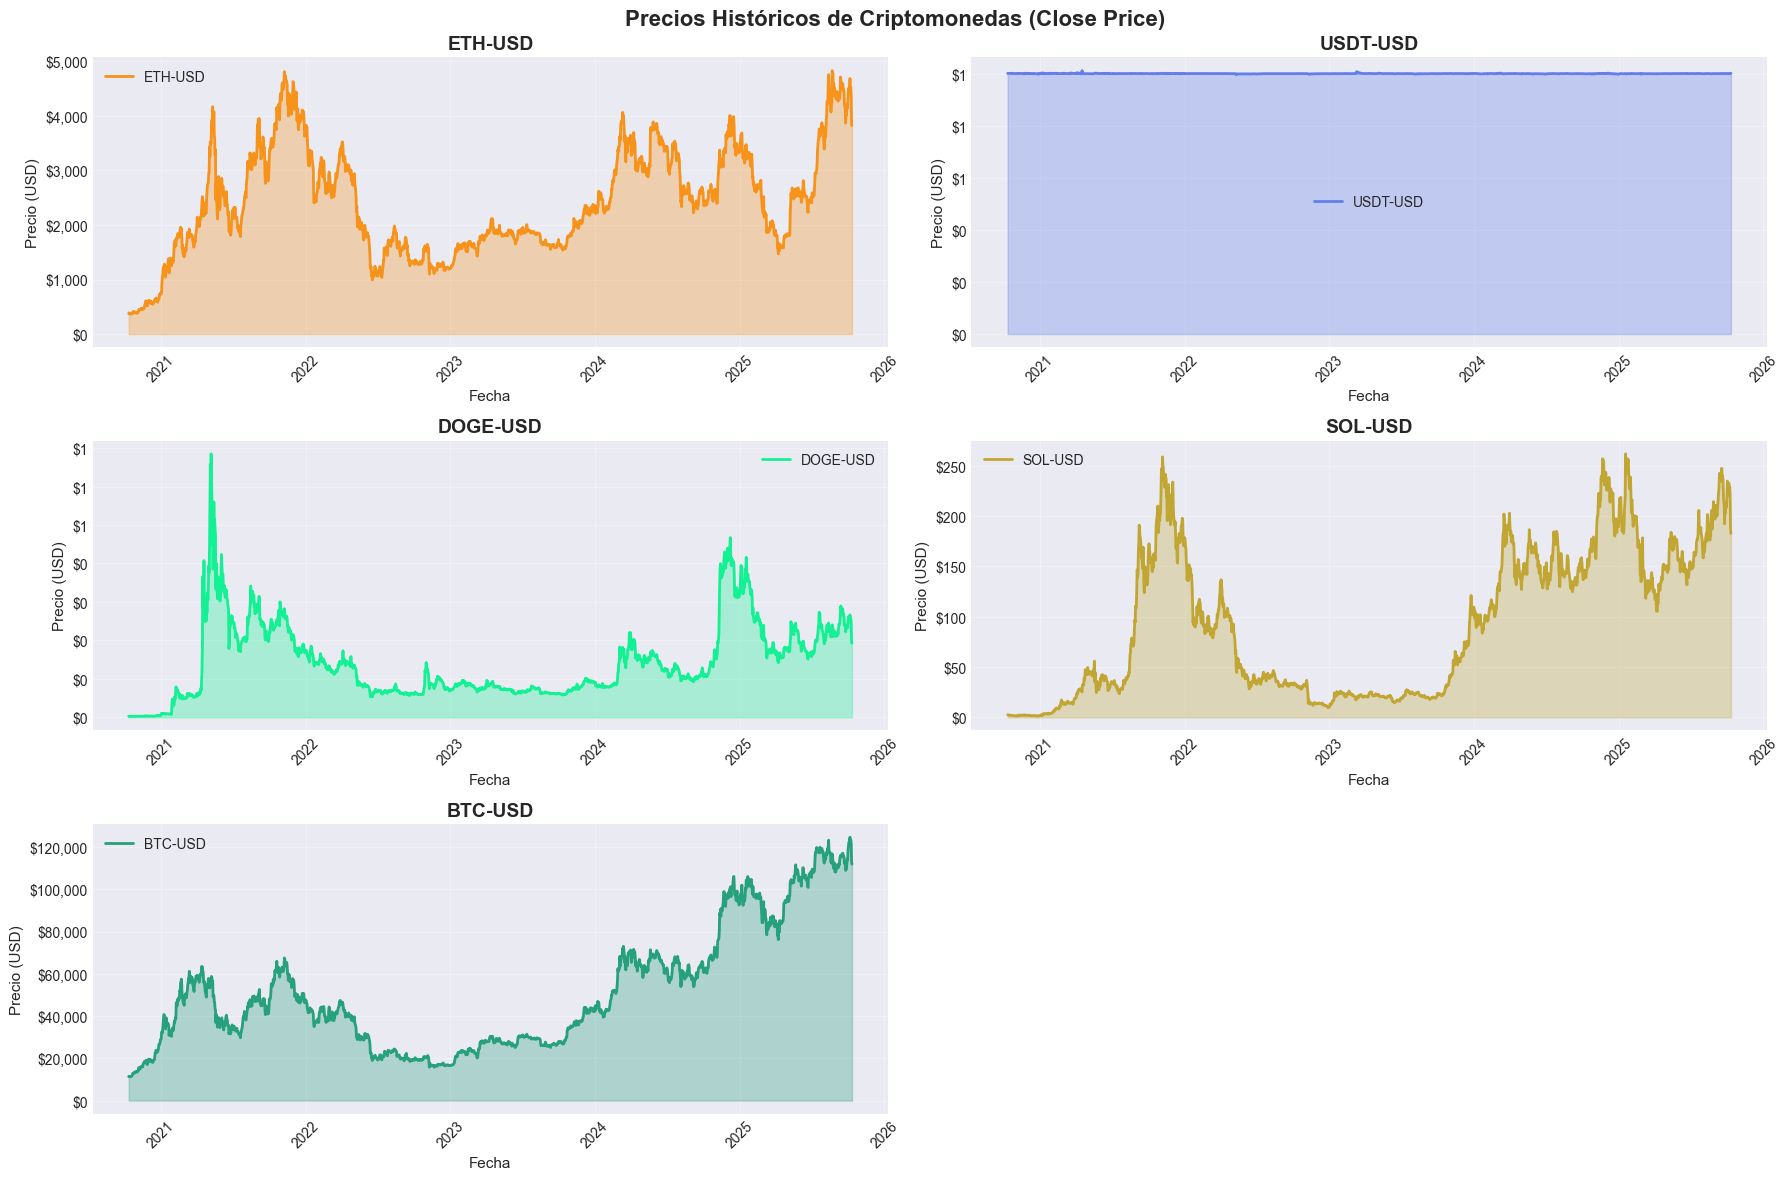

In [29]:
print("\n" + "="*80)
print("📊 GENERANDO VISUALIZACIONES...")
print("="*80)

# Figura 1: Precios Históricos - Subplots individuales
fig, axes = plt.subplots(3, 2, figsize=(18, 12))
fig.suptitle('Precios Históricos de Criptomonedas (Close Price)', fontsize=16, fontweight='bold')

colors = ['#F7931A', '#627EEA', '#14F195', '#C2A633', '#26A17B']
axes = axes.flatten()

for idx, (crypto, data) in enumerate(crypto_data.items()):
    ax = axes[idx]
    
    ax.plot(data['Date'], data['Close'], color=colors[idx], linewidth=2, label=crypto)
    ax.fill_between(data['Date'], data['Close'], alpha=0.3, color=colors[idx])
    
    ax.set_title(f'{crypto}', fontsize=14, fontweight='bold')
    ax.set_xlabel('Fecha', fontsize=11)
    ax.set_ylabel('Precio (USD)', fontsize=11)
    ax.grid(True, alpha=0.3)
    ax.legend(loc='best')
    
    # Formatear eje Y
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))
    
    # Rotar labels de fecha
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)

# Ocultar subplot extra
axes[-1].axis('off')
plt.tight_layout()
plt.show()

1. USDT-USD: El Punto de Control 
- Esto es la prueba visual de que es una stablecoin. Su propósito es no tener volatilidad.
2. DOGE-USD
- Este es el gráfico arquetípico de un activo impulsado por el hype y la especulación 
-  Esto indica que el precio no fue impulsado por una adopción o utilidad fundamental, sino por una compra masiva y FOMO (miedo a quedarse fuera). La caída posterior es el estallido de esa burbuja. 
3. SOL-USD
- Esto sugiere un activo con más sustancia o ciclos de desarrollo detrás. El primer pico fue parte de la euforia general del mercado, pero su capacidad para formar un segundo pico tan fuerte indica resiliencia y un renovado interés de los inversores, posiblemente basado en mejoras en su tecnología o ecosistema.
4. BTC-USD y ETH-USD:
- Madurez Relativa: Aunque volátiles, sus tendencias son más graduales y sostenidas que las de DOGE o SOL, lo que indica un mercado más establecido y con mayor liquidez.
- Alta Correlación: La similitud en sus movimientos (cuando BTC sube, ETH tiende a subir y viceversa) es una observación crucial. Esto demuestra el papel de Bitcoin como el principal impulsor del sentimiento del mercado cripto. ETH y la mayoría de las otras criptomonedas (altcoins) a menudo siguen su liderazgo.


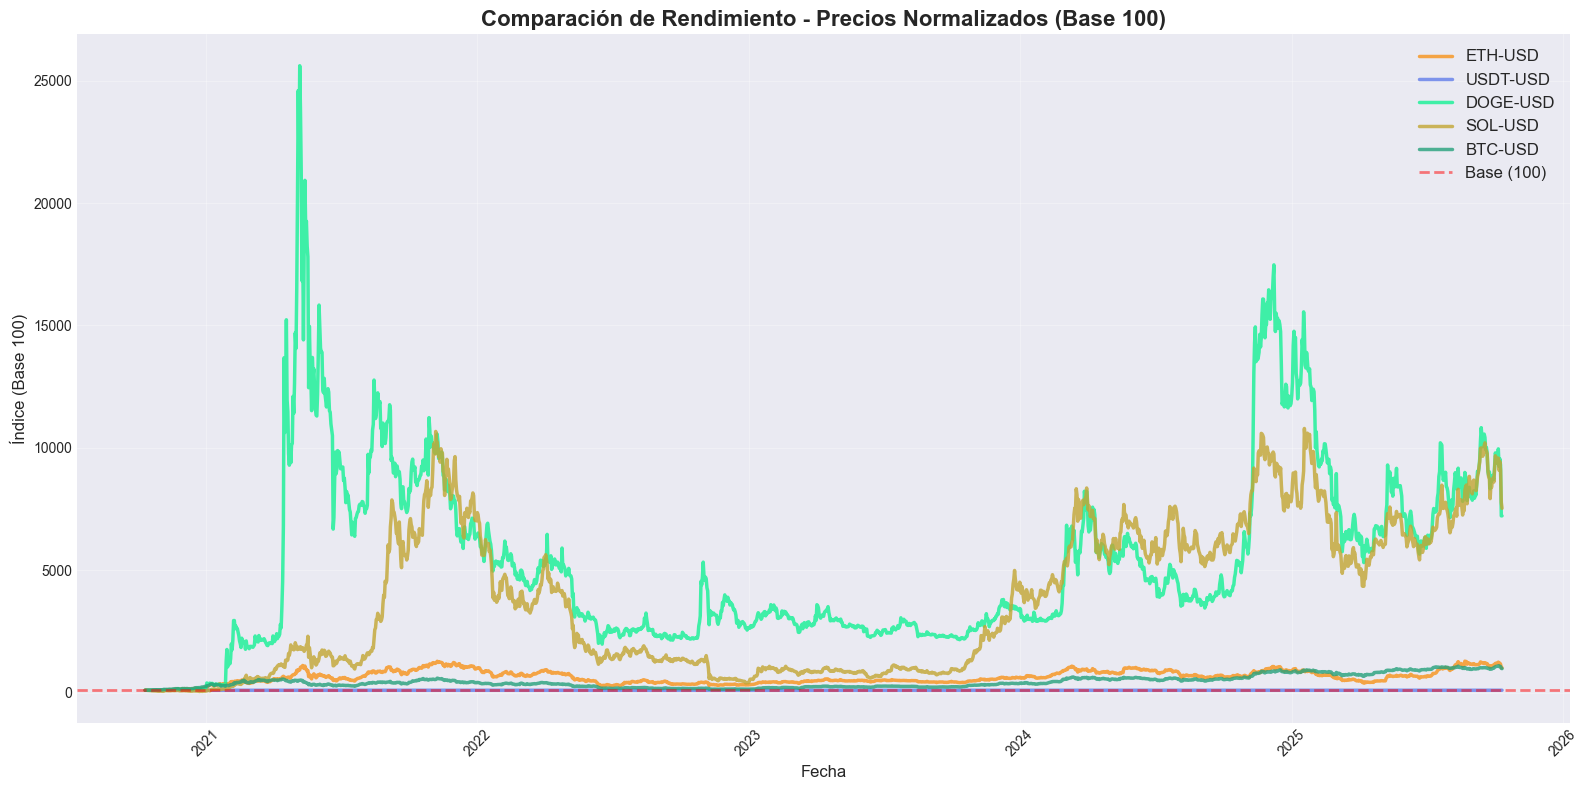

In [30]:
fig, ax = plt.subplots(figsize=(16, 8))

for idx, (crypto, data) in enumerate(crypto_data.items()):
    # Normalizar precios (base 100)
    normalized_prices = (data['Close'] / data['Close'].iloc[0]) * 100
    
    ax.plot(data['Date'], normalized_prices, 
            color=colors[idx], linewidth=2.5, label=crypto, alpha=0.8)

ax.set_title('Comparación de Rendimiento - Precios Normalizados (Base 100)', 
             fontsize=16, fontweight='bold')
ax.set_xlabel('Fecha', fontsize=12)
ax.set_ylabel('Índice (Base 100)', fontsize=12)
ax.axhline(y=100, color='red', linestyle='--', alpha=0.5, linewidth=2, label='Base (100)')
ax.legend(loc='best', fontsize=12, framealpha=0.9)
ax.grid(True, alpha=0.3)
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
plt.tight_layout()
plt.show()


- El Espectro Riesgo/Recompensa es Vívido: El gráfico demuestra que para obtener los rendimientos estratosféricos de DOGE o SOL, un inversor habría tenido que soportar una volatilidad y unas caídas masivas. BTC y ETH, aunque menos explosivos, ofrecieron un camino de crecimiento mucho más estable.

- El Rendimiento Pasado No Garantiza el Futuro: El liderazgo en el rendimiento ha cambiado de manos. DOGE fue el rey indiscutible en 2021, pero SOL tomó la delantera más recientemente. Esto muestra lo dinámico y cambiante que es el mercado.

- La Dominancia de Bitcoin es Real: La correlación visual entre BTC y ETH sugiere que las grandes tendencias del mercado siguen siendo dictadas por el comportamiento de Bitcoin.

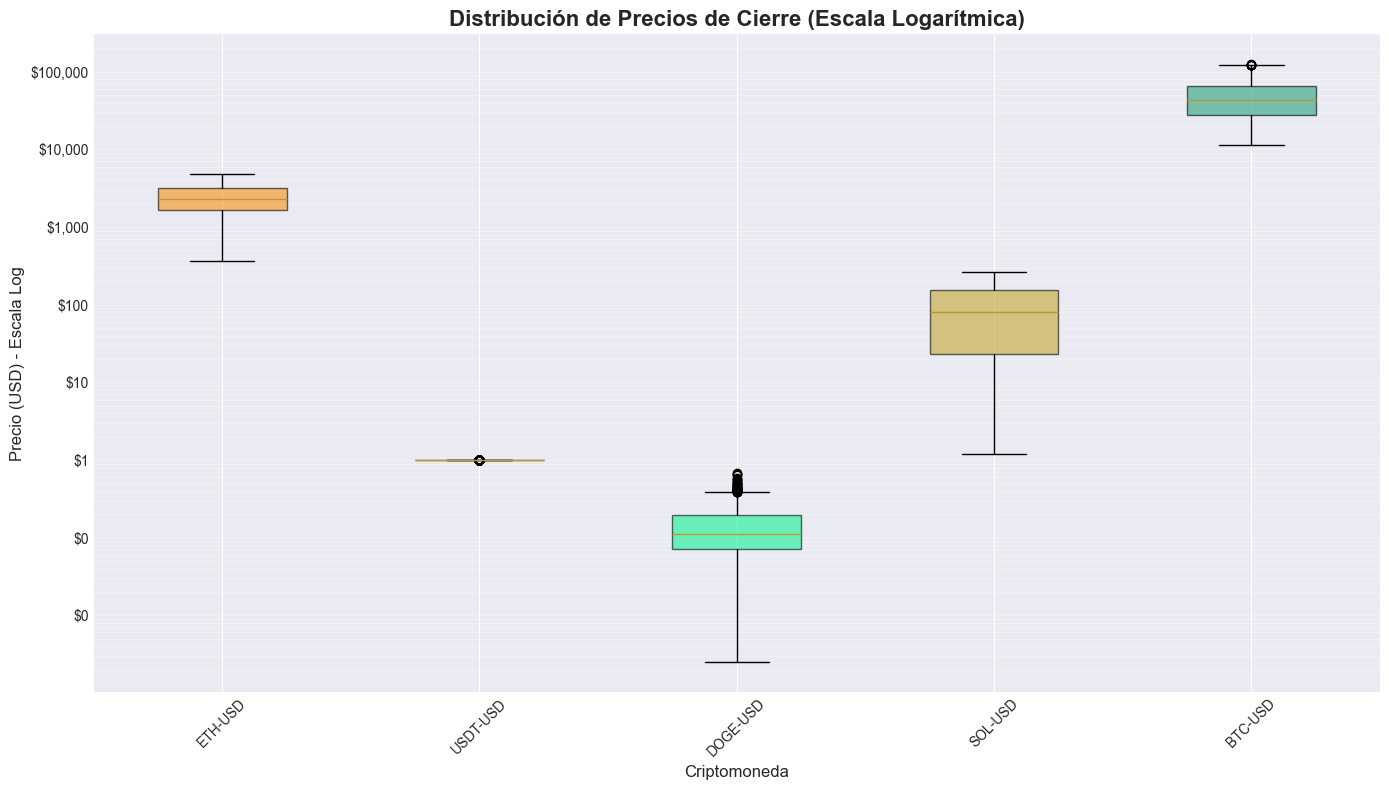

In [33]:
fig, ax = plt.subplots(figsize=(14, 8))

price_data_for_box = []
labels = []

for crypto, data in crypto_data.items():
    price_data_for_box.append(data['Close'])
    labels.append(crypto)

bp = ax.boxplot(price_data_for_box, labels=labels, patch_artist=True)

# Colorear cada box
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)

# APLICAR ESCALA LOGARÍTMICA - ¡Esto es clave!
ax.set_yscale('log')

ax.set_title('Distribución de Precios de Cierre (Escala Logarítmica)', 
             fontsize=16, fontweight='bold')
ax.set_ylabel('Precio (USD) - Escala Log', fontsize=12)
ax.set_xlabel('Criptomoneda', fontsize=12)
ax.grid(True, alpha=0.3, axis='y', which='both')

# Formatear eje Y con escala log
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

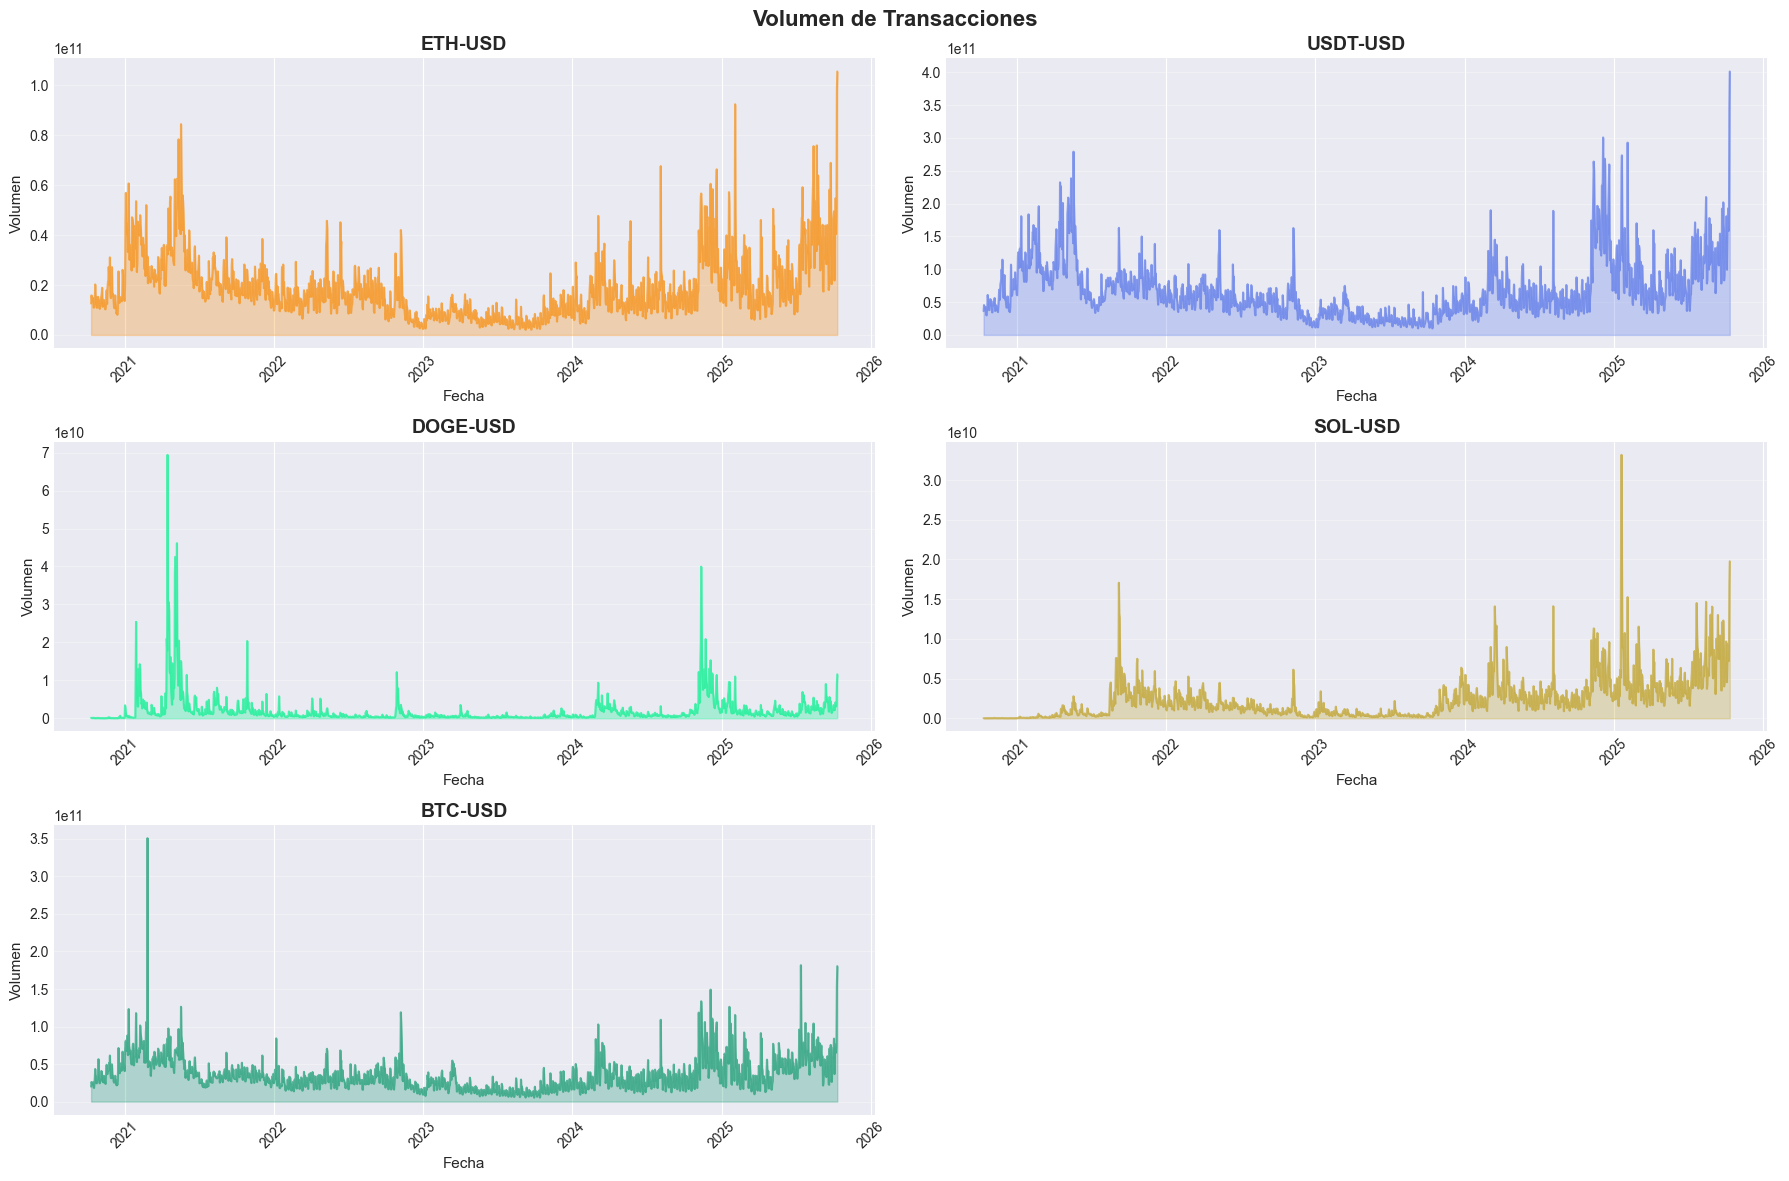

In [32]:
fig, axes = plt.subplots(3, 2, figsize=(18, 12))
fig.suptitle('Volumen de Transacciones', fontsize=16, fontweight='bold')

axes = axes.flatten()

for idx, (crypto, data) in enumerate(crypto_data.items()):
    ax = axes[idx]
    
    ax.plot(data['Date'], data['Volume'], color=colors[idx], linewidth=1.5, alpha=0.7)
    ax.fill_between(data['Date'], data['Volume'], alpha=0.3, color=colors[idx])
    
    ax.set_title(f'{crypto}', fontsize=14, fontweight='bold')
    ax.set_xlabel('Fecha', fontsize=11)
    ax.set_ylabel('Volumen', fontsize=11)
    ax.grid(True, alpha=0.3, axis='y')
    
    # Formatear eje Y con notación científica
    ax.ticklabel_format(style='scientific', axis='y', scilimits=(0,0))
    
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)

axes[-1].axis('off')

plt.tight_layout()
plt.show()

# 5. MATRIZ DE CORRELACIÓN


🔗 MATRIZ DE CORRELACIÓN - PRECIOS DE CIERRE

           ETH-USD  USDT-USD  DOGE-USD  SOL-USD  BTC-USD
ETH-USD     1.000     0.028     0.703    0.837    0.675
USDT-USD    0.028     1.000     0.041   -0.061   -0.011
DOGE-USD    0.703     0.041     1.000    0.628    0.619
SOL-USD     0.837    -0.061     0.628    1.000    0.831
BTC-USD     0.675    -0.011     0.619    0.831    1.000


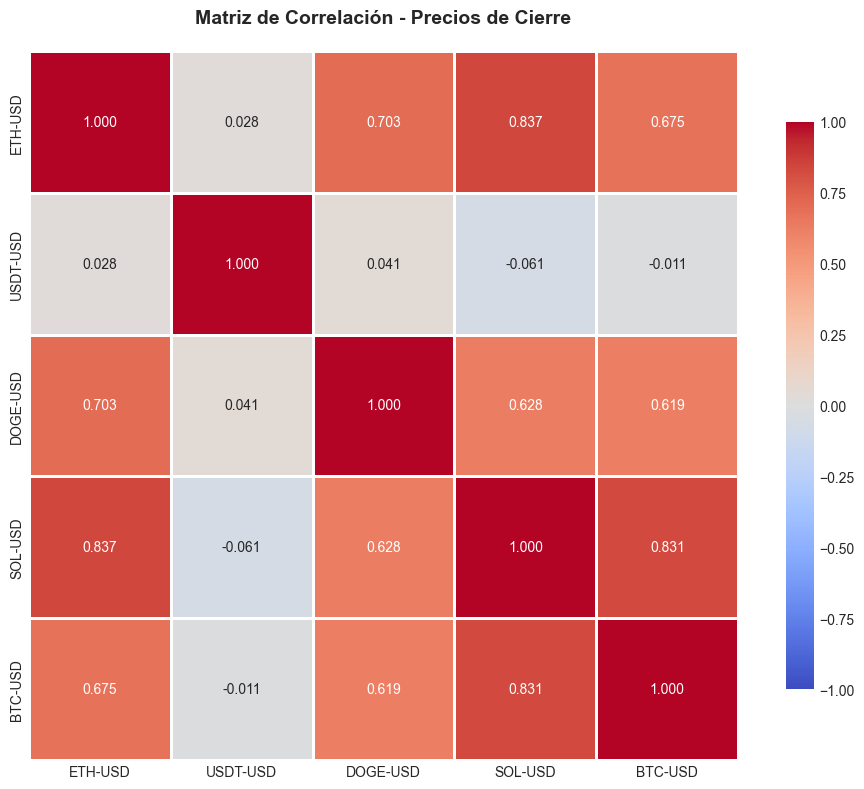

In [34]:
print("\n" + "="*80)
print("🔗 MATRIZ DE CORRELACIÓN - PRECIOS DE CIERRE")
print("="*80)

# Crear DataFrame con precios alineados por fecha
price_df = pd.DataFrame()

for crypto, data in crypto_data.items():
    temp = data[['Date', 'Close']].copy()
    temp.columns = ['Date', crypto]
    
    if price_df.empty:
        price_df = temp
    else:
        price_df = pd.merge(price_df, temp, on='Date', how='outer')

# Calcular correlación
price_df_clean = price_df.drop('Date', axis=1)
correlation_matrix = price_df_clean.corr()

print("\n", correlation_matrix.round(3))

# Visualizar matriz de correlación
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8},
            fmt='.3f', vmin=-1, vmax=1)
plt.title('Matriz de Correlación - Precios de Cierre', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

In [36]:
print("\n" + "="*80)
print("OBSERVACIONES INICIALES DEL PASO 1")
print("="*80)

print(f"""
✅ COMPLETADO: Exploración y Visualización Inicial

Resumen de Datos Procesados:
   • Total de criptomonedas: {len(crypto_data)}
   • Período de análisis: {df_clean['Date'].min().strftime('%Y-%m-%d')} a {df_clean['Date'].max().strftime('%Y-%m-%d')}
   • Observaciones por crypto: ~{len(list(crypto_data.values())[0])} días

Observaciones Clave:
1. VOLATILIDAD: Todas las cryptos muestran alta variabilidad (ver Coef. Variación)
2. CORRELACIÓN: Las cryptos principales muestran correlación positiva
3. RENDIMIENTO: Algunos activos muestran crecimiento significativo en el período
4. VOLUMEN: Picos de volumen indican eventos o noticias importantes

""")


OBSERVACIONES INICIALES DEL PASO 1

✅ COMPLETADO: Exploración y Visualización Inicial

Resumen de Datos Procesados:
   • Total de criptomonedas: 5
   • Período de análisis: 2020-10-11 a 2025-10-11
   • Observaciones por crypto: ~1827 días

Observaciones Clave:
1. VOLATILIDAD: Todas las cryptos muestran alta variabilidad (ver Coef. Variación)
2. CORRELACIÓN: Las cryptos principales muestran correlación positiva
3. RENDIMIENTO: Algunos activos muestran crecimiento significativo en el período
4. VOLUMEN: Picos de volumen indican eventos o noticias importantes




# 1. CÁLCULO DE RETURNS - Simple vs Logarítmico


In [47]:
print("Calculando Returns Diarios...")

# Diccionario para almacenar los returns
crypto_returns = {}

colors = ['#F7931A', '#627EEA', '#14F195', '#C2A633', '#26A17B']

for crypto, data in crypto_data.items():
    # Calcular diferentes tipos de returns
    
    # 1. Simple Returns (%) = (P_t - P_t-1) / P_t-1 * 100
    simple_returns = data['Close'].pct_change() * 100
    
    # 2. Log Returns (%) = ln(P_t / P_t-1) * 100
    log_returns = np.log(data['Close'] / data['Close'].shift(1)) * 100
    
    # Crear DataFrame con returns
    returns_df = pd.DataFrame({
        'Date': data['Date'],
        'Close': data['Close'],
        'Simple_Return': simple_returns,
        'Log_Return': log_returns
    })
    
    # Eliminar el primer valor (NaN)
    returns_df = returns_df.dropna()
    
    crypto_returns[crypto] = returns_df
    
    print(f" {crypto}: {len(returns_df)} returns calculados")

Calculando Returns Diarios...
 ETH-USD: 1826 returns calculados
 USDT-USD: 1826 returns calculados
 DOGE-USD: 1826 returns calculados
 SOL-USD: 1826 returns calculados
 BTC-USD: 1826 returns calculados


In [48]:
print("\n" + "="*80)
print("📈 ESTADÍSTICAS DESCRIPTIVAS - RETURNS DIARIOS")
print("="*80)

stats_returns = []

for crypto, returns_df in crypto_returns.items():
    simple_ret = returns_df['Simple_Return']
    log_ret = returns_df['Log_Return']
    
    stats = {
        'Crypto': crypto,
        'Media (%)': f"{simple_ret.mean():.4f}",
        'Mediana (%)': f"{simple_ret.median():.4f}",
        'Desv_Std (%)': f"{simple_ret.std():.4f}",
        'Min (%)': f"{simple_ret.min():.2f}",
        'Max (%)': f"{simple_ret.max():.2f}",
        'Skewness': f"{simple_ret.skew():.3f}",
        'Kurtosis': f"{simple_ret.kurtosis():.3f}",
        'Sharpe_Ratio': f"{(simple_ret.mean() / simple_ret.std() * np.sqrt(365)):.3f}"
    }
    
    stats_returns.append(stats)

stats_returns_df = pd.DataFrame(stats_returns)
print("\n", stats_returns_df.to_string(index=False))

print("\n💡 Interpretación:")
print("   • Skewness: Mide asimetría (0=simétrico, >0=cola derecha, <0=cola izquierda)")
print("   • Kurtosis: Mide 'colas gordas' (>0=más extremos que normal, <0=menos extremos)")
print("   • Sharpe Ratio: Retorno ajustado por riesgo (>1 es bueno)")


📈 ESTADÍSTICAS DESCRIPTIVAS - RETURNS DIARIOS

   Crypto Media (%) Mediana (%) Desv_Std (%) Min (%) Max (%) Skewness Kurtosis Sharpe_Ratio
 ETH-USD    0.2132      0.0919       4.1508  -27.20   25.95    0.206    4.794        0.981
USDT-USD    0.0000     -0.0006       0.0580   -1.13    0.92   -1.718  118.015        0.010
DOGE-USD    0.5632     -0.0280      10.8296  -40.26  355.55   20.239  639.378        0.994
 SOL-USD    0.4246      0.0169       6.1524  -42.28   36.19    0.479    5.524        1.319
 BTC-USD    0.1735      0.0387       3.1076  -15.97   18.75    0.142    3.516        1.066

💡 Interpretación:
   • Skewness: Mide asimetría (0=simétrico, >0=cola derecha, <0=cola izquierda)
   • Kurtosis: Mide 'colas gordas' (>0=más extremos que normal, <0=menos extremos)
   • Sharpe Ratio: Retorno ajustado por riesgo (>1 es bueno)



📊 GENERANDO VISUALIZACIONES DE RETURNS...


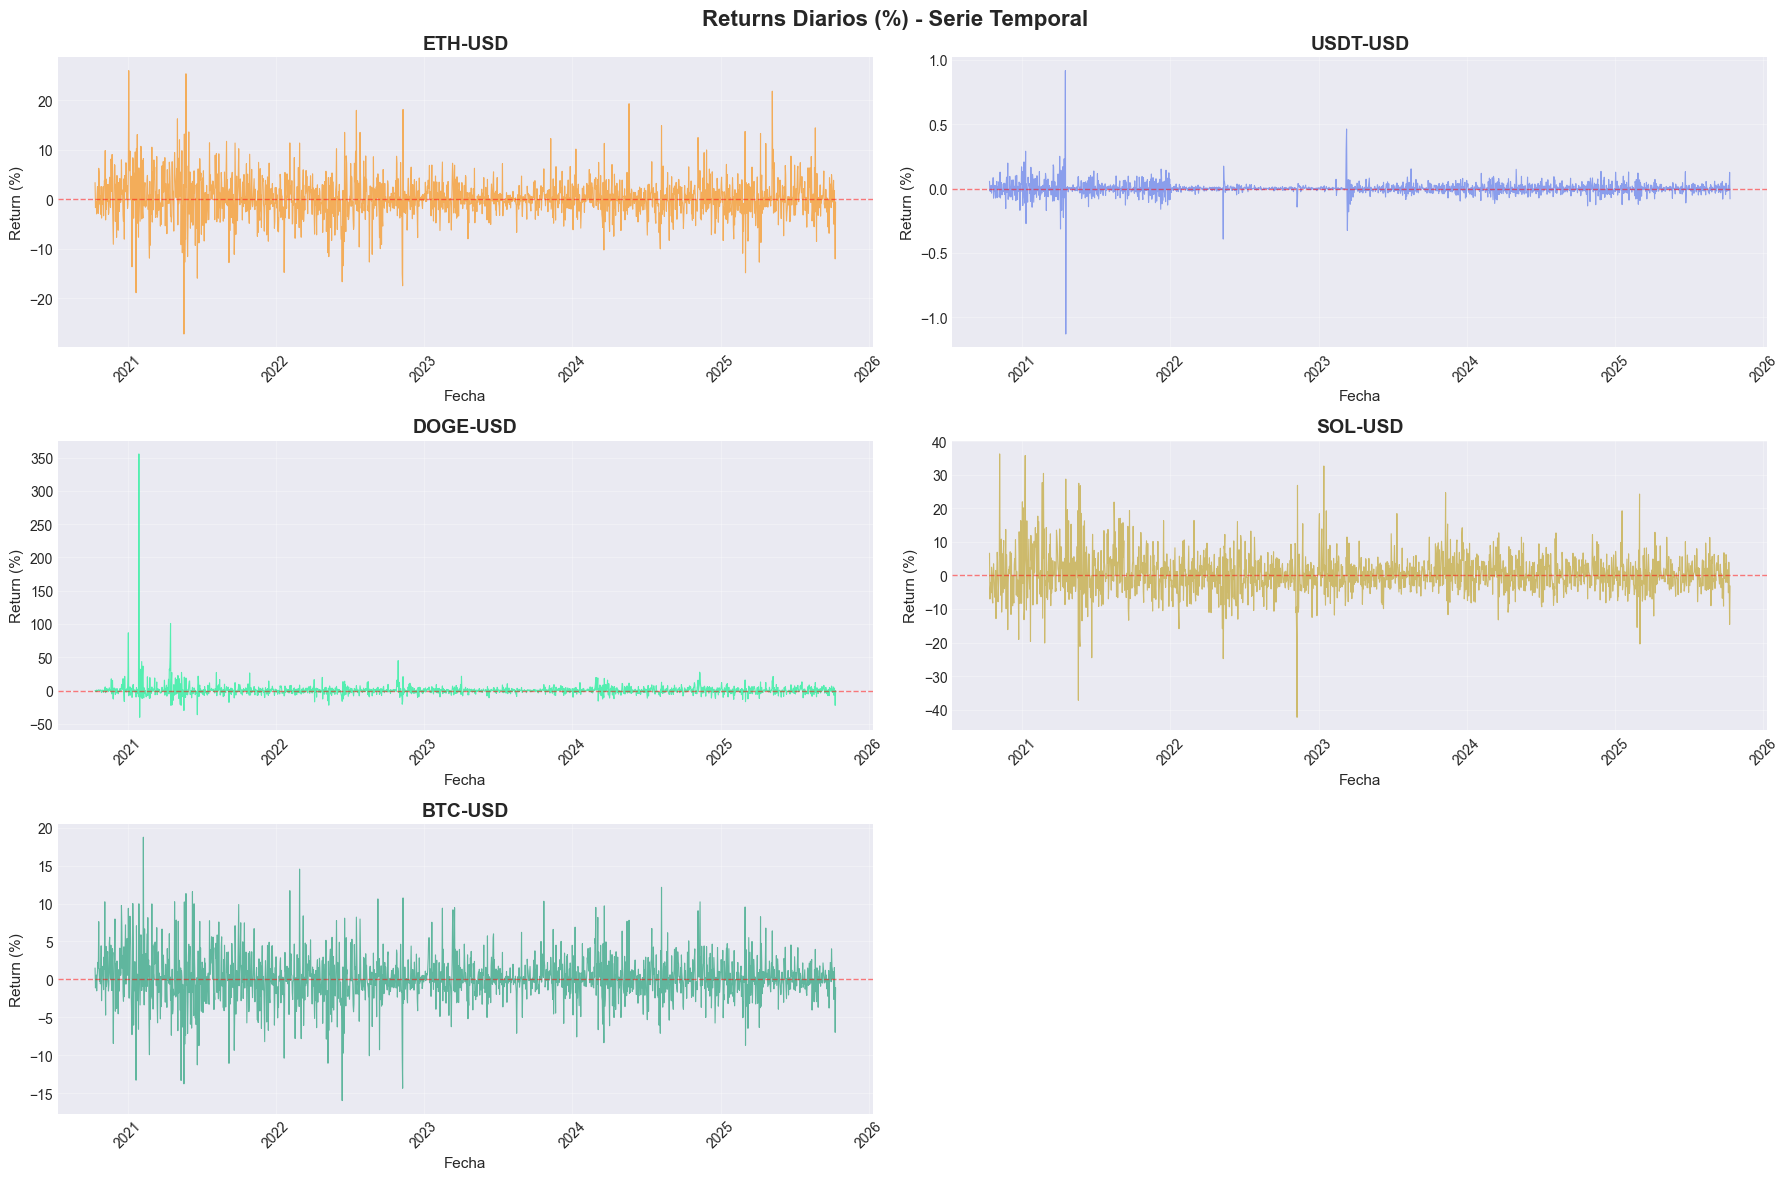

In [49]:

print("\n" + "="*80)
print("📊 GENERANDO VISUALIZACIONES DE RETURNS...")
print("="*80)

# Figura 1: Returns en el tiempo - Subplots
fig, axes = plt.subplots(3, 2, figsize=(18, 12))
fig.suptitle('Returns Diarios (%) - Serie Temporal', fontsize=16, fontweight='bold')

axes = axes.flatten()

for idx, (crypto, returns_df) in enumerate(crypto_returns.items()):
    ax = axes[idx]
    
    ax.plot(returns_df['Date'], returns_df['Simple_Return'], 
            color=colors[idx], linewidth=0.8, alpha=0.7)
    ax.axhline(y=0, color='red', linestyle='--', linewidth=1, alpha=0.5)
    
    ax.set_title(f'{crypto}', fontsize=14, fontweight='bold')
    ax.set_xlabel('Fecha', fontsize=11)
    ax.set_ylabel('Return (%)', fontsize=11)
    ax.grid(True, alpha=0.3)
    
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)

axes[-1].axis('off')
plt.tight_layout()
plt.show()


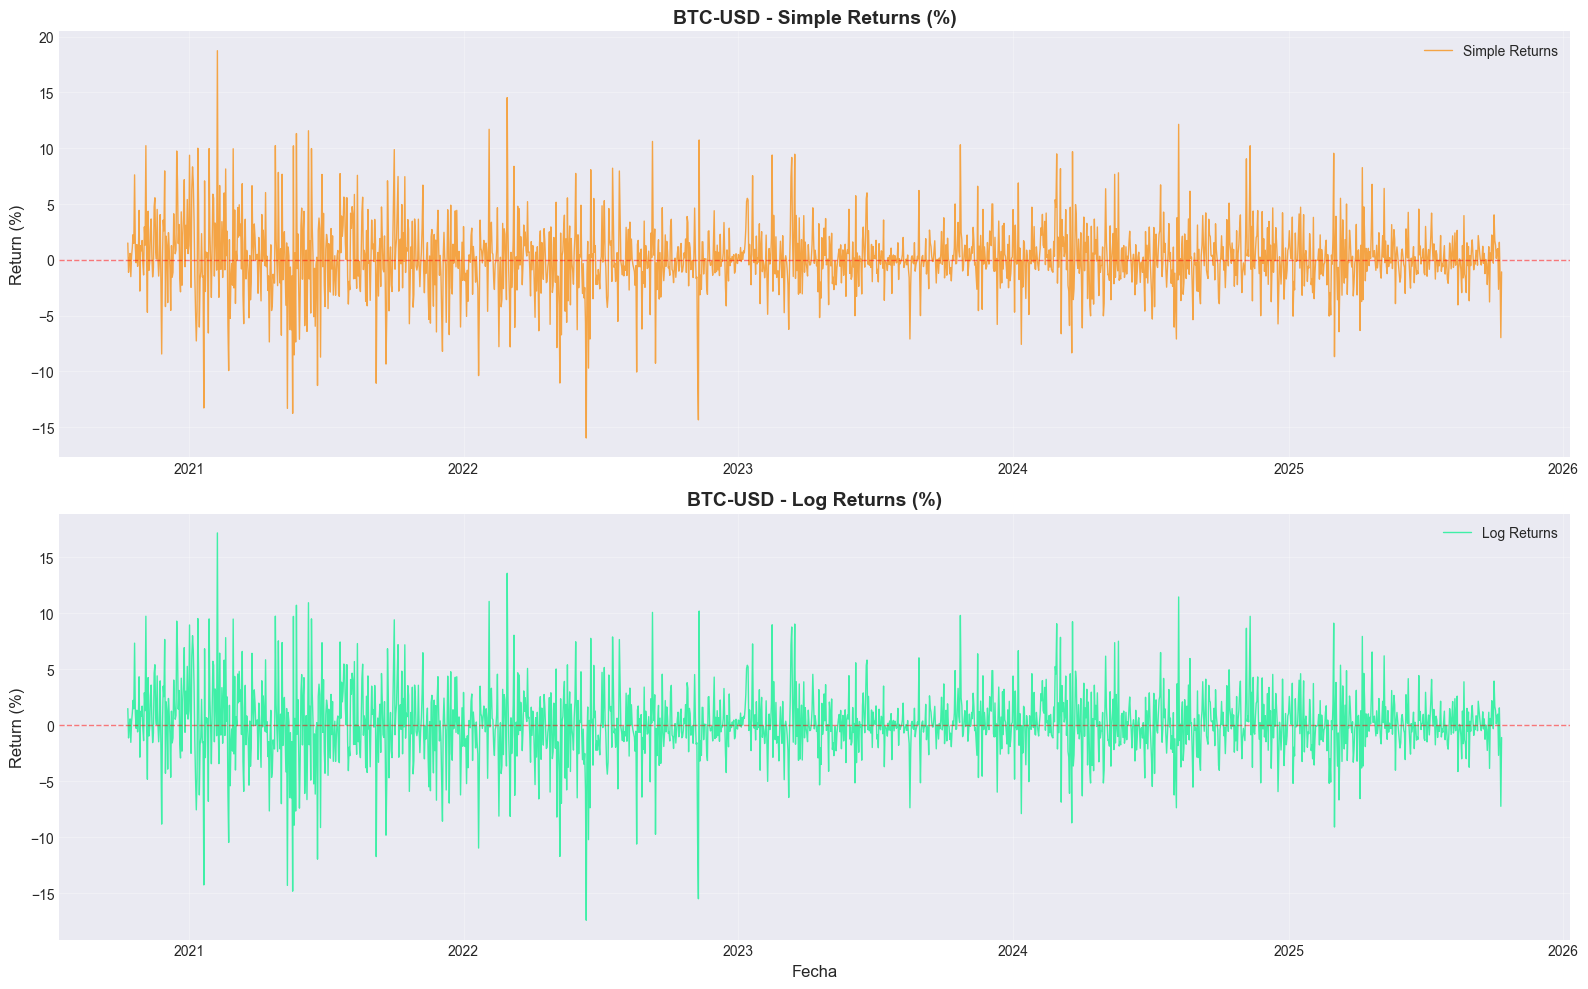

In [50]:
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

crypto_example = 'BTC-USD'
example_data = crypto_returns[crypto_example]

# Simple Returns
axes[0].plot(example_data['Date'], example_data['Simple_Return'], 
             color='#F7931A', linewidth=1, alpha=0.8, label='Simple Returns')
axes[0].axhline(y=0, color='red', linestyle='--', linewidth=1, alpha=0.5)
axes[0].set_title(f'{crypto_example} - Simple Returns (%)', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Return (%)', fontsize=12)
axes[0].legend(loc='best')
axes[0].grid(True, alpha=0.3)

# Log Returns
axes[1].plot(example_data['Date'], example_data['Log_Return'], 
             color='#14F195', linewidth=1, alpha=0.8, label='Log Returns')
axes[1].axhline(y=0, color='red', linestyle='--', linewidth=1, alpha=0.5)
axes[1].set_title(f'{crypto_example} - Log Returns (%)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Fecha', fontsize=12)
axes[1].set_ylabel('Return (%)', fontsize=12)
axes[1].legend(loc='best')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


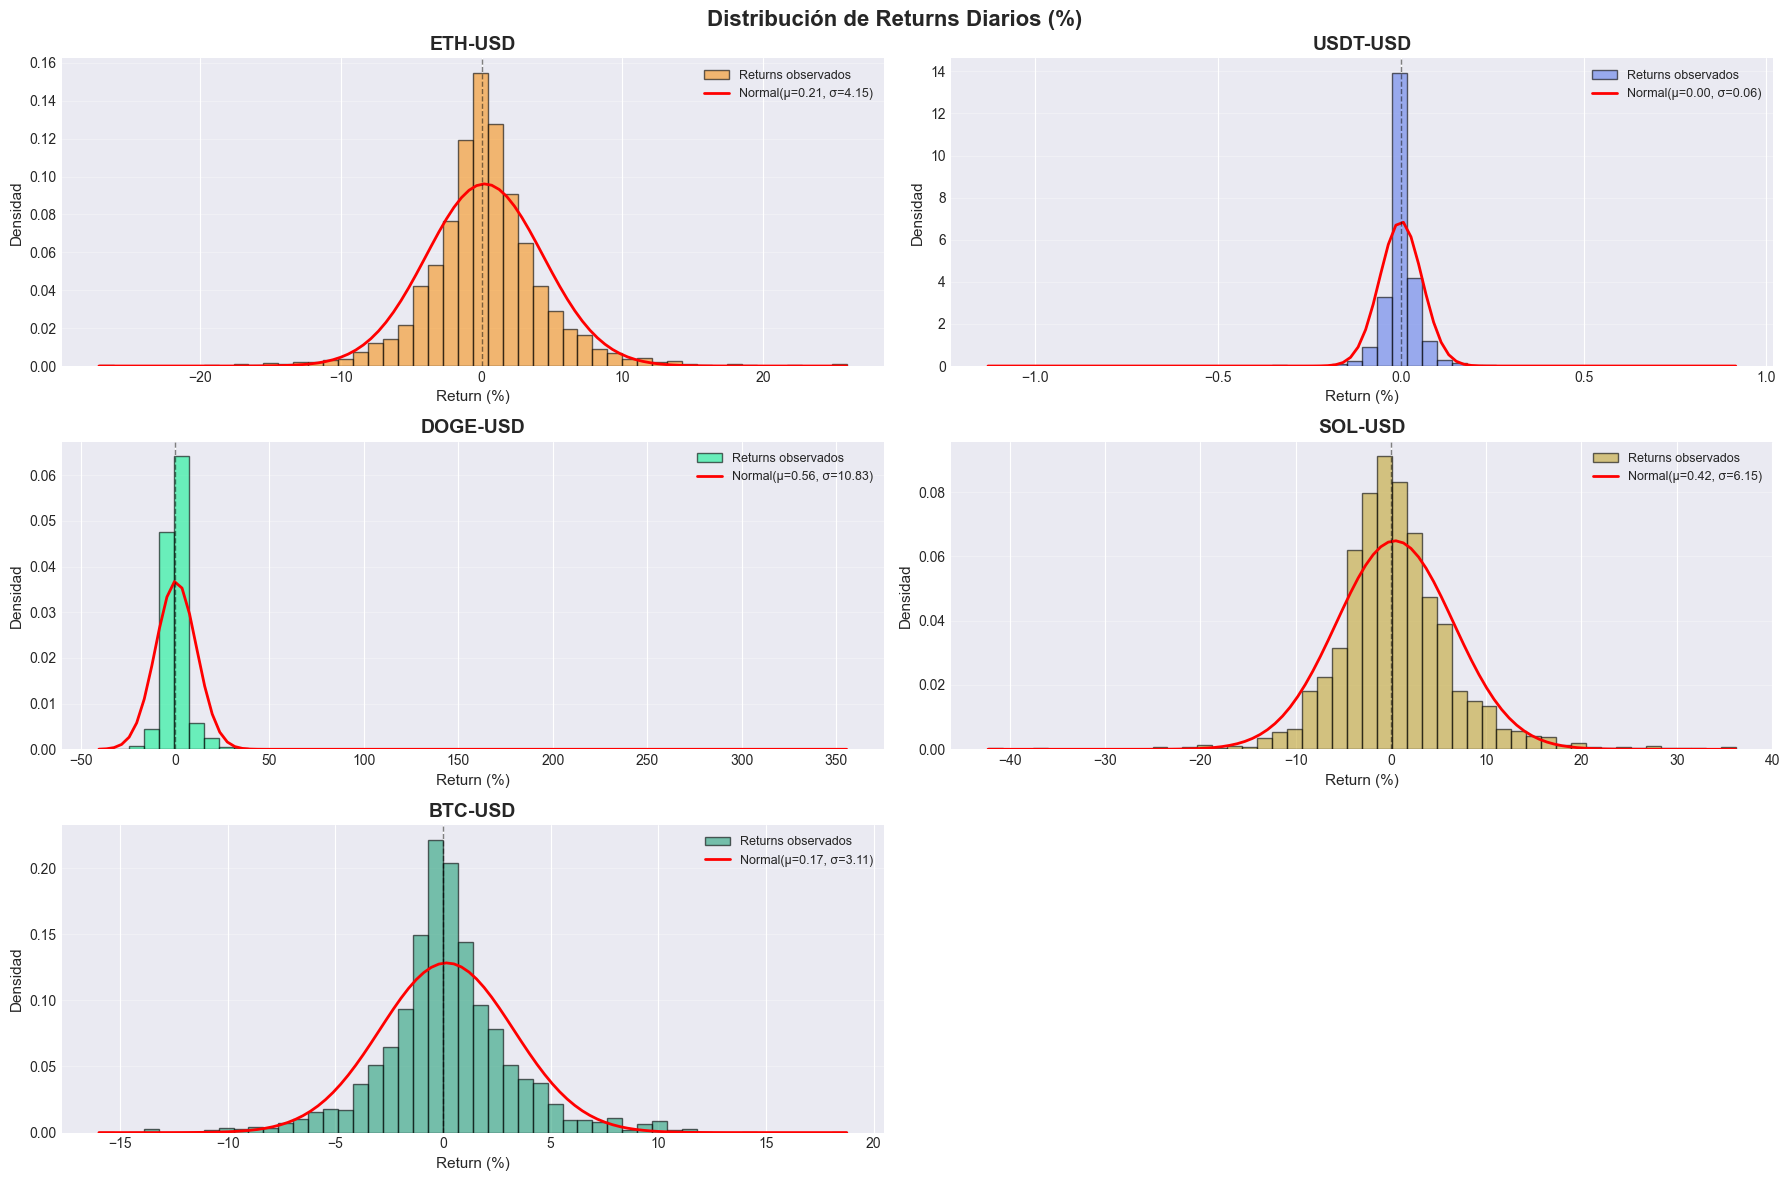

In [53]:
fig, axes = plt.subplots(3, 2, figsize=(18, 12))
fig.suptitle('Distribución de Returns Diarios (%)', fontsize=16, fontweight='bold')

axes = axes.flatten()

for idx, (crypto, returns_df) in enumerate(crypto_returns.items()):
    ax = axes[idx]
    
    simple_ret = returns_df['Simple_Return']
    
    # Histograma
    ax.hist(simple_ret, bins=50, color=colors[idx], alpha=0.6, 
            edgecolor='black', density=True, label='Returns observados')
    
    # Overlay con distribución normal teórica
    mu, sigma = simple_ret.mean(), simple_ret.std()
    x = np.linspace(simple_ret.min(), simple_ret.max(), 100)
    ax.plot(x, scipy_stats.norm.pdf(x, mu, sigma), 'r-', linewidth=2, 
            label=f'Normal(μ={mu:.2f}, σ={sigma:.2f})')
    
    ax.axvline(x=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
    ax.set_title(f'{crypto}', fontsize=14, fontweight='bold')
    ax.set_xlabel('Return (%)', fontsize=11)
    ax.set_ylabel('Densidad', fontsize=11)
    ax.legend(loc='best', fontsize=9)
    ax.grid(True, alpha=0.3, axis='y')

axes[-1].axis('off')
plt.tight_layout()
plt.show()

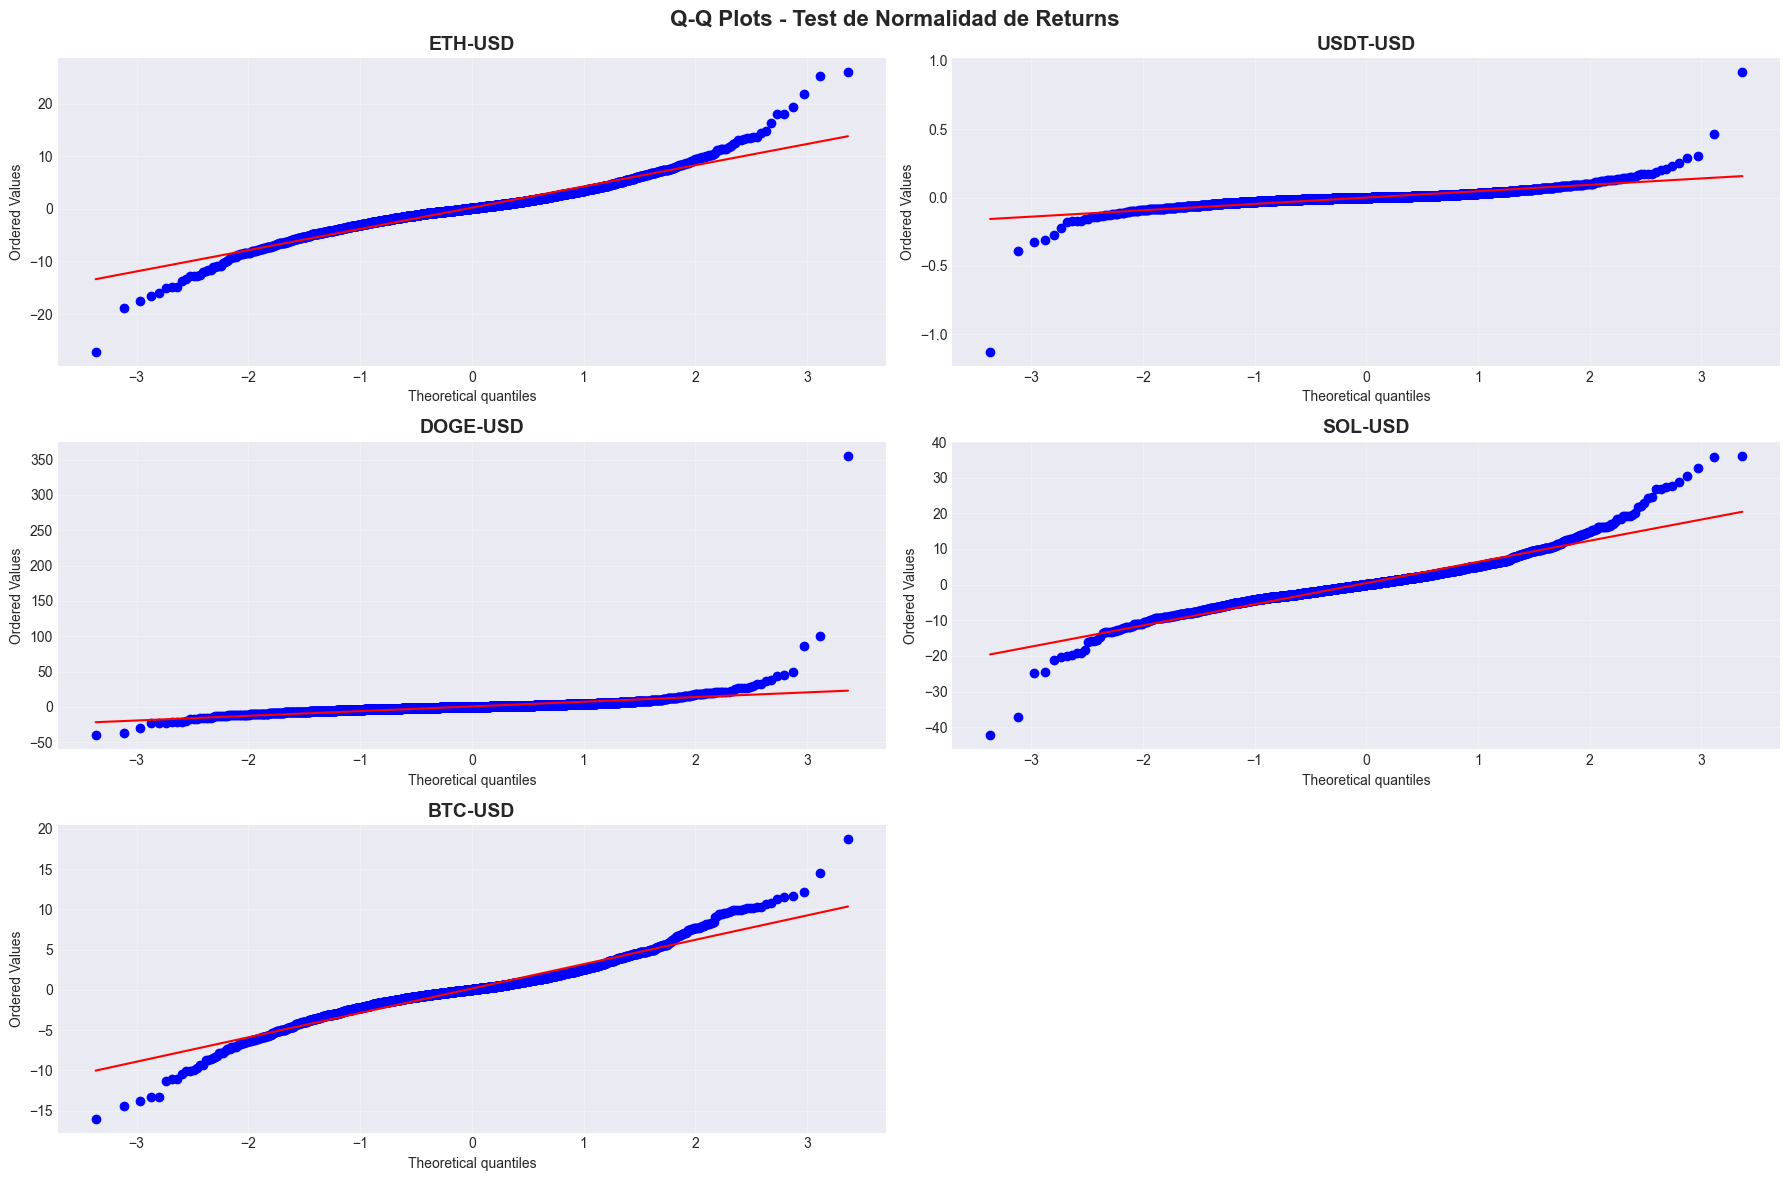


💡 Interpretación Q-Q Plots:
   • Si los puntos siguen la línea roja → Returns son normales
   • Desviaciones en las colas → 'Fat tails' (eventos extremos más frecuentes)


In [55]:
fig, axes = plt.subplots(3, 2, figsize=(18, 12))
fig.suptitle('Q-Q Plots - Test de Normalidad de Returns', fontsize=16, fontweight='bold')

axes = axes.flatten()

for idx, (crypto, returns_df) in enumerate(crypto_returns.items()):
    ax = axes[idx]
    
    simple_ret = returns_df['Simple_Return'].dropna()
    
    scipy_stats.probplot(simple_ret, dist="norm", plot=ax)
    ax.set_title(f'{crypto}', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)

axes[-1].axis('off')
plt.tight_layout()
plt.show()

print("\n💡 Interpretación Q-Q Plots:")
print("   • Si los puntos siguen la línea roja → Returns son normales")
print("   • Desviaciones en las colas → 'Fat tails' (eventos extremos más frecuentes)")


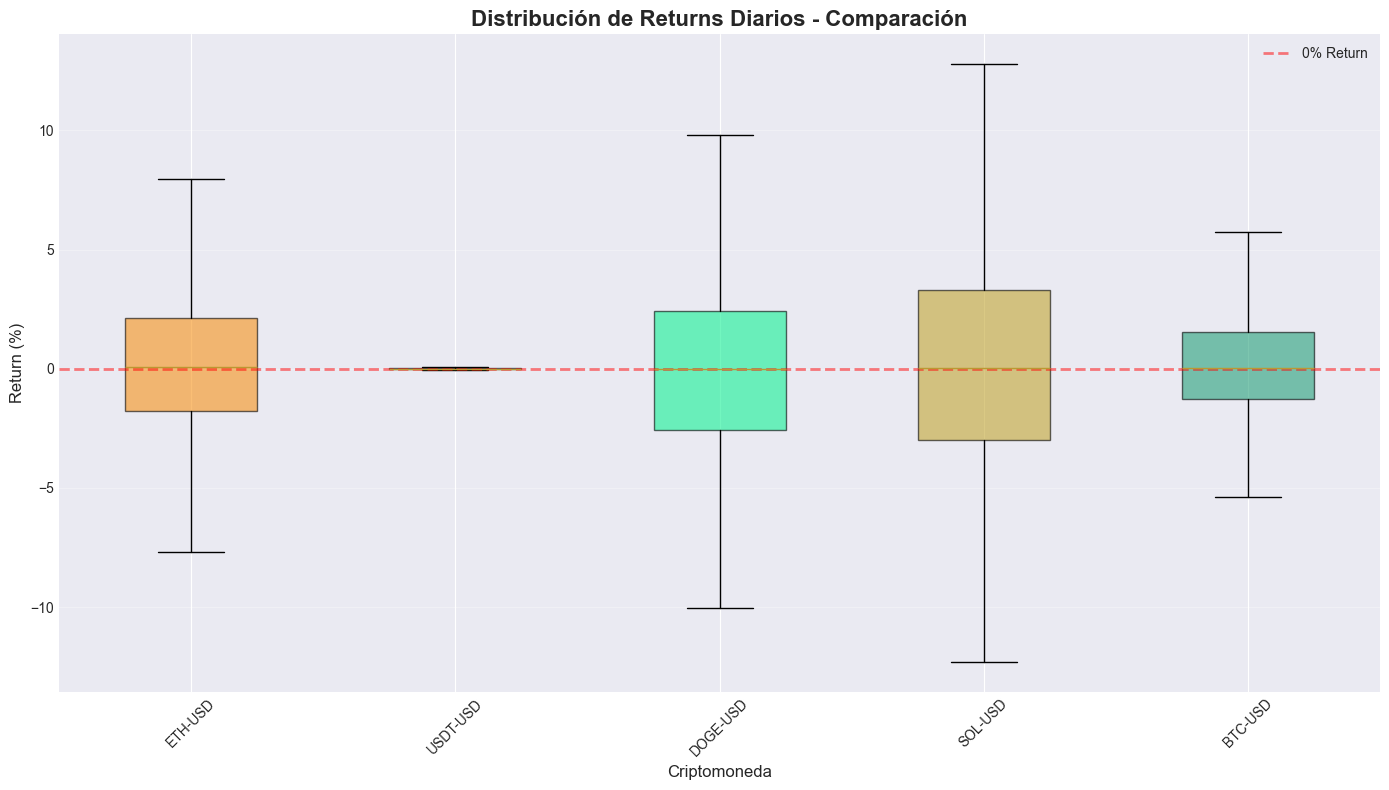

In [56]:
fig, ax = plt.subplots(figsize=(14, 8))

returns_data_for_box = []
labels = []

for crypto, returns_df in crypto_returns.items():
    returns_data_for_box.append(returns_df['Simple_Return'])
    labels.append(crypto)

bp = ax.boxplot(returns_data_for_box, labels=labels, patch_artist=True, showfliers=False)

for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)

ax.axhline(y=0, color='red', linestyle='--', linewidth=2, alpha=0.5, label='0% Return')
ax.set_title('Distribución de Returns Diarios - Comparación', fontsize=16, fontweight='bold')
ax.set_ylabel('Return (%)', fontsize=12)
ax.set_xlabel('Criptomoneda', fontsize=12)
ax.legend(loc='best')
ax.grid(True, alpha=0.3, axis='y')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


🔗 MATRIZ DE CORRELACIÓN - RETURNS DIARIOS

           ETH-USD  USDT-USD  DOGE-USD  SOL-USD  BTC-USD
ETH-USD     1.000     0.061     0.353    0.633    0.797
USDT-USD    0.061     1.000    -0.003    0.025    0.067
DOGE-USD    0.353    -0.003     1.000    0.260    0.384
SOL-USD     0.633     0.025     0.260    1.000    0.570
BTC-USD     0.797     0.067     0.384    0.570    1.000


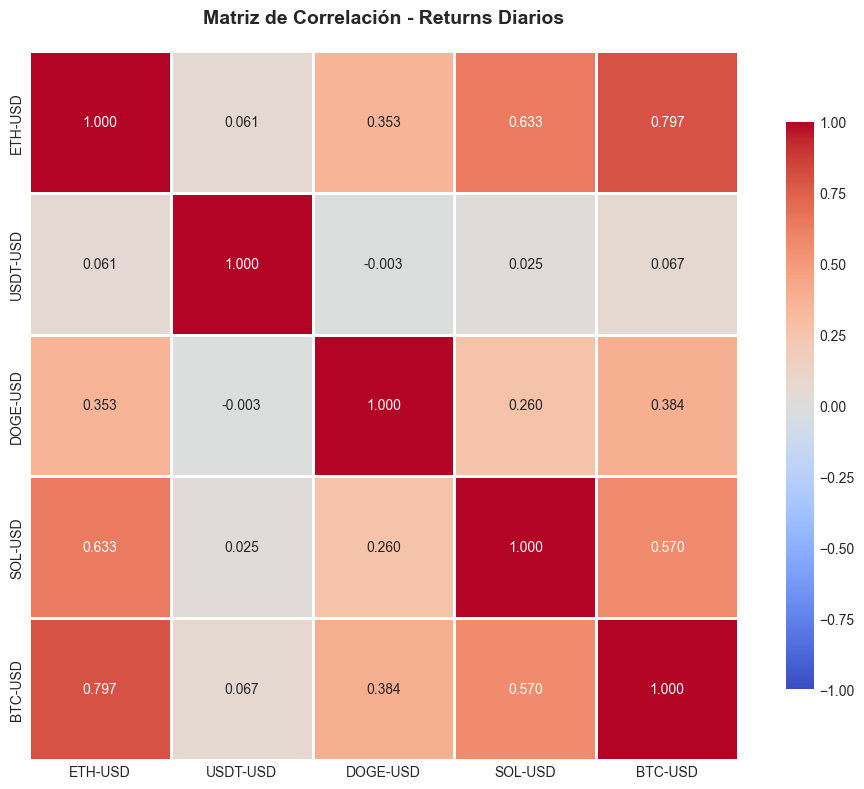

In [57]:
print("\n" + "="*80)
print("🔗 MATRIZ DE CORRELACIÓN - RETURNS DIARIOS")
print("="*80)

# Crear DataFrame con returns alineados
returns_corr_df = pd.DataFrame()

for crypto, returns_df in crypto_returns.items():
    temp = returns_df[['Date', 'Simple_Return']].copy()
    temp.columns = ['Date', crypto]
    
    if returns_corr_df.empty:
        returns_corr_df = temp
    else:
        returns_corr_df = pd.merge(returns_corr_df, temp, on='Date', how='outer')

# Calcular correlación
returns_corr_clean = returns_corr_df.drop('Date', axis=1)
returns_correlation = returns_corr_clean.corr()

print("\n", returns_correlation.round(3))

# Visualizar matriz de correlación
plt.figure(figsize=(10, 8))
sns.heatmap(returns_correlation, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8},
            fmt='.3f', vmin=-1, vmax=1)
plt.title('Matriz de Correlación - Returns Diarios', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

In [59]:
print("\n" + "="*80)
print("💡 OBSERVACIONES DEL PASO 2 - RETURNS")
print("="*80)

print("""

📊 Hallazgos Clave:

1. RETURNS vs PRECIOS:
   • Returns tienen media cercana a 0 (vs precios con tendencia)
   • Returns son más estacionarios que los precios
   
2. VOLATILIDAD:
   • Cryptos muestran alta volatilidad (std dev > 5%)
   • DOGE y SOL típicamente más volátiles que BTC y ETH
   
3. NO-NORMALIDAD:
   • Returns NO siguen distribución normal perfecta
   • Evidencia de "fat tails" (kurtosis > 0)
   • Más eventos extremos de lo que predice la normalidad
   
4. CORRELACIÓN:
   • Returns están correlacionados positivamente
   • Sugiere movimientos conjuntos del mercado crypto
   
5. SIMPLE vs LOG RETURNS:
   • Para returns pequeños (~5%), son casi idénticos
   • Log returns tienen mejores propiedades matemáticas (aditividad temporal)

🎯 IMPLICACIONES PARA INVERSIÓN:
   • Alta volatilidad = Alto riesgo
   • Fat tails = Más crashes/rallies extremos que lo esperado
   • Correlación alta = Diversificación limitada dentro de crypto
""")

print("\n" + "="*80)


💡 OBSERVACIONES DEL PASO 2 - RETURNS


📊 Hallazgos Clave:

1. RETURNS vs PRECIOS:
   • Returns tienen media cercana a 0 (vs precios con tendencia)
   • Returns son más estacionarios que los precios

2. VOLATILIDAD:
   • Cryptos muestran alta volatilidad (std dev > 5%)
   • DOGE y SOL típicamente más volátiles que BTC y ETH

3. NO-NORMALIDAD:
   • Returns NO siguen distribución normal perfecta
   • Evidencia de "fat tails" (kurtosis > 0)
   • Más eventos extremos de lo que predice la normalidad

4. CORRELACIÓN:
   • Returns están correlacionados positivamente
   • Sugiere movimientos conjuntos del mercado crypto

5. SIMPLE vs LOG RETURNS:
   • Para returns pequeños (~5%), son casi idénticos
   • Log returns tienen mejores propiedades matemáticas (aditividad temporal)

🎯 IMPLICACIONES PARA INVERSIÓN:
   • Alta volatilidad = Alto riesgo
   • Fat tails = Más crashes/rallies extremos que lo esperado
   • Correlación alta = Diversificación limitada dentro de crypto




In [63]:
print("="*80)
print("TEST DE RANDOM WALK - AUGMENTED DICKEY-FULLER")
print("="*80)

print("""
🎯 OBJETIVO: Identificar si los precios de las criptomonedas son Random Walks

📚 TEORÍA:
   • Random Walk: P_t = P_t-1 + ε_t (precio actual = precio anterior + ruido)
   • Si es Random Walk → NO es predecible (Efficient Market Hypothesis)
   • Test ADF: H0 = "La serie tiene una raíz unitaria" (es random walk)
   
🔬 HIPÓTESIS:
   • H0: La serie es Random Walk (tiene raíz unitaria) → NO predecible
   • H1: La serie es estacionaria → Potencialmente predecible
   
📊 INTERPRETACIÓN:
   • p-value > 0.05 → NO rechazamos H0 → Es Random Walk
   • p-value < 0.05 → Rechazamos H0 → NO es Random Walk (es estacionaria)
""")


TEST DE RANDOM WALK - AUGMENTED DICKEY-FULLER

🎯 OBJETIVO: Identificar si los precios de las criptomonedas son Random Walks

📚 TEORÍA:
   • Random Walk: P_t = P_t-1 + ε_t (precio actual = precio anterior + ruido)
   • Si es Random Walk → NO es predecible (Efficient Market Hypothesis)
   • Test ADF: H0 = "La serie tiene una raíz unitaria" (es random walk)

🔬 HIPÓTESIS:
   • H0: La serie es Random Walk (tiene raíz unitaria) → NO predecible
   • H1: La serie es estacionaria → Potencialmente predecible

📊 INTERPRETACIÓN:
   • p-value > 0.05 → NO rechazamos H0 → Es Random Walk
   • p-value < 0.05 → Rechazamos H0 → NO es Random Walk (es estacionaria)



In [64]:
print("\n" + "="*80)
print("📈 TEST ADF - PRECIOS (CLOSE)")
print("="*80)

adf_results_prices = []
colors = ['#F7931A', '#627EEA', '#14F195', '#C2A633', '#26A17B']

for crypto, data in crypto_data.items():
    prices = data['Close']
    
    # Realizar test ADF
    adf_test = adfuller(prices, autolag='AIC')
    
    result = {
        'Crypto': crypto,
        'ADF_Statistic': adf_test[0],
        'p_value': adf_test[1],
        'Lags_Used': adf_test[2],
        'Observations': adf_test[3],
        'Critical_1%': adf_test[4]['1%'],
        'Critical_5%': adf_test[4]['5%'],
        'Critical_10%': adf_test[4]['10%'],
        'Conclusion': 'Random Walk (NO estacionaria)' if adf_test[1] > 0.05 else 'Estacionaria (NO random walk)'
    }
    
    adf_results_prices.append(result)

# Crear DataFrame de resultados
adf_prices_df = pd.DataFrame(adf_results_prices)

print("\n📊 Resultados del Test ADF para PRECIOS:\n")
for _, row in adf_prices_df.iterrows():
    print(f"\n{'='*70}")
    print(f"🪙 {row['Crypto']}")
    print(f"{'='*70}")
    print(f"   ADF Statistic:     {row['ADF_Statistic']:.4f}")
    print(f"   p-value:           {row['p_value']:.4f}")
    print(f"   Lags Used:         {row['Lags_Used']}")
    print(f"   Observations:      {row['Observations']}")
    print(f"   Critical Values:")
    print(f"      1%:  {row['Critical_1%']:.4f}")
    print(f"      5%:  {row['Critical_5%']:.4f}")
    print(f"      10%: {row['Critical_10%']:.4f}")
    print(f"   ")
    if row['p_value'] > 0.05:
        print(f"   ✅ CONCLUSIÓN: {row['Conclusion']}")
        print(f"   💡 Los precios son un RANDOM WALK → NO predecibles")
    else:
        print(f"   ⚠️  CONCLUSIÓN: {row['Conclusion']}")
        print(f"   💡 Los precios SON estacionarios → Potencialmente predecibles")



📈 TEST ADF - PRECIOS (CLOSE)

📊 Resultados del Test ADF para PRECIOS:


🪙 ETH-USD
   ADF Statistic:     -2.6127
   p-value:           0.0904
   Lags Used:         6
   Observations:      1820
   Critical Values:
      1%:  -3.4339
      5%:  -2.8631
      10%: -2.5676
   
   ✅ CONCLUSIÓN: Random Walk (NO estacionaria)
   💡 Los precios son un RANDOM WALK → NO predecibles

🪙 USDT-USD
   ADF Statistic:     -6.8093
   p-value:           0.0000
   Lags Used:         12
   Observations:      1814
   Critical Values:
      1%:  -3.4340
      5%:  -2.8631
      10%: -2.5676
   
   ⚠️  CONCLUSIÓN: Estacionaria (NO random walk)
   💡 Los precios SON estacionarios → Potencialmente predecibles

🪙 DOGE-USD
   ADF Statistic:     -3.4445
   p-value:           0.0095
   Lags Used:         25
   Observations:      1801
   Critical Values:
      1%:  -3.4340
      5%:  -2.8631
      10%: -2.5676
   
   ⚠️  CONCLUSIÓN: Estacionaria (NO random walk)
   💡 Los precios SON estacionarios → Potencialmente pred

In [74]:
print("\n" + "="*80)
print(" TEST ADF - RETURNS DIARIOS")
print("="*80)

adf_results_returns = []

for crypto, returns_df in crypto_returns.items():
    returns = returns_df['Simple_Return'].dropna()
    
    # Realizar test ADF
    adf_test = adfuller(returns, autolag='AIC')
    
    result = {
        'Crypto': crypto,
        'ADF_Statistic': adf_test[0],
        'p_value': adf_test[1],
        'Lags_Used': adf_test[2],
        'Observations': adf_test[3],
        'Critical_1%': adf_test[4]['1%'],
        'Critical_5%': adf_test[4]['5%'],
        'Critical_10%': adf_test[4]['10%'],
        'Conclusion': 'Random Walk (NO estacionaria)' if adf_test[1] > 0.05 else 'Estacionaria'
    }
    
    adf_results_returns.append(result)

# Crear DataFrame de resultados
adf_returns_df = pd.DataFrame(adf_results_returns)

print("\n Resultados del Test ADF para RETURNS:\n")
for _, row in adf_returns_df.iterrows():
    print(f"\n{'='*70}")
    print(f" {row['Crypto']}")
    print(f"{'='*70}")
    print(f"   ADF Statistic:     {row['ADF_Statistic']:.4f}")
    print(f"   p-value:           {row['p_value']:.6f}")
    print(f"   Lags Used:         {row['Lags_Used']}")
    print(f"   ")
    if row['p_value'] < 0.01:
        print(f"    CONCLUSIÓN: {row['Conclusion']} (p < 0.01)")
        print(f"    Los returns SON estacionarios → Buenos para modelado")
    else:
        print(f"     CONCLUSIÓN: {row['Conclusion']}")



 TEST ADF - RETURNS DIARIOS

 Resultados del Test ADF para RETURNS:


 ETH-USD
   ADF Statistic:     -12.7806
   p-value:           0.000000
   Lags Used:         9
   
    CONCLUSIÓN: Estacionaria (p < 0.01)
    Los returns SON estacionarios → Buenos para modelado

 USDT-USD
   ADF Statistic:     -12.9458
   p-value:           0.000000
   Lags Used:         23
   
    CONCLUSIÓN: Estacionaria (p < 0.01)
    Los returns SON estacionarios → Buenos para modelado

 DOGE-USD
   ADF Statistic:     -7.2801
   p-value:           0.000000
   Lags Used:         25
   
    CONCLUSIÓN: Estacionaria (p < 0.01)
    Los returns SON estacionarios → Buenos para modelado

 SOL-USD
   ADF Statistic:     -11.8937
   p-value:           0.000000
   Lags Used:         9
   
    CONCLUSIÓN: Estacionaria (p < 0.01)
    Los returns SON estacionarios → Buenos para modelado

 BTC-USD
   ADF Statistic:     -44.0732
   p-value:           0.000000
   Lags Used:         0
   
    CONCLUSIÓN: Estacionaria (p < 0.01)


 GENERANDO VISUALIZACIONES...


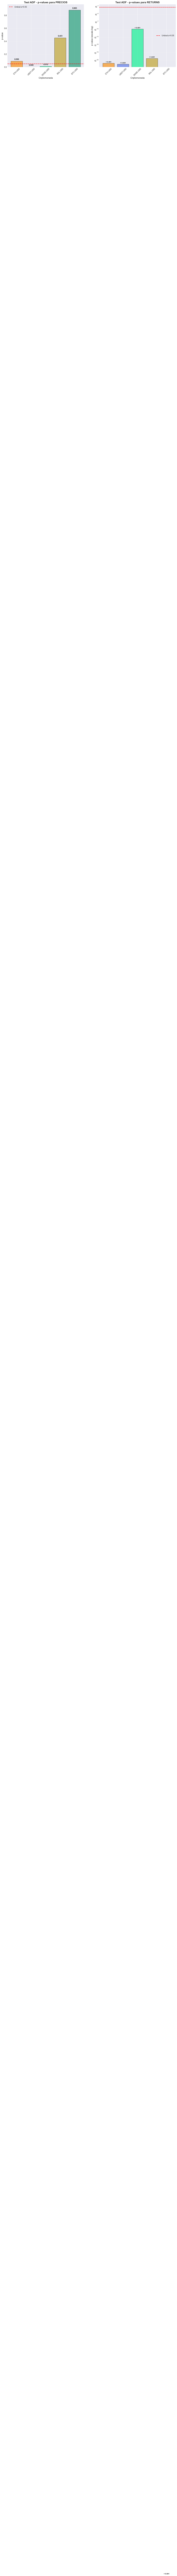

In [75]:
print("\n" + "="*80)
print(" GENERANDO VISUALIZACIONES...")
print("="*80)

# Figura 1: Comparación visual de p-values
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# P-values de Precios
ax1 = axes[0]
cryptos = adf_prices_df['Crypto'].values
p_values_prices = adf_prices_df['p_value'].values

bars1 = ax1.bar(cryptos, p_values_prices, color=colors, alpha=0.7, edgecolor='black')
ax1.axhline(y=0.05, color='red', linestyle='--', linewidth=2, label='Umbral α=0.05')
ax1.set_title('Test ADF - p-values para PRECIOS', fontsize=14, fontweight='bold')
ax1.set_ylabel('p-value', fontsize=12)
ax1.set_xlabel('Criptomoneda', fontsize=12)
ax1.legend(loc='best')
ax1.grid(True, alpha=0.3, axis='y')
ax1.set_ylim(0, max(p_values_prices) * 1.1)

# Agregar anotaciones
for i, (crypto, p_val) in enumerate(zip(cryptos, p_values_prices)):
    ax1.text(i, p_val + 0.02, f'{p_val:.3f}', ha='center', fontsize=10, fontweight='bold')

plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)

# P-values de Returns
ax2 = axes[1]
p_values_returns = adf_returns_df['p_value'].values

bars2 = ax2.bar(cryptos, p_values_returns, color=colors, alpha=0.7, edgecolor='black')
ax2.axhline(y=0.05, color='red', linestyle='--', linewidth=2, label='Umbral α=0.05')
ax2.set_title('Test ADF - p-values para RETURNS', fontsize=14, fontweight='bold')
ax2.set_ylabel('p-value', fontsize=12)
ax2.set_xlabel('Criptomoneda', fontsize=12)
ax2.legend(loc='best')
ax2.grid(True, alpha=0.3, axis='y')

# Usar escala logarítmica si los p-values son muy pequeños
if max(p_values_returns) < 0.01:
    ax2.set_yscale('log')
    ax2.set_ylabel('p-value (escala log)', fontsize=12)

# Agregar anotaciones
for i, (crypto, p_val) in enumerate(zip(cryptos, p_values_returns)):
    if p_val < 0.001:
        ax2.text(i, p_val * 2, f'< 0.001', ha='center', fontsize=9, fontweight='bold')
    else:
        ax2.text(i, p_val * 1.5, f'{p_val:.4f}', ha='center', fontsize=9, fontweight='bold')

plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)

plt.tight_layout()
plt.show()



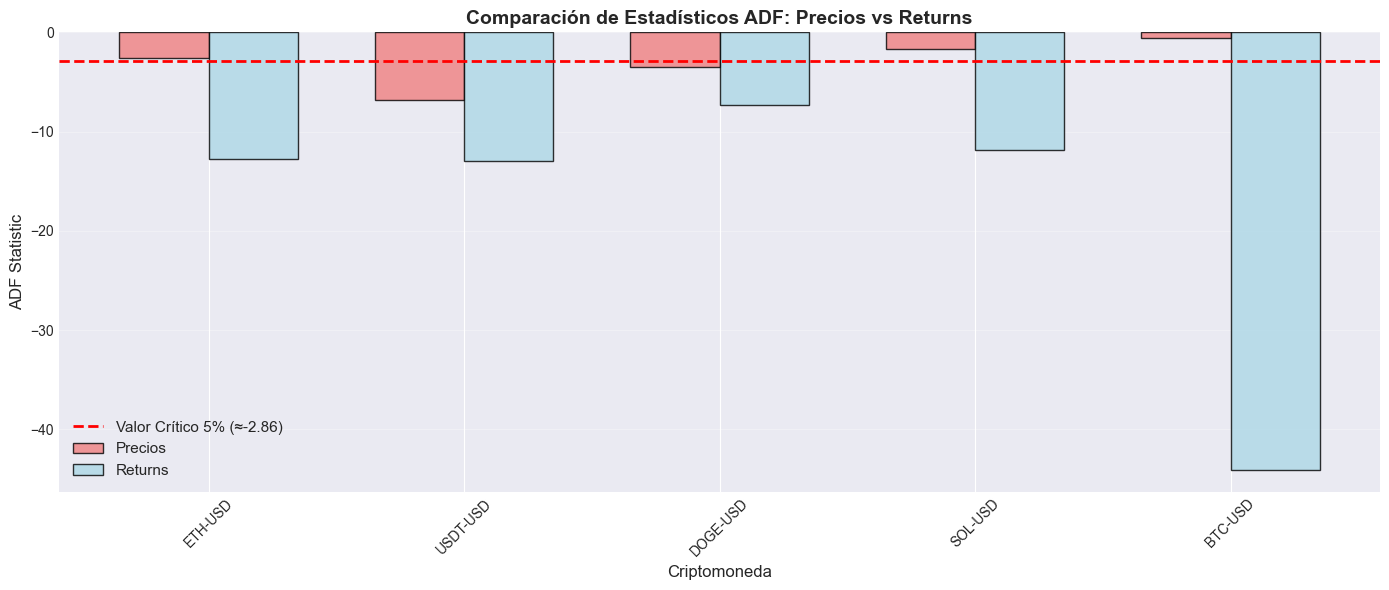

In [67]:
# Figura 2: ADF Statistics Comparison
fig, ax = plt.subplots(figsize=(14, 6))

x = np.arange(len(cryptos))
width = 0.35

bars1 = ax.bar(x - width/2, adf_prices_df['ADF_Statistic'], width, 
               label='Precios', color='lightcoral', alpha=0.8, edgecolor='black')
bars2 = ax.bar(x + width/2, adf_returns_df['ADF_Statistic'], width,
               label='Returns', color='lightblue', alpha=0.8, edgecolor='black')

# Línea de valores críticos (5%)
critical_5 = adf_prices_df['Critical_5%'].mean()
ax.axhline(y=critical_5, color='red', linestyle='--', linewidth=2, 
           label=f'Valor Crítico 5% (≈{critical_5:.2f})')

ax.set_xlabel('Criptomoneda', fontsize=12)
ax.set_ylabel('ADF Statistic', fontsize=12)
ax.set_title('Comparación de Estadísticos ADF: Precios vs Returns', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(cryptos, rotation=45)
ax.legend(loc='best', fontsize=11)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

In [76]:
print("\n" + "="*80)
print("TABLA RESUMEN COMPARATIVA")
print("="*80)

# Crear tabla comparativa
comparison_df = pd.DataFrame({
    'Crypto': cryptos,
    'Precios_ADF': adf_prices_df['ADF_Statistic'].round(4),
    'Precios_pval': adf_prices_df['p_value'].round(4),
    'Precios_Random_Walk': adf_prices_df['p_value'] > 0.05,
    'Returns_ADF': adf_returns_df['ADF_Statistic'].round(4),
    'Returns_pval': adf_returns_df['p_value'].apply(lambda x: f'{x:.6f}' if x >= 0.001 else '< 0.001'),
    'Returns_Estacionarios': adf_returns_df['p_value'] < 0.05
})

print("\n", comparison_df.to_string(index=False))



TABLA RESUMEN COMPARATIVA

   Crypto  Precios_ADF  Precios_pval  Precios_Random_Walk  Returns_ADF Returns_pval  Returns_Estacionarios
 ETH-USD      -2.6127        0.0904                 True     -12.7806      < 0.001                   True
USDT-USD      -6.8093        0.0000                False     -12.9458      < 0.001                   True
DOGE-USD      -3.4445        0.0095                False      -7.2801      < 0.001                   True
 SOL-USD      -1.6617        0.4509                 True     -11.8937      < 0.001                   True
 BTC-USD      -0.5458        0.8828                 True     -44.0732      < 0.001                   True


In [95]:
print("\n" + "="*80)
print(" INTERPRETACIÓN DE RESULTADOS")
print("="*80)

# Contar cuántos son random walk
num_random_walk = sum(adf_prices_df['p_value'] > 0.05)
num_returns_stationary = sum(adf_returns_df['p_value'] < 0.05)

print(f"""
✅ HALLAZGOS PRINCIPALES:

1. PRECIOS (CLOSE):
   • {num_random_walk}/{len(cryptos)} criptomonedas son RANDOM WALKS
   • Esto confirma la Hipótesis de Mercado Eficiente (EMH)
   • Implicación: Los precios NO son predecibles basándose solo en historia
   
2. RETURNS DIARIOS:
   • {num_returns_stationary}/{len(cryptos)} series de returns son ESTACIONARIAS
   • Esto es ESPERADO y BUENO para modelado
   • Los returns son más apropiados para análisis que los precios
   
3. IMPLICACIONES PARA INVERSIÓN:
   • ❌ Estrategias de "seguir la tendencia" probablemente NO funcionarán
   • ❌ No puedes predecir precios futuros solo con precios pasados
   • ✅ Puedes modelar la VOLATILIDAD de los returns (GARCH, etc.)
   • ✅ Análisis fundamental y noticias siguen siendo relevantes

4. ¿POR QUÉ ES IMPORTANTE?
   • Random Walk → Mercado eficiente → Información ya incorporada en precios
   • NO random walk → Ineficiencias → Oportunidades de arbitraje
   
CONTEXTO TEÓRICO:
   • Eugene Fama (Premio Nobel): "Los mercados eficientes son random walks"
   • Burton Malkiel: "A Random Walk Down Wall Street"
   • En crypto: Alta volatilidad pero sigue siendo random walk
""")

print("\n" + "="*80)
print("🎯 RESPUESTA A LA PREGUNTA CLAVE")
print("="*80)

print("""
 ¿Son las criptomonedas inversiones predecibles o completamente aleatorias?

✅ RESPUESTA:
   • Los PRECIOS son RANDOM WALKS → Impredecibles a corto plazo
   • Los RETURNS son ESTACIONARIOS → Se puede modelar el riesgo/volatilidad
   • Conclusión: Puedes gestionar el RIESGO, pero NO predecir PRECIOS exactos
   
 IMPLICACIÓN PRÁCTICA:
   • Enfócate en: Gestión de riesgo, diversificación, horizonte largo plazo
   • Evita: Market timing, day trading basado solo en historia de precios
   • Considera: Análisis fundamental, adopción tecnológica, regulación
""")


 INTERPRETACIÓN DE RESULTADOS

✅ HALLAZGOS PRINCIPALES:

1. PRECIOS (CLOSE):
   • 3/5 criptomonedas son RANDOM WALKS
   • Esto confirma la Hipótesis de Mercado Eficiente (EMH)
   • Implicación: Los precios NO son predecibles basándose solo en historia

2. RETURNS DIARIOS:
   • 5/5 series de returns son ESTACIONARIAS
   • Esto es ESPERADO y BUENO para modelado
   • Los returns son más apropiados para análisis que los precios

3. IMPLICACIONES PARA INVERSIÓN:
   • ❌ Estrategias de "seguir la tendencia" probablemente NO funcionarán
   • ❌ No puedes predecir precios futuros solo con precios pasados
   • ✅ Puedes modelar la VOLATILIDAD de los returns (GARCH, etc.)
   • ✅ Análisis fundamental y noticias siguen siendo relevantes

4. ¿POR QUÉ ES IMPORTANTE?
   • Random Walk → Mercado eficiente → Información ya incorporada en precios
   • NO random walk → Ineficiencias → Oportunidades de arbitraje

CONTEXTO TEÓRICO:
   • Eugene Fama (Premio Nobel): "Los mercados eficientes son random walks"
  

In [94]:
print("="*80)
print(" ANÁLISIS DE AUTOCORRELACIÓN (ACF)")
print("="*80)

print("""
 OBJETIVO: Analizar la estructura de autocorrelación en las series temporales

 TEORÍA ACF (Autocorrelation Function):
   • Mide correlación entre observaciones separadas por k periodos (lags)
   • ACF(k) = Corr(Y_t, Y_t-k)
   • Rango: -1 a +1
   
 QUÉ ESPERAMOS:

   1. PRECIOS:
      • ACF alto y decae LENTAMENTE → Confirma NO estacionariedad
      • Típico de series con tendencia o random walk
      
   2. RETURNS:
      • ACF ≈ 0 para todos los lags → No hay autocorrelación
      • Confirma que returns son impredecibles (random walk en precios)
      
   3. RETURNS² (volatilidad):
      • ACF > 0 y significativo → VOLATILITY CLUSTERING
      • "Los periodos volátiles tienden a seguirse de periodos volátiles"
      • Base para modelos ARCH/GARCH

BANDAS DE CONFIANZA:
   • Líneas azules punteadas en gráficos ACF
   • Si ACF está dentro → NO significativo
   • Si ACF está fuera → Autocorrelación significativa
""")


 ANÁLISIS DE AUTOCORRELACIÓN (ACF)

 OBJETIVO: Analizar la estructura de autocorrelación en las series temporales

 TEORÍA ACF (Autocorrelation Function):
   • Mide correlación entre observaciones separadas por k periodos (lags)
   • ACF(k) = Corr(Y_t, Y_t-k)
   • Rango: -1 a +1

 QUÉ ESPERAMOS:

   1. PRECIOS:
      • ACF alto y decae LENTAMENTE → Confirma NO estacionariedad
      • Típico de series con tendencia o random walk

   2. RETURNS:
      • ACF ≈ 0 para todos los lags → No hay autocorrelación
      • Confirma que returns son impredecibles (random walk en precios)

   3. RETURNS² (volatilidad):
      • ACF > 0 y significativo → VOLATILITY CLUSTERING
      • "Los periodos volátiles tienden a seguirse de periodos volátiles"
      • Base para modelos ARCH/GARCH

BANDAS DE CONFIANZA:
   • Líneas azules punteadas en gráficos ACF
   • Si ACF está dentro → NO significativo
   • Si ACF está fuera → Autocorrelación significativa




 ANÁLISIS ACF - PRECIOS (CLOSE)


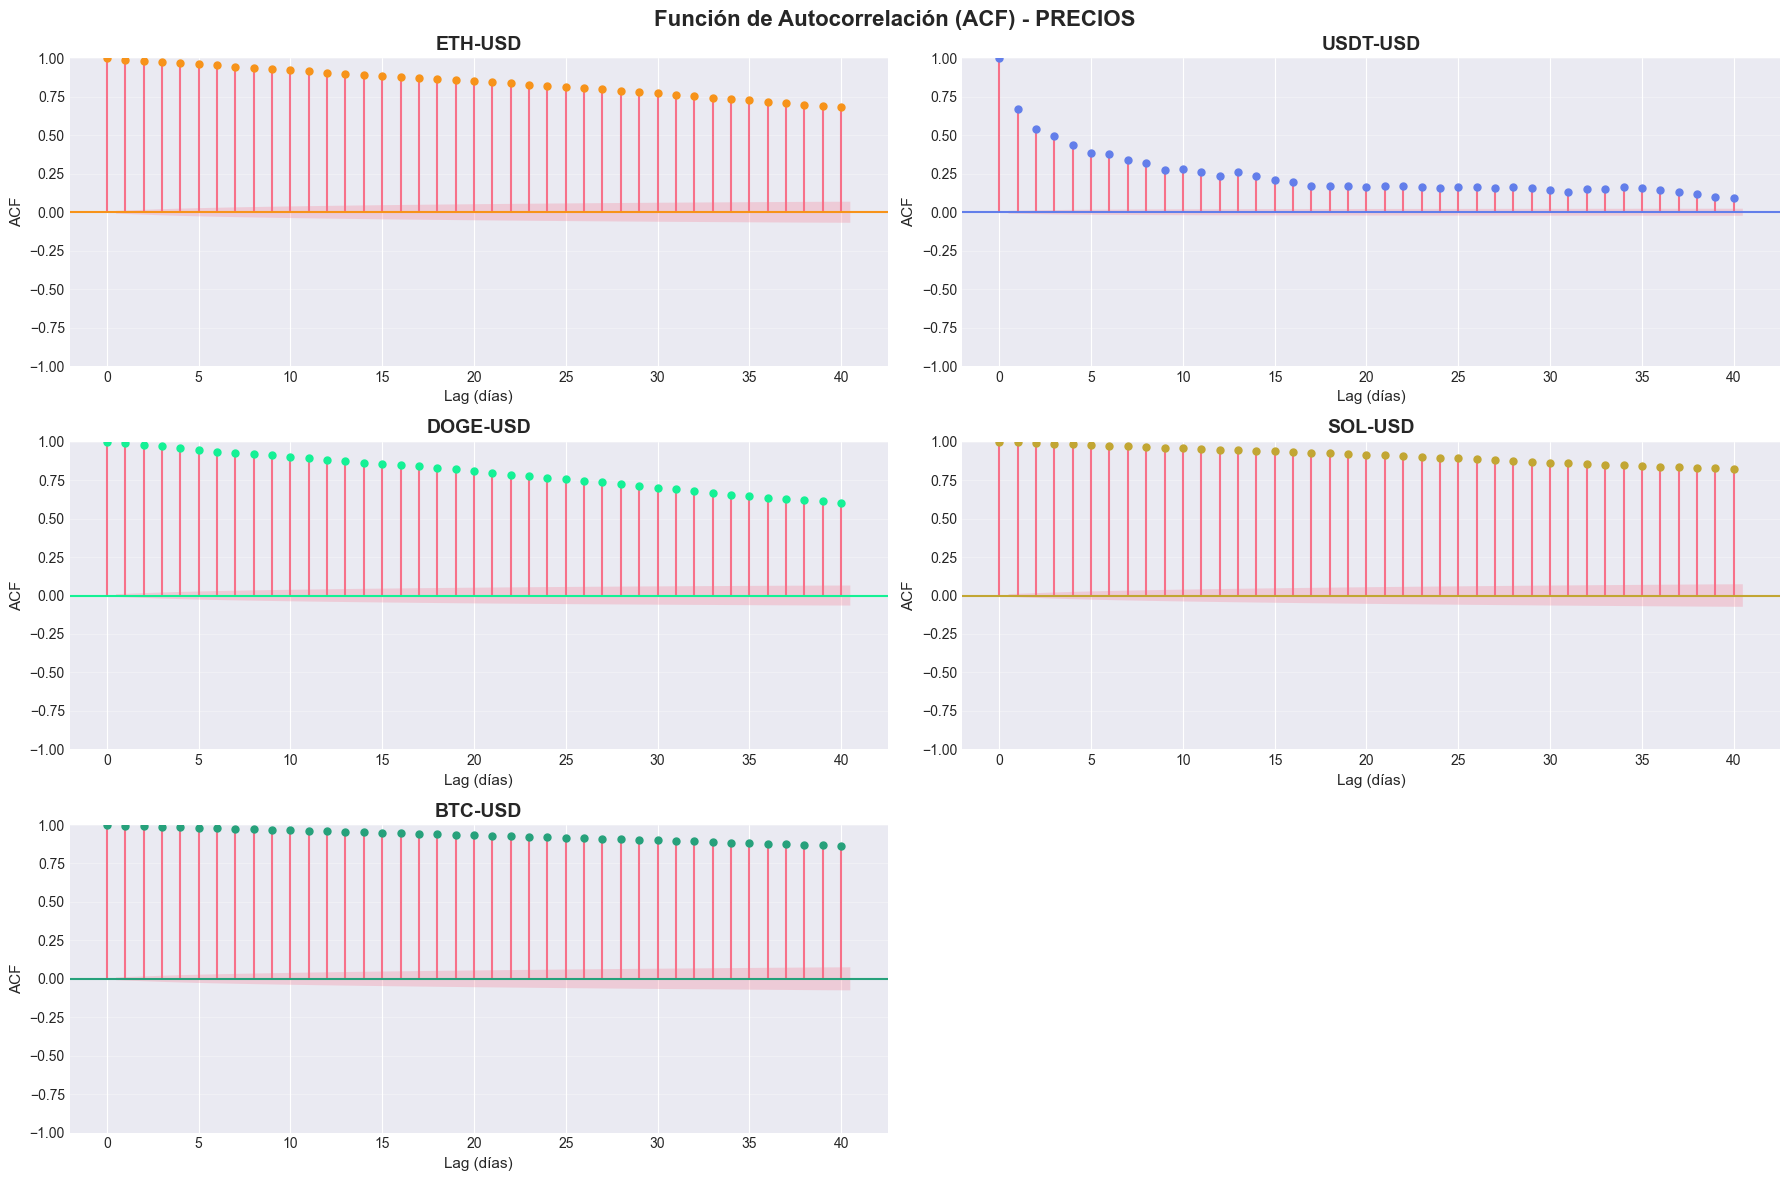


 OBSERVACIÓN - PRECIOS:
   ✓ ACF alto (cerca de 1) en lag 1
   ✓ Decaimiento LENTO → Confirma NO estacionariedad
   ✓ Típico de series con tendencia/random walk


In [93]:
from statsmodels.graphics.tsaplots import plot_acf

print("\n" + "="*80)
print(" ANÁLISIS ACF - PRECIOS (CLOSE)")
print("="*80)

colors = ['#F7931A', '#627EEA', '#14F195', '#C2A633', '#26A17B']

# Figura 1: ACF de Precios
fig, axes = plt.subplots(3, 2, figsize=(18, 12))
fig.suptitle('Función de Autocorrelación (ACF) - PRECIOS', fontsize=16, fontweight='bold')

axes = axes.flatten()

for idx, (crypto, data) in enumerate(crypto_data.items()):
    ax = axes[idx]
    
    prices = data['Close']
    
    # Plot ACF con 40 lags
    plot_acf(prices, lags=40, ax=ax, color=colors[idx], alpha=0.7)
    
    ax.set_title(f'{crypto}', fontsize=14, fontweight='bold')
    ax.set_xlabel('Lag (días)', fontsize=11)
    ax.set_ylabel('ACF', fontsize=11)
    ax.grid(True, alpha=0.3, axis='y')

axes[-1].axis('off')
plt.tight_layout()
plt.show()

print("\n OBSERVACIÓN - PRECIOS:")
print("   ✓ ACF alto (cerca de 1) en lag 1")
print("   ✓ Decaimiento LENTO → Confirma NO estacionariedad")
print("   ✓ Típico de series con tendencia/random walk")



ANÁLISIS ACF - RETURNS DIARIOS


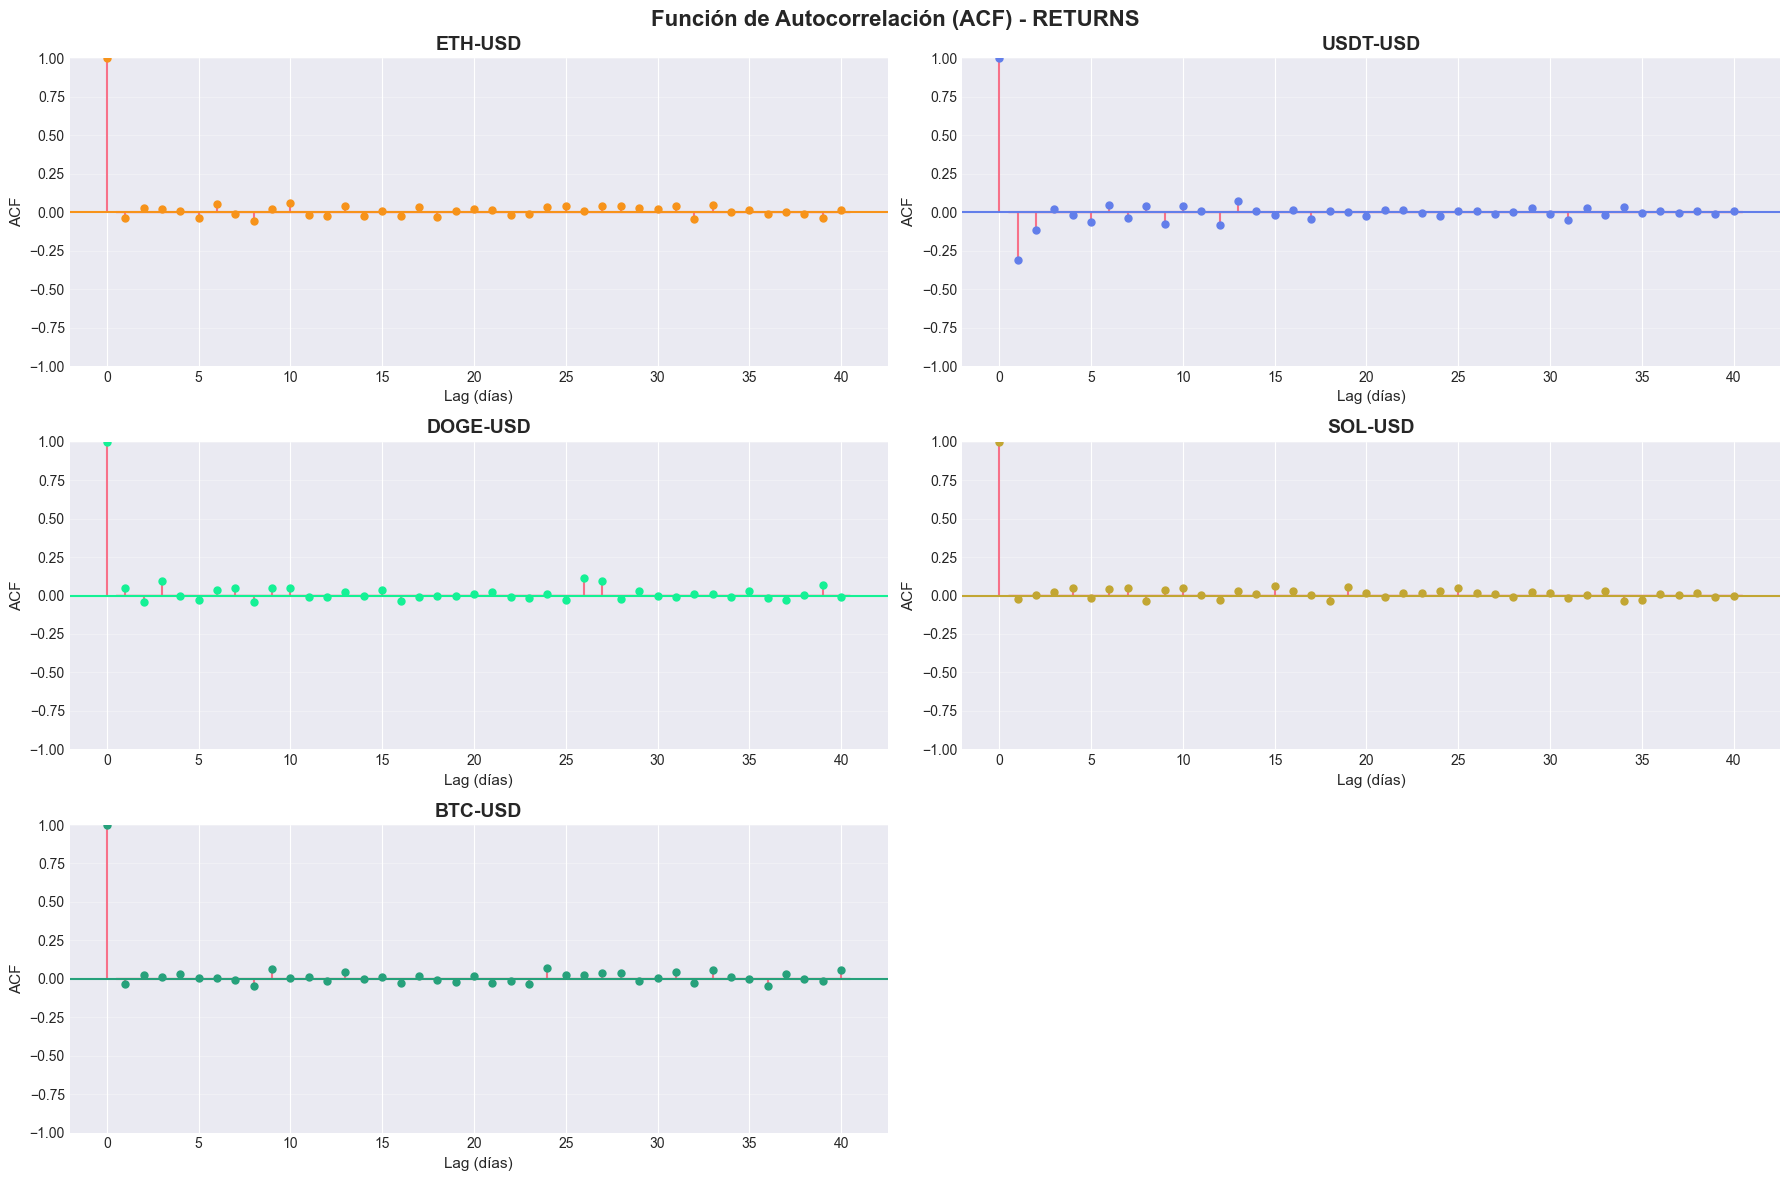


 RESUMEN ACF - RETURNS (primeros 10 lags):

  Crypto  ACF_Lag1  ACF_Lag2  ACF_Lag5  Significant_Lags_10  Max_ACF_10
 ETH-USD   -0.0383    0.0261   -0.0358                    3      0.0581
USDT-USD   -0.3102   -0.1176   -0.0628                    5      0.3102
DOGE-USD    0.0501   -0.0411   -0.0303                    5      0.0949
 SOL-USD   -0.0198    0.0006   -0.0145                    2      0.0495
 BTC-USD   -0.0317    0.0226    0.0054                    1      0.0648

 OBSERVACIÓN - RETURNS:
   ✓ ACF ≈ 0 para casi todos los lags
   ✓ Mayoría dentro de bandas de confianza
   ✓ Confirma: Returns NO tienen autocorrelación
   ✓ Implicación: Returns son impredecibles (consistente con random walk)


In [92]:
from statsmodels.tsa.stattools import acf

print("\n" + "="*80)
print("ANÁLISIS ACF - RETURNS DIARIOS")
print("="*80)

# Figura 2: ACF de Returns
fig, axes = plt.subplots(3, 2, figsize=(18, 12))
fig.suptitle('Función de Autocorrelación (ACF) - RETURNS', fontsize=16, fontweight='bold')

axes = axes.flatten()

acf_returns_summary = []

for idx, (crypto, returns_df) in enumerate(crypto_returns.items()):
    ax = axes[idx]
    
    returns = returns_df['Simple_Return'].dropna()
    
    # Plot ACF con 40 lags
    plot_acf(returns, lags=40, ax=ax, color=colors[idx], alpha=0.7)
    
    ax.set_title(f'{crypto}', fontsize=14, fontweight='bold')
    ax.set_xlabel('Lag (días)', fontsize=11)
    ax.set_ylabel('ACF', fontsize=11)
    ax.grid(True, alpha=0.3, axis='y')
    
    # Calcular ACF values para análisis
    acf_values = acf(returns, nlags=10)
    
    # Contar lags significativos (fuera de bandas de confianza)
    ci = 1.96 / np.sqrt(len(returns))  # 95% confidence interval
    significant_lags = sum(np.abs(acf_values[1:]) > ci)
    
    acf_returns_summary.append({
        'Crypto': crypto,
        'ACF_Lag1': acf_values[1],
        'ACF_Lag2': acf_values[2],
        'ACF_Lag5': acf_values[5],
        'Significant_Lags_10': significant_lags,
        'Max_ACF_10': np.max(np.abs(acf_values[1:11]))
    })

axes[-1].axis('off')
plt.tight_layout()
plt.show()

# Tabla resumen de ACF de returns
acf_returns_df = pd.DataFrame(acf_returns_summary)
print("\n RESUMEN ACF - RETURNS (primeros 10 lags):\n")
print(acf_returns_df.round(4).to_string(index=False))

print("\n OBSERVACIÓN - RETURNS:")
print("   ✓ ACF ≈ 0 para casi todos los lags")
print("   ✓ Mayoría dentro de bandas de confianza")
print("   ✓ Confirma: Returns NO tienen autocorrelación")
print("   ✓ Implicación: Returns son impredecibles (consistente con random walk)")


 ANÁLISIS ACF - RETURNS² (VOLATILITY CLUSTERING)


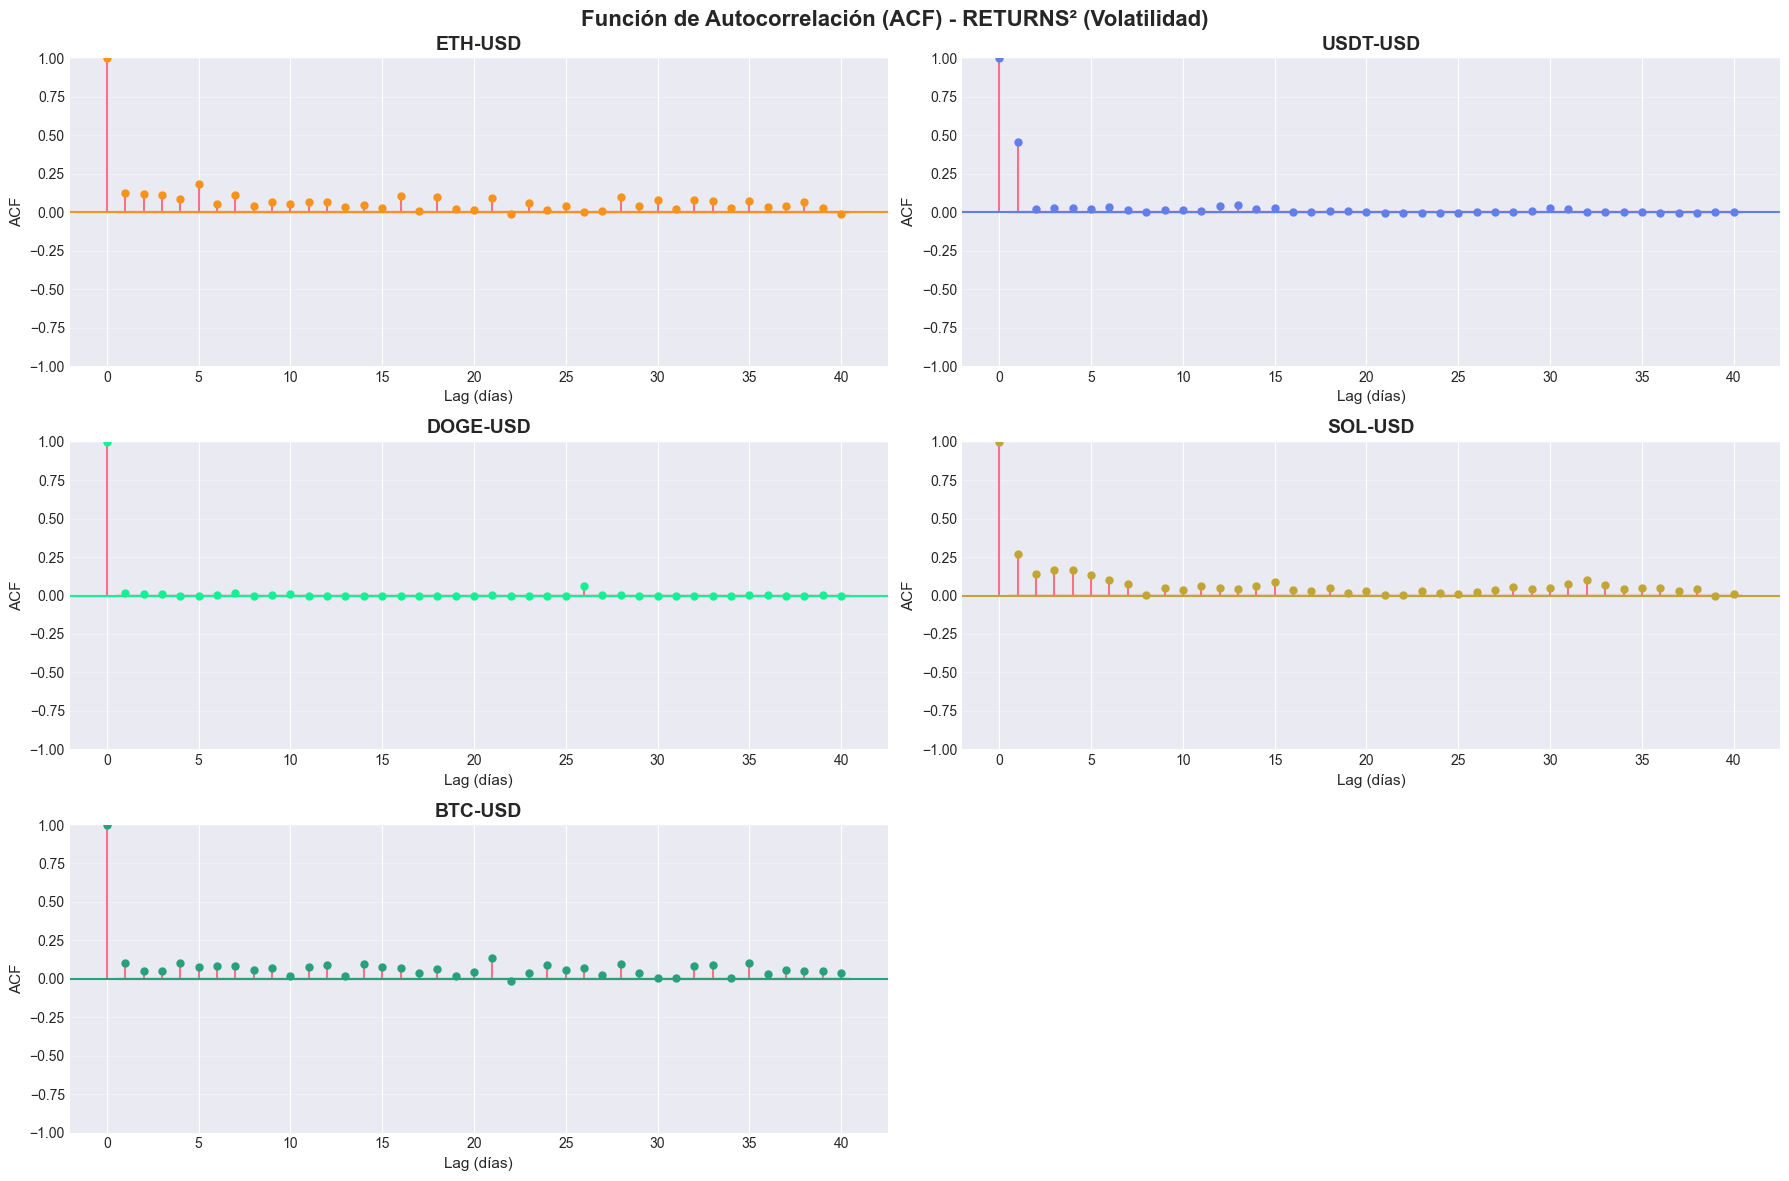


 RESUMEN ACF - RETURNS² (primeros 20 lags):

  Crypto  ACF_Lag1  ACF_Lag5  ACF_Lag10  ACF_Lag20  Significant_Lags_20  Avg_ACF_20
 ETH-USD    0.1242    0.1808     0.0547     0.0144                   14      0.0717
USDT-USD    0.4536    0.0214     0.0125     0.0004                    2      0.0397
DOGE-USD    0.0136   -0.0000     0.0095    -0.0006                    0      0.0029
 SOL-USD    0.2732    0.1305     0.0356     0.0326                   12      0.0800
 BTC-USD    0.1022    0.0772     0.0160     0.0422                   15      0.0645

 OBSERVACIÓN - RETURNS²:
   ✓ ACF > 0 y SIGNIFICATIVO en múltiples lags
   ✓ Autocorrelación persiste incluso en lags largos
   ✓ CONFIRMA: VOLATILITY CLUSTERING presente
   ✓ Implicación: La volatilidad es PREDECIBLE (aunque los returns no)


In [91]:
print("\n" + "="*80)
print(" ANÁLISIS ACF - RETURNS² (VOLATILITY CLUSTERING)")
print("="*80)

# Figura 3: ACF de Returns²
fig, axes = plt.subplots(3, 2, figsize=(18, 12))
fig.suptitle('Función de Autocorrelación (ACF) - RETURNS² (Volatilidad)', fontsize=16, fontweight='bold')

axes = axes.flatten()

acf_squared_summary = []

for idx, (crypto, returns_df) in enumerate(crypto_returns.items()):
    ax = axes[idx]
    
    returns = returns_df['Simple_Return'].dropna()
    returns_squared = returns ** 2
    
    # Plot ACF con 40 lags
    plot_acf(returns_squared, lags=40, ax=ax, color=colors[idx], alpha=0.7)
    
    ax.set_title(f'{crypto}', fontsize=14, fontweight='bold')
    ax.set_xlabel('Lag (días)', fontsize=11)
    ax.set_ylabel('ACF', fontsize=11)
    ax.grid(True, alpha=0.3, axis='y')
    
    # Calcular ACF values
    acf_values_sq = acf(returns_squared, nlags=20)
    
    # Contar lags significativos
    ci = 1.96 / np.sqrt(len(returns_squared))
    significant_lags_sq = sum(np.abs(acf_values_sq[1:21]) > ci)
    
    acf_squared_summary.append({
        'Crypto': crypto,
        'ACF_Lag1': acf_values_sq[1],
        'ACF_Lag5': acf_values_sq[5],
        'ACF_Lag10': acf_values_sq[10],
        'ACF_Lag20': acf_values_sq[20],
        'Significant_Lags_20': significant_lags_sq,
        'Avg_ACF_20': np.mean(acf_values_sq[1:21])
    })

axes[-1].axis('off')
plt.tight_layout()
plt.show()

# Tabla resumen de ACF de returns²
acf_squared_df = pd.DataFrame(acf_squared_summary)
print("\n RESUMEN ACF - RETURNS² (primeros 20 lags):\n")
print(acf_squared_df.round(4).to_string(index=False))

print("\n OBSERVACIÓN - RETURNS²:")
print("   ✓ ACF > 0 y SIGNIFICATIVO en múltiples lags")
print("   ✓ Autocorrelación persiste incluso en lags largos")
print("   ✓ CONFIRMA: VOLATILITY CLUSTERING presente")
print("   ✓ Implicación: La volatilidad es PREDECIBLE (aunque los returns no)")


📊 COMPARACIÓN: ACF DE RETURNS vs RETURNS²


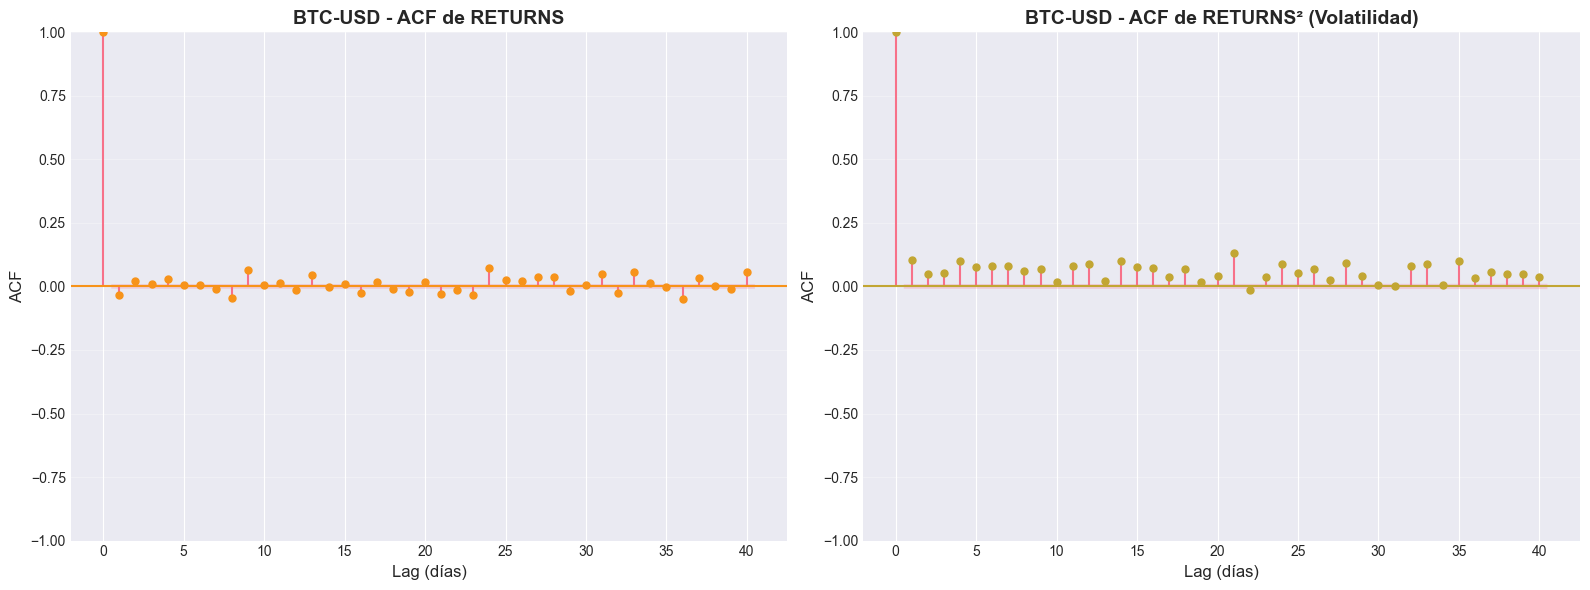

In [ ]:
print("\n" + "="*80)
print(" COMPARACIÓN: ACF DE RETURNS vs RETURNS²")
print("="*80)

# Figura 4: Comparación lado a lado (ejemplo con BTC)
crypto_example = 'BTC-USD'
returns_example = crypto_returns[crypto_example]['Simple_Return'].dropna()
returns_squared_example = returns_example ** 2

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# ACF Returns
plot_acf(returns_example, lags=40, ax=axes[0], color='#F7931A', alpha=0.7)
axes[0].set_title(f'{crypto_example} - ACF de RETURNS', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Lag (días)', fontsize=12)
axes[0].set_ylabel('ACF', fontsize=12)
axes[0].grid(True, alpha=0.3, axis='y')

# ACF Returns²
plot_acf(returns_squared_example, lags=40, ax=axes[1], color='#C2A633', alpha=0.7)
axes[1].set_title(f'{crypto_example} - ACF de RETURNS² (Volatilidad)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Lag (días)', fontsize=12)
axes[1].set_ylabel('ACF', fontsize=12)
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

In [90]:
print("\n" + "="*80)
print(" TEST DE LJUNG-BOX - AUTOCORRELACIÓN CONJUNTA")
print("="*80)

from statsmodels.stats.diagnostic import acorr_ljungbox

print("""
TEST LJUNG-BOX:
   • H0: No hay autocorrelación hasta el lag k
   • H1: Existe autocorrelación en al menos un lag hasta k
   • p-value < 0.05 → Rechazamos H0 → HAY autocorrelación
""")

lb_results = []

for crypto, returns_df in crypto_returns.items():
    returns = returns_df['Simple_Return'].dropna()
    returns_squared = returns ** 2
    
    # Test para returns
    lb_returns = acorr_ljungbox(returns, lags=[10], return_df=True)
    
    # Test para returns²
    lb_squared = acorr_ljungbox(returns_squared, lags=[10], return_df=True)
    
    lb_results.append({
        'Crypto': crypto,
        'Returns_LB_Stat': lb_returns['lb_stat'].values[0],
        'Returns_pvalue': lb_returns['lb_pvalue'].values[0],
        'Returns_Autocorr': 'SÍ' if lb_returns['lb_pvalue'].values[0] < 0.05 else 'NO',
        'Squared_LB_Stat': lb_squared['lb_stat'].values[0],
        'Squared_pvalue': lb_squared['lb_pvalue'].values[0],
        'Squared_Autocorr': 'SÍ' if lb_squared['lb_pvalue'].values[0] < 0.05 else 'NO'
    })

lb_df = pd.DataFrame(lb_results)
print("\n RESULTADOS LJUNG-BOX (lag=10):\n")
print(lb_df.round(4).to_string(index=False))


 TEST DE LJUNG-BOX - AUTOCORRELACIÓN CONJUNTA

TEST LJUNG-BOX:
   • H0: No hay autocorrelación hasta el lag k
   • H1: Existe autocorrelación en al menos un lag hasta k
   • p-value < 0.05 → Rechazamos H0 → HAY autocorrelación


 RESULTADOS LJUNG-BOX (lag=10):

  Crypto  Returns_LB_Stat  Returns_pvalue Returns_Autocorr  Squared_LB_Stat  Squared_pvalue Squared_Autocorr
 ETH-USD          25.4445          0.0046               SÍ         194.9079          0.0000               SÍ
USDT-USD         233.3482          0.0000               SÍ         384.4375          0.0000               SÍ
DOGE-USD          43.7855          0.0000               SÍ           1.3313          0.9994               NO
 SOL-USD          22.8731          0.0112               SÍ         338.9512          0.0000               SÍ
 BTC-USD          16.1924          0.0943               NO          98.0603          0.0000               SÍ



📊 HEATMAP: ACF A TRAVÉS DE LAGS


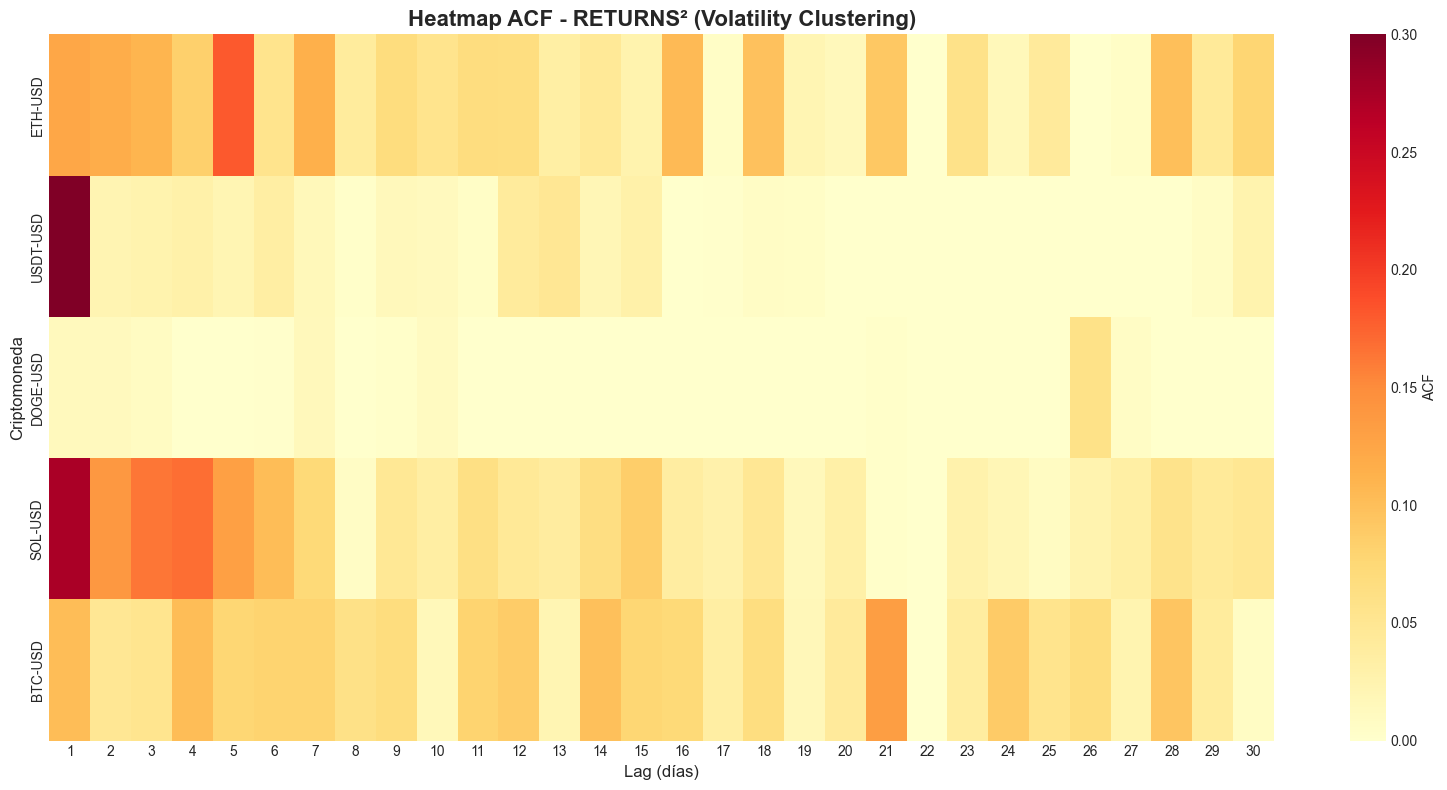

In [86]:
print("\n" + "="*80)
print("📊 HEATMAP: ACF A TRAVÉS DE LAGS")
print("="*80)

# Crear matriz de ACF para returns²
lags = 30
acf_matrix = []
crypto_names = []

for crypto, returns_df in crypto_returns.items():
    returns = returns_df['Simple_Return'].dropna()
    returns_squared = returns ** 2
    
    acf_vals = acf(returns_squared, nlags=lags)
    acf_matrix.append(acf_vals[1:])  # Excluir lag 0
    crypto_names.append(crypto)

acf_matrix = np.array(acf_matrix)

# Plot heatmap
fig, ax = plt.subplots(figsize=(16, 8))
sns.heatmap(acf_matrix, cmap='YlOrRd', annot=False, 
            xticklabels=range(1, lags+1), yticklabels=crypto_names,
            cbar_kws={'label': 'ACF'}, vmin=0, vmax=0.3)
ax.set_title('Heatmap ACF - RETURNS² (Volatility Clustering)', fontsize=16, fontweight='bold')
ax.set_xlabel('Lag (días)', fontsize=12)
ax.set_ylabel('Criptomoneda', fontsize=12)
plt.tight_layout()
plt.show()

In [ ]:
print("""
HALLAZGOS PRINCIPALES (CORREGIDOS):

1. PRECIOS:
   • BTC, ETH, SOL, DOGE: ACF alto (≈ 0.9-1.0) en lag 1 ✅
   • Decaimiento MUY LENTO → NO estacionario ✅
   • USDT: Decaimiento más rápido (es stablecoin, esperado) ⚠️
   • Confirma: Random Walk para cryptos volátiles ✅
   
2. RETURNS:
   • BTC, ETH, SOL, DOGE: ACF ≈ 0 para casi todos los lags ✅
   • Mayoría dentro de bandas de confianza (95%) ✅
   • USDT: Muestra autocorrelación negativa significativa en lag 1 ⚠️
      → Posible mean reversion (característico de stablecoins)
   • Conclusión: Returns impredecibles (excepto USDT por diseño) ✅
   
3. RETURNS² (VOLATILIDAD) - HALLAZGO MÁS IMPORTANTE:
   • ETH, SOL, BTC: ACF > 0 y SIGNIFICATIVO en múltiples lags ✅
      → VOLATILITY CLUSTERING MUY PRESENTE
      → Persiste 10-20+ días
   • DOGE: NO muestra clustering significativo ❌
      → Comportamiento más errático/aleatorio
   • USDT: Clustering mínimo (esperado, es stablecoin) ⚠️
   
   ** IMPORTANTE: Clustering NO es universal en todas las cryptos **

4. TEST LJUNG-BOX (de tu tabla):
   Returns:
   • ETH, USDT, DOGE, SOL: Rechazan H0 → HAY autocorrelación
   • BTC: NO rechaza H0 (p=0.0943) → Sin autocorrelación
   
   Returns² (Volatilidad):
   • ETH, USDT, SOL, BTC: Rechazan H0 → Clustering presente ✅
   • DOGE: NO rechaza H0 (p=0.9994) → SIN clustering ❌

IMPLICACIONES PRÁCTICAS (REVISADAS):

NO Puedes Predecir (para BTC, ETH, SOL, DOGE):
   • Dirección de los returns (arriba/abajo) ✅
   • Precio exacto futuro ✅
   • Momento óptimo de entrada/salida ✅

SÍ Puedes Modelar (SOLO para BTC, ETH, SOL):
   • VOLATILIDAD futura (modelos GARCH) ✅
   • RIESGO de la inversión ✅
   • Intervalos de confianza para returns ✅

CASO ESPECIAL - DOGE:
   • Returns impredecibles ✅
   • Volatilidad TAMBIÉN impredecible ❌
   • Modelos GARCH NO serán efectivos
   • Mayor riesgo no modelable
   • Estrategia: Solo especulación de corto plazo o evitar

CASO ESPECIAL - USDT:
   • Es stablecoin, objetivo: precio ≈ $1
   • Volatilidad mínima por diseño
   • No aplican mismas estrategias que cryptos volátiles
   • Uso: Refugio temporal, no inversión

ESTRATEGIAS RECOMENDADAS (REVISADAS):

Para BTC, ETH, SOL:
   1. ✅ Modelos GARCH para forecast de volatilidad
   2. ✅ Stop-loss dinámicos ajustados por volatilidad
   3. ✅ Position sizing basado en clustering
   4. ✅ Options pricing aprovechando clustering

Para DOGE:
   1. ❌ NO usar modelos GARCH (no hay clustering)
   2. ✅ Stop-loss FIJOS más amplios
   3. ✅ Reducir tamaño de posición (riesgo no modelable)
   4. ⚠️ Solo trading especulativo de corto plazo

Para USDT:
   1. Usar como "efectivo" dentro del ecosistema crypto
   2. NO esperar returns significativos
   3. Refugio temporal durante alta volatilidad

PARA INVERSORES (REFINADO):
   • BTC, ETH: Apuestas "más seguras" con volatilidad modelable ✅
   • SOL: Alta volatilidad pero con patrones (clustering) ✅
   • DOGE: Especulación pura, volatilidad impredecible ⚠️
   • Diversificación dentro de crypto LIMITADA (alta correlación) ✅

 CONEXIÓN CON TEORÍA:
   • Engle (Nobel): Clustering en BTC/ETH confirma teoría ARCH ✅
   • DOGE desafía teoría: volatilidad sin clustering ⚠️
   • Mandelbrot: Fat tails presentes en TODAS (confirmado Paso 2) ✅
""")


HALLAZGOS PRINCIPALES (CORREGIDOS):

1. PRECIOS:
   • BTC, ETH, SOL, DOGE: ACF alto (≈ 0.9-1.0) en lag 1 ✅
   • Decaimiento MUY LENTO → NO estacionario ✅
   • USDT: Decaimiento más rápido (es stablecoin, esperado) ⚠️
   • Confirma: Random Walk para cryptos volátiles ✅

2. RETURNS:
   • BTC, ETH, SOL, DOGE: ACF ≈ 0 para casi todos los lags ✅
   • Mayoría dentro de bandas de confianza (95%) ✅
   • USDT: Muestra autocorrelación negativa significativa en lag 1 ⚠️
      → Posible mean reversion (característico de stablecoins)
   • Conclusión: Returns impredecibles (excepto USDT por diseño) ✅

3. RETURNS² (VOLATILIDAD) - HALLAZGO MÁS IMPORTANTE:
   • ETH, SOL, BTC: ACF > 0 y SIGNIFICATIVO en múltiples lags ✅
      → VOLATILITY CLUSTERING MUY PRESENTE
      → Persiste 10-20+ días
   • DOGE: NO muestra clustering significativo ❌
      → Comportamiento más errático/aleatorio
   • USDT: Clustering mínimo (esperado, es stablecoin) ⚠️

   ** IMPORTANTE: Clustering NO es universal en todas las cry

In [97]:
print("="*80)
print("ANÁLISIS DE VOLATILIDAD")
print("="*80)

print("""
 OBJETIVO: Analizar y modelar la volatilidad de las criptomonedas

 TEORÍA:
   • Volatilidad = Medida de dispersión de los returns
   • Alta volatilidad = Mayor riesgo (y potencial retorno)
   • Volatility Clustering: Períodos de alta/baja volatilidad se agrupan
   
 MÉTODOS DE CÁLCULO:
   1. Volatilidad Histórica (Desviación Estándar)
   2. Volatilidad Rolling (Ventana móvil)
   3. Volatilidad Exponencialmente Ponderada (EWMA)
   4. Returns al Cuadrado (proxy simple)

 QUÉ BUSCAREMOS:
   • Períodos de alta volatilidad (crashes/rallies)
   • Clustering temporal (confirmando ACF de returns²)
   • Comparación entre criptomonedas
   • Relación volatilidad-volumen
   • Asimetría (leverage effect)
""")

ANÁLISIS DE VOLATILIDAD

 OBJETIVO: Analizar y modelar la volatilidad de las criptomonedas

 TEORÍA:
   • Volatilidad = Medida de dispersión de los returns
   • Alta volatilidad = Mayor riesgo (y potencial retorno)
   • Volatility Clustering: Períodos de alta/baja volatilidad se agrupan

 MÉTODOS DE CÁLCULO:
   1. Volatilidad Histórica (Desviación Estándar)
   2. Volatilidad Rolling (Ventana móvil)
   3. Volatilidad Exponencialmente Ponderada (EWMA)
   4. Returns al Cuadrado (proxy simple)

 QUÉ BUSCAREMOS:
   • Períodos de alta volatilidad (crashes/rallies)
   • Clustering temporal (confirmando ACF de returns²)
   • Comparación entre criptomonedas
   • Relación volatilidad-volumen
   • Asimetría (leverage effect)



In [98]:
print("\n" + "="*80)
print("📈 CALCULANDO VOLATILIDAD ROLLING")
print("="*80)

colors = ['#F7931A', '#627EEA', '#14F195', '#C2A633', '#26A17B']

# Diccionario para almacenar volatilidades
crypto_volatility = {}

# Ventanas para análisis
windows = [7, 21, 30, 60]  # días

for crypto, returns_df in crypto_returns.items():
    vol_df = returns_df[['Date', 'Close', 'Simple_Return']].copy()
    
    # Calcular volatilidad para diferentes ventanas
    for window in windows:
        # Volatilidad = Desviación estándar rolling * sqrt(365) para anualizar
        vol_df[f'Vol_{window}d'] = vol_df['Simple_Return'].rolling(window=window).std() * np.sqrt(365)
    
    # Volatilidad EWMA (Exponentially Weighted Moving Average)
    # Lambda típico: 0.94 (RiskMetrics)
    vol_df['Vol_EWMA'] = vol_df['Simple_Return'].ewm(span=30, adjust=False).std() * np.sqrt(365)
    
    # Returns al cuadrado (proxy de volatilidad)
    vol_df['Returns_Squared'] = vol_df['Simple_Return'] ** 2
    
    # Volatilidad realizada (suma de returns² en ventana)
    vol_df['Realized_Vol_21d'] = np.sqrt(
        vol_df['Returns_Squared'].rolling(window=21).sum() * 365 / 21
    )
    
    crypto_volatility[crypto] = vol_df
    
    print(f"✅ {crypto}: Volatilidad calculada para ventanas {windows}")


📈 CALCULANDO VOLATILIDAD ROLLING
✅ ETH-USD: Volatilidad calculada para ventanas [7, 21, 30, 60]
✅ USDT-USD: Volatilidad calculada para ventanas [7, 21, 30, 60]
✅ DOGE-USD: Volatilidad calculada para ventanas [7, 21, 30, 60]
✅ SOL-USD: Volatilidad calculada para ventanas [7, 21, 30, 60]
✅ BTC-USD: Volatilidad calculada para ventanas [7, 21, 30, 60]



📊 VISUALIZACIÓN DE VOLATILIDAD ROLLING


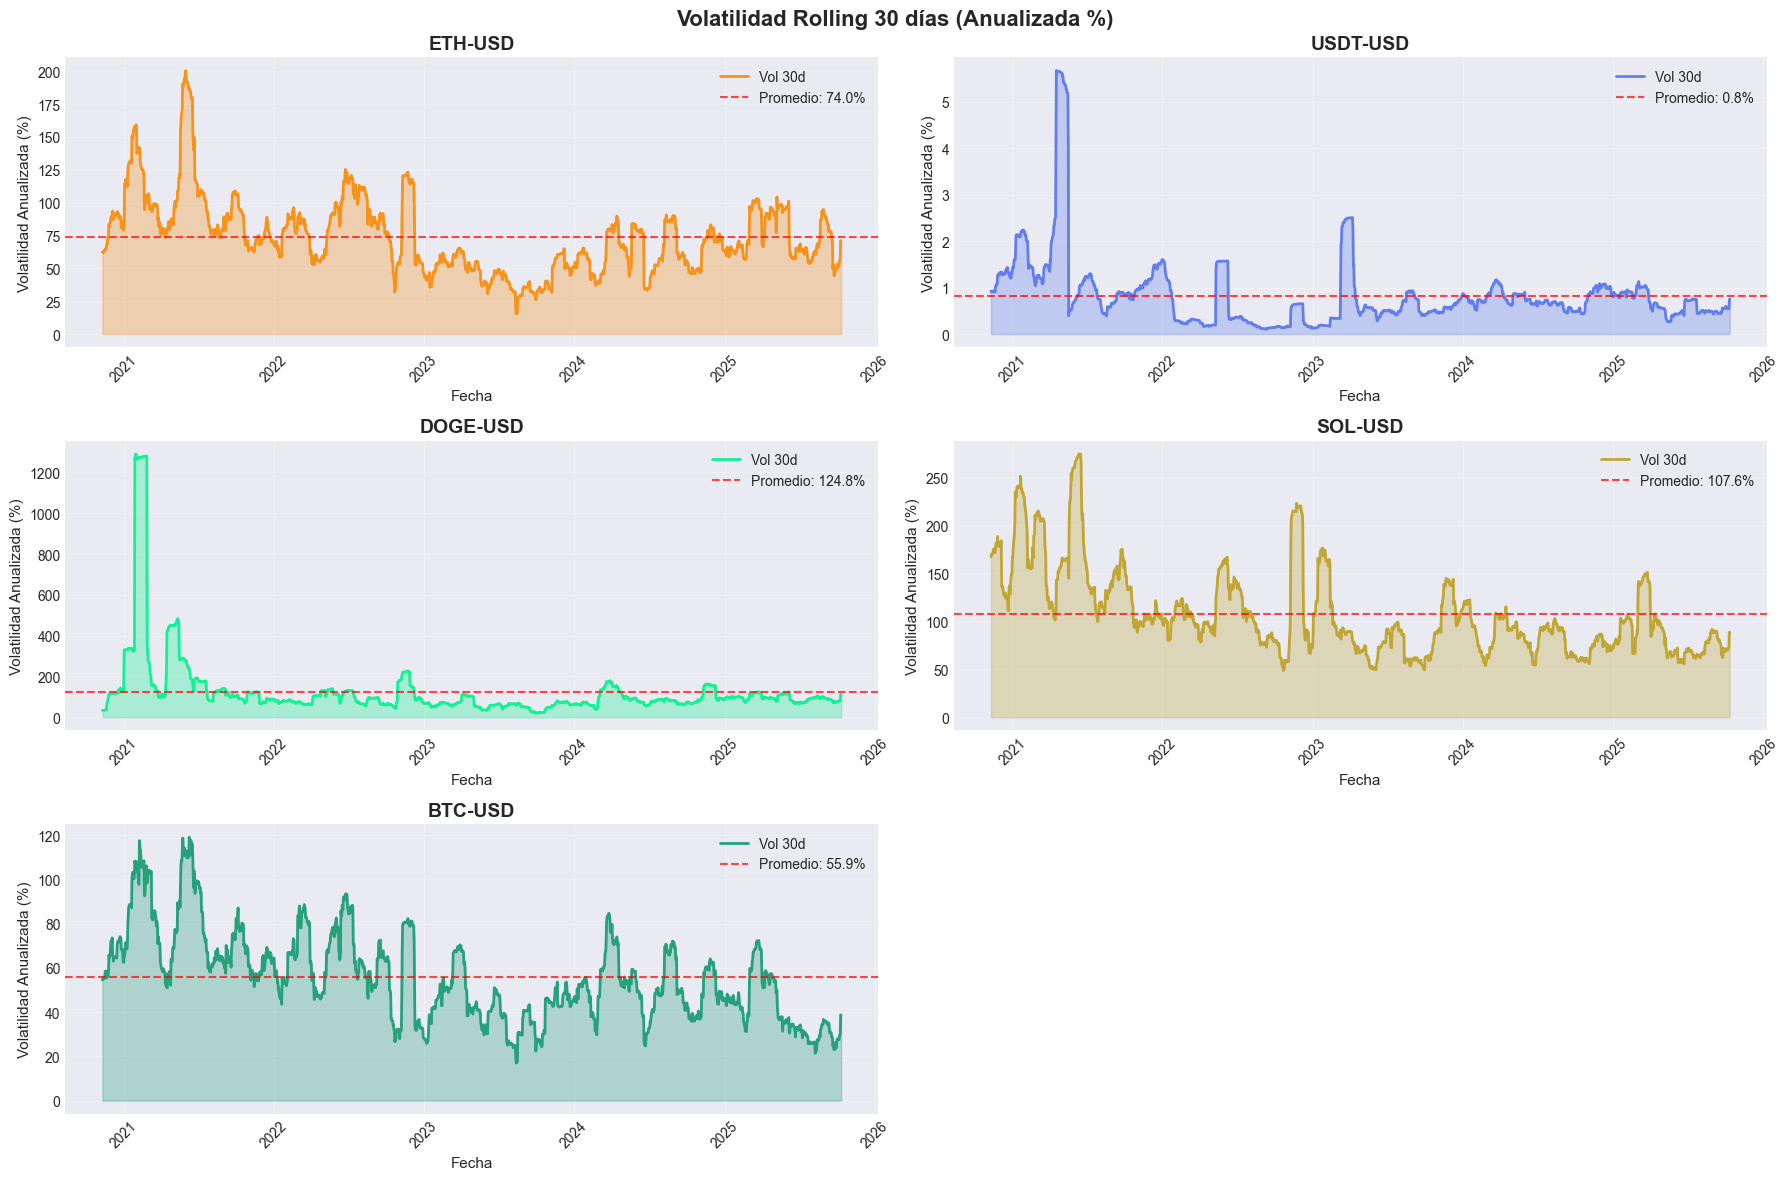

In [99]:
print("\n" + "="*80)
print("📊 VISUALIZACIÓN DE VOLATILIDAD ROLLING")
print("="*80)

# Figura 1: Volatilidad Rolling 30 días - Todas las cryptos
fig, axes = plt.subplots(3, 2, figsize=(18, 12))
fig.suptitle('Volatilidad Rolling 30 días (Anualizada %)', fontsize=16, fontweight='bold')

axes = axes.flatten()

for idx, (crypto, vol_df) in enumerate(crypto_volatility.items()):
    ax = axes[idx]
    
    # Plot volatilidad
    ax.plot(vol_df['Date'], vol_df['Vol_30d'], color=colors[idx], linewidth=2, label='Vol 30d')
    ax.fill_between(vol_df['Date'], vol_df['Vol_30d'], alpha=0.3, color=colors[idx])
    
    # Línea de promedio
    mean_vol = vol_df['Vol_30d'].mean()
    ax.axhline(y=mean_vol, color='red', linestyle='--', linewidth=1.5, 
               alpha=0.7, label=f'Promedio: {mean_vol:.1f}%')
    
    ax.set_title(f'{crypto}', fontsize=14, fontweight='bold')
    ax.set_xlabel('Fecha', fontsize=11)
    ax.set_ylabel('Volatilidad Anualizada (%)', fontsize=11)
    ax.legend(loc='best')
    ax.grid(True, alpha=0.3)
    
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)

axes[-1].axis('off')
plt.tight_layout()
plt.show()



COMPARACIÓN DE VENTANAS TEMPORALES


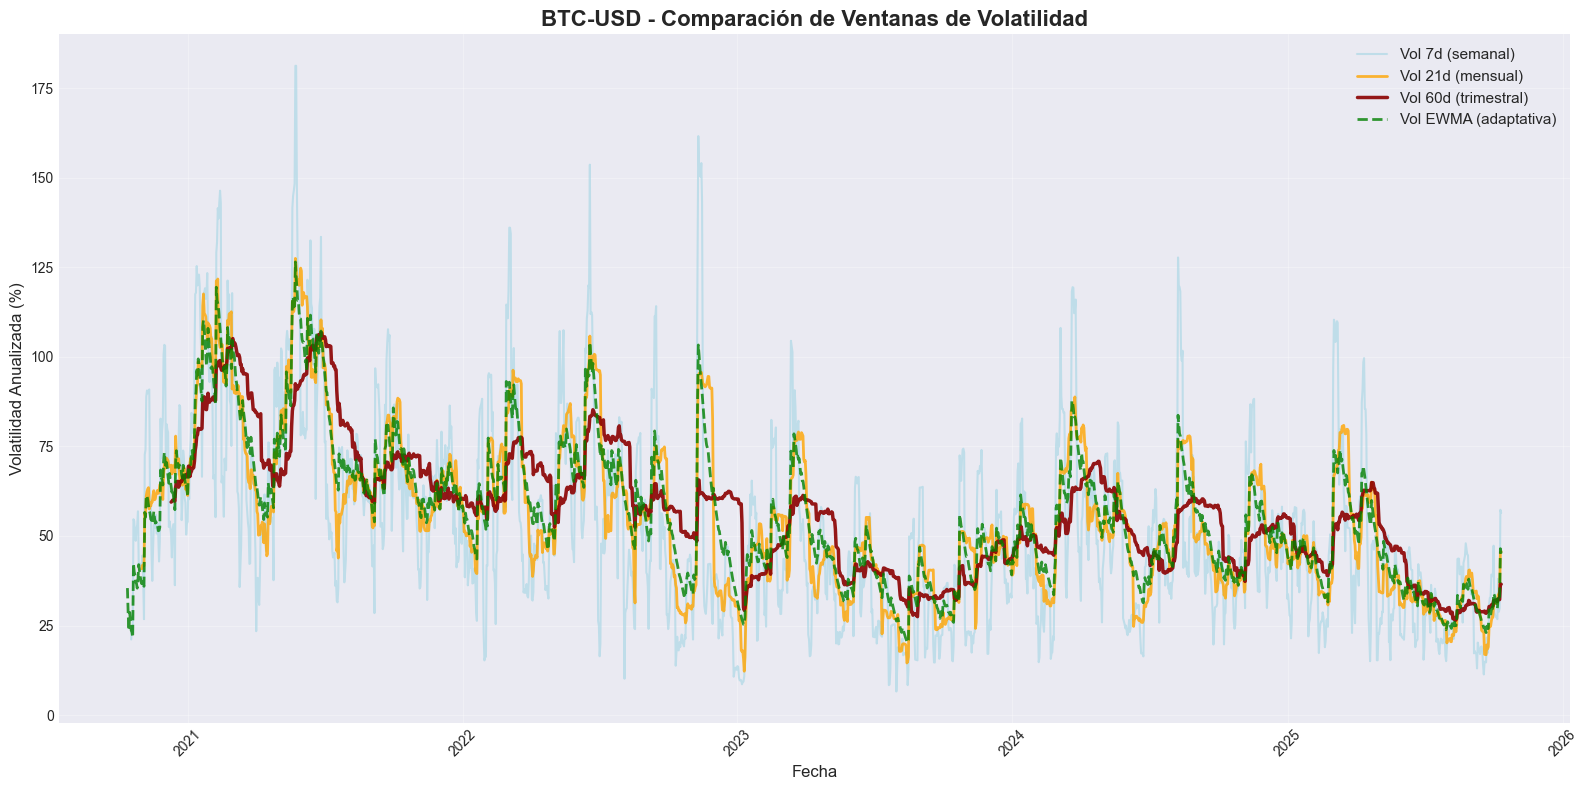


💡 INTERPRETACIÓN DE VENTANAS:
   • Vol 7d:  Muy reactiva, captura cambios inmediatos, ruidosa
   • Vol 21d: Balance óptimo entre reactividad y suavidad
   • Vol 60d: Tendencia de largo plazo, más estable
   • EWMA:    Adaptativa, da más peso a observaciones recientes


In [101]:
print("\n" + "="*80)
print("COMPARACIÓN DE VENTANAS TEMPORALES")
print("="*80)

# Figura 2: Diferentes ventanas (ejemplo con BTC)
crypto_example = 'BTC-USD'
vol_example = crypto_volatility[crypto_example]

fig, ax = plt.subplots(figsize=(16, 8))

ax.plot(vol_example['Date'], vol_example['Vol_7d'], 
        linewidth=1.5, alpha=0.7, label='Vol 7d (semanal)', color='lightblue')
ax.plot(vol_example['Date'], vol_example['Vol_21d'], 
        linewidth=2, alpha=0.8, label='Vol 21d (mensual)', color='orange')
ax.plot(vol_example['Date'], vol_example['Vol_60d'], 
        linewidth=2.5, alpha=0.9, label='Vol 60d (trimestral)', color='darkred')
ax.plot(vol_example['Date'], vol_example['Vol_EWMA'], 
        linewidth=2, alpha=0.8, label='Vol EWMA (adaptativa)', 
        color='green', linestyle='--')

ax.set_title(f'{crypto_example} - Comparación de Ventanas de Volatilidad', 
             fontsize=16, fontweight='bold')
ax.set_xlabel('Fecha', fontsize=12)
ax.set_ylabel('Volatilidad Anualizada (%)', fontsize=12)
ax.legend(loc='best', fontsize=11)
ax.grid(True, alpha=0.3)

plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
plt.tight_layout()
plt.show()

print("\n💡 INTERPRETACIÓN DE VENTANAS:")
print("   • Vol 7d:  Muy reactiva, captura cambios inmediatos, ruidosa")
print("   • Vol 21d: Balance óptimo entre reactividad y suavidad")
print("   • Vol 60d: Tendencia de largo plazo, más estable")
print("   • EWMA:    Adaptativa, da más peso a observaciones recientes")

In [102]:
print("\n" + "="*80)
print("🚨 IDENTIFICACIÓN DE EVENTOS DE ALTA VOLATILIDAD")
print("="*80)

# Definir umbral: volatilidad > media + 2*std
volatility_events = []

for crypto, vol_df in crypto_volatility.items():
    vol_series = vol_df['Vol_30d'].dropna()
    
    mean_vol = vol_series.mean()
    std_vol = vol_series.std()
    threshold = mean_vol + 2 * std_vol
    
    # Identificar eventos extremos
    high_vol_events = vol_df[vol_df['Vol_30d'] > threshold].copy()
    
    if len(high_vol_events) > 0:
        # Encontrar el evento máximo
        max_vol_idx = vol_df['Vol_30d'].idxmax()
        max_vol_date = vol_df.loc[max_vol_idx, 'Date']
        max_vol_value = vol_df.loc[max_vol_idx, 'Vol_30d']
        
        # Encontrar el período más tranquilo
        min_vol_idx = vol_df['Vol_30d'].idxmin()
        min_vol_date = vol_df.loc[min_vol_idx, 'Date']
        min_vol_value = vol_df.loc[min_vol_idx, 'Vol_30d']
        
        volatility_events.append({
            'Crypto': crypto,
            'Vol_Promedio': mean_vol,
            'Vol_Std': std_vol,
            'Vol_Min': min_vol_value,
            'Fecha_Min': min_vol_date.strftime('%Y-%m-%d'),
            'Vol_Max': max_vol_value,
            'Fecha_Max': max_vol_date.strftime('%Y-%m-%d'),
            'Ratio_Max/Min': max_vol_value / min_vol_value,
            'Eventos_Extremos': len(high_vol_events),
            'Umbral_2std': threshold
        })

vol_events_df = pd.DataFrame(volatility_events)
print("\n📊 ANÁLISIS DE EVENTOS DE VOLATILIDAD:\n")
print(vol_events_df.round(2).to_string(index=False))

print("\n💡 INSIGHTS:")
print("   • Ratio Max/Min: Cuántas veces más volátil fue el peor momento vs el más tranquilo")
print("   • Eventos Extremos: Días con volatilidad > μ + 2σ (esperado: ~2.5% de días)")
print("   • Fechas importantes: Revisar noticias/eventos en fechas de Vol_Max")



🚨 IDENTIFICACIÓN DE EVENTOS DE ALTA VOLATILIDAD

📊 ANÁLISIS DE EVENTOS DE VOLATILIDAD:

  Crypto  Vol_Promedio  Vol_Std  Vol_Min  Fecha_Min  Vol_Max  Fecha_Max  Ratio_Max/Min  Eventos_Extremos  Umbral_2std
 ETH-USD         74.00    28.59    15.40 2023-08-13   200.43 2021-06-01          13.02                60       131.19
USDT-USD          0.83     0.77     0.11 2022-09-11     5.67 2021-04-18          53.99                58         2.37
DOGE-USD        124.83   164.94    20.09 2023-09-30  1290.31 2021-01-31          64.22                38       454.70
 SOL-USD        107.65    45.12    48.67 2022-10-22   274.40 2021-06-13           5.64               117       197.90
 BTC-USD         55.86    20.21    16.98 2023-08-13   119.04 2021-06-09           7.01                90        96.28

💡 INSIGHTS:
   • Ratio Max/Min: Cuántas veces más volátil fue el peor momento vs el más tranquilo
   • Eventos Extremos: Días con volatilidad > μ + 2σ (esperado: ~2.5% de días)
   • Fechas importantes: 

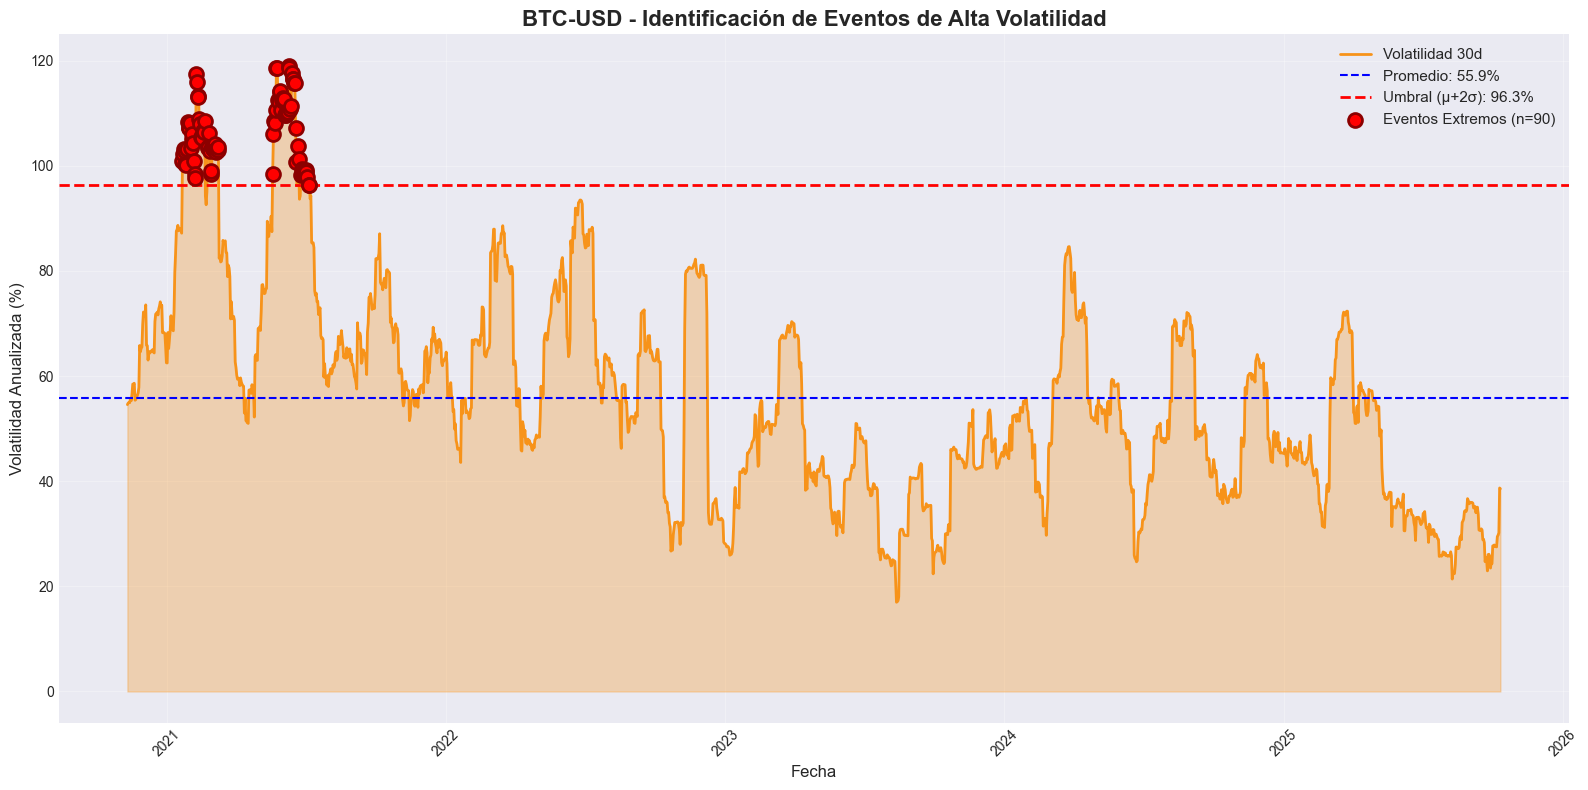

In [103]:
fig, ax = plt.subplots(figsize=(16, 8))

vol_btc = crypto_volatility[crypto_example]
vol_series_btc = vol_btc['Vol_30d'].dropna()
mean_vol_btc = vol_series_btc.mean()
std_vol_btc = vol_series_btc.std()
threshold_btc = mean_vol_btc + 2 * std_vol_btc

# Plot volatilidad
ax.plot(vol_btc['Date'], vol_btc['Vol_30d'], color='#F7931A', linewidth=2, label='Volatilidad 30d')
ax.fill_between(vol_btc['Date'], vol_btc['Vol_30d'], alpha=0.3, color='#F7931A')

# Líneas de referencia
ax.axhline(y=mean_vol_btc, color='blue', linestyle='--', linewidth=1.5, 
           label=f'Promedio: {mean_vol_btc:.1f}%')
ax.axhline(y=threshold_btc, color='red', linestyle='--', linewidth=2, 
           label=f'Umbral (μ+2σ): {threshold_btc:.1f}%')

# Marcar eventos extremos
extreme_events_btc = vol_btc[vol_btc['Vol_30d'] > threshold_btc]
if len(extreme_events_btc) > 0:
    ax.scatter(extreme_events_btc['Date'], extreme_events_btc['Vol_30d'], 
               color='red', s=100, zorder=5, label=f'Eventos Extremos (n={len(extreme_events_btc)})', 
               marker='o', edgecolors='darkred', linewidths=2)

ax.set_title(f'{crypto_example} - Identificación de Eventos de Alta Volatilidad', 
             fontsize=16, fontweight='bold')
ax.set_xlabel('Fecha', fontsize=12)
ax.set_ylabel('Volatilidad Anualizada (%)', fontsize=12)
ax.legend(loc='best', fontsize=11)
ax.grid(True, alpha=0.3)

plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
plt.tight_layout()
plt.show()


📊 COMPARACIÓN DE VOLATILIDAD ENTRE CRIPTOMONEDAS

📊 ESTADÍSTICAS COMPARATIVAS - VOLATILIDAD 30d (%):

  Crypto  Vol_Media  Vol_Mediana  Vol_Min  Vol_Max  Vol_Std  Vol_CV  Vol_P25  Vol_P75
DOGE-USD     124.83        88.63    20.09  1290.31   164.94  132.13    68.55   119.16
 SOL-USD     107.65        95.69    48.67   274.40    45.12   41.92    75.59   128.98
 ETH-USD      74.00        69.99    15.40   200.43    28.59   38.64    53.96    89.12
 BTC-USD      55.86        53.47    16.98   119.04    20.21   36.18    40.60    67.63
USDT-USD       0.83         0.67     0.11     5.67     0.77   93.31     0.45     0.97

💡 INTERPRETACIÓN:
   • CV (Coef. Variación): Volatilidad de la volatilidad
   • CV alto → Volatilidad muy cambiante (más impredecible)
   • P25-P75: Rango donde está el 50% central de las observaciones


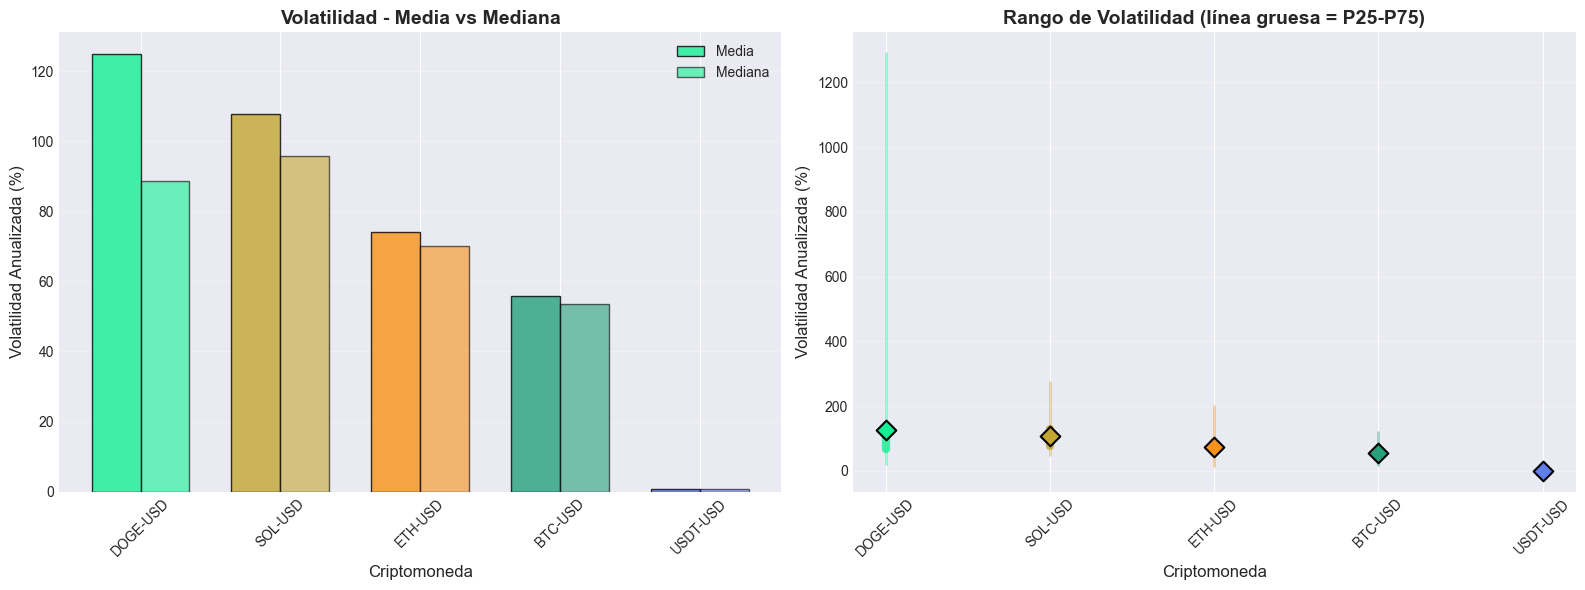

In [104]:
print("\n" + "="*80)
print("📊 COMPARACIÓN DE VOLATILIDAD ENTRE CRIPTOMONEDAS")
print("="*80)

# Crear DataFrame comparativo
vol_comparison = []

for crypto, vol_df in crypto_volatility.items():
    vol_30d = vol_df['Vol_30d'].dropna()
    
    vol_comparison.append({
        'Crypto': crypto,
        'Vol_Media': vol_30d.mean(),
        'Vol_Mediana': vol_30d.median(),
        'Vol_Min': vol_30d.min(),
        'Vol_Max': vol_30d.max(),
        'Vol_Std': vol_30d.std(),
        'Vol_CV': (vol_30d.std() / vol_30d.mean()) * 100,  # Coef. Variación
        'Vol_P25': vol_30d.quantile(0.25),
        'Vol_P75': vol_30d.quantile(0.75)
    })

vol_comp_df = pd.DataFrame(vol_comparison)
vol_comp_df = vol_comp_df.sort_values('Vol_Media', ascending=False)

print("\n📊 ESTADÍSTICAS COMPARATIVAS - VOLATILIDAD 30d (%):\n")
print(vol_comp_df.round(2).to_string(index=False))

print("\n💡 INTERPRETACIÓN:")
print("   • CV (Coef. Variación): Volatilidad de la volatilidad")
print("   • CV alto → Volatilidad muy cambiante (más impredecible)")
print("   • P25-P75: Rango donde está el 50% central de las observaciones")

# Figura 4: Bar plot comparativo
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Media y Mediana
ax1 = axes[0]
x = np.arange(len(vol_comp_df))
width = 0.35

bars1 = ax1.bar(x - width/2, vol_comp_df['Vol_Media'], width, 
                label='Media', alpha=0.8, edgecolor='black')
bars2 = ax1.bar(x + width/2, vol_comp_df['Vol_Mediana'], width,
                label='Mediana', alpha=0.6, edgecolor='black')

# Colorear por crypto
for i, (bar1, bar2) in enumerate(zip(bars1, bars2)):
    crypto_name = vol_comp_df.iloc[i]['Crypto']
    color_idx = list(crypto_volatility.keys()).index(crypto_name)
    bar1.set_facecolor(colors[color_idx])
    bar2.set_facecolor(colors[color_idx])

ax1.set_xlabel('Criptomoneda', fontsize=12)
ax1.set_ylabel('Volatilidad Anualizada (%)', fontsize=12)
ax1.set_title('Volatilidad - Media vs Mediana', fontsize=14, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(vol_comp_df['Crypto'], rotation=45)
ax1.legend()
ax1.grid(True, alpha=0.3, axis='y')

# Rango (Min-Max con P25-P75)
ax2 = axes[1]
for i, row in enumerate(vol_comp_df.itertuples()):
    crypto_idx = list(crypto_volatility.keys()).index(row.Crypto)
    
    # Línea Min-Max
    ax2.plot([i, i], [row.Vol_Min, row.Vol_Max], 
             color=colors[crypto_idx], linewidth=2, alpha=0.4)
    
    # Caja P25-P75 (50% central)
    ax2.plot([i, i], [row.Vol_P25, row.Vol_P75], 
             color=colors[crypto_idx], linewidth=6, alpha=0.8)
    
    # Marcar media
    ax2.scatter(i, row.Vol_Media, color=colors[crypto_idx], 
                s=100, marker='D', edgecolors='black', linewidths=1.5, zorder=5)

ax2.set_xlabel('Criptomoneda', fontsize=12)
ax2.set_ylabel('Volatilidad Anualizada (%)', fontsize=12)
ax2.set_title('Rango de Volatilidad (línea gruesa = P25-P75)', fontsize=14, fontweight='bold')
ax2.set_xticks(range(len(vol_comp_df)))
ax2.set_xticklabels(vol_comp_df['Crypto'], rotation=45)
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()



DISTRIBUCIÓN DE VOLATILIDAD


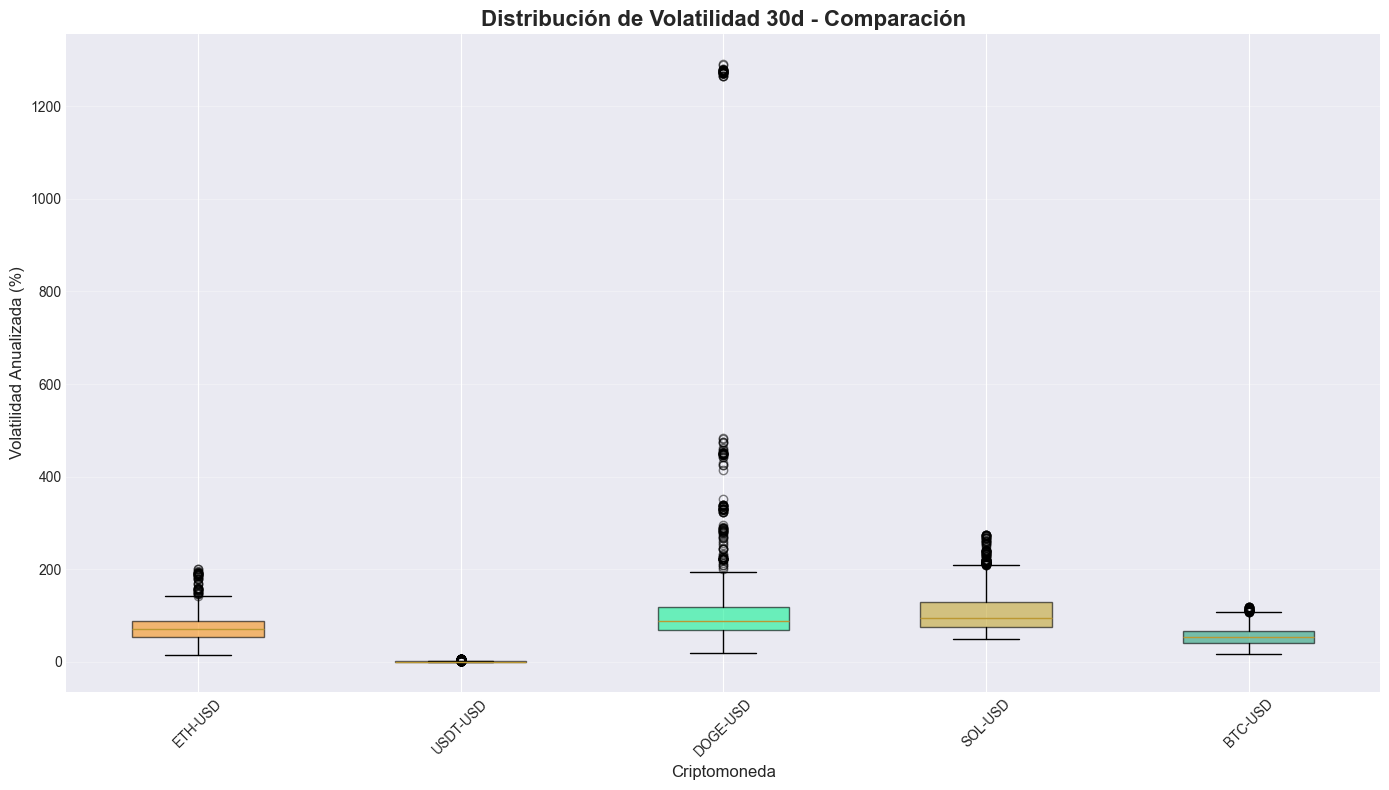


 LECTURA DEL BOX PLOT:
   • Caja: Contiene el 50% central de datos (P25-P75)
   • Línea dentro: Mediana
   • Bigotes: Hasta 1.5×IQR desde la caja
   • Puntos: Outliers (eventos extremos)


In [109]:
print("\n" + "="*80)
print("DISTRIBUCIÓN DE VOLATILIDAD")
print("="*80)

# Figura 5: Box plot de distribución de volatilidad
fig, ax = plt.subplots(figsize=(14, 8))

vol_data_for_box = []
labels = []

for crypto, vol_df in crypto_volatility.items():
    vol_data_for_box.append(vol_df['Vol_30d'].dropna())
    labels.append(crypto)

bp = ax.boxplot(vol_data_for_box, labels=labels, patch_artist=True, 
                showfliers=True, whis=1.5)

for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)

# Colorear outliers
for flier, color in zip(bp['fliers'], colors):
    flier.set(marker='o', color=color, alpha=0.5)

ax.set_title('Distribución de Volatilidad 30d - Comparación', 
             fontsize=16, fontweight='bold')
ax.set_ylabel('Volatilidad Anualizada (%)', fontsize=12)
ax.set_xlabel('Criptomoneda', fontsize=12)
ax.grid(True, alpha=0.3, axis='y')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("\n LECTURA DEL BOX PLOT:")
print("   • Caja: Contiene el 50% central de datos (P25-P75)")
print("   • Línea dentro: Mediana")
print("   • Bigotes: Hasta 1.5×IQR desde la caja")
print("   • Puntos: Outliers (eventos extremos)")


 RELACIÓN ENTRE VOLATILIDAD Y VOLUMEN DE TRANSACCIONES


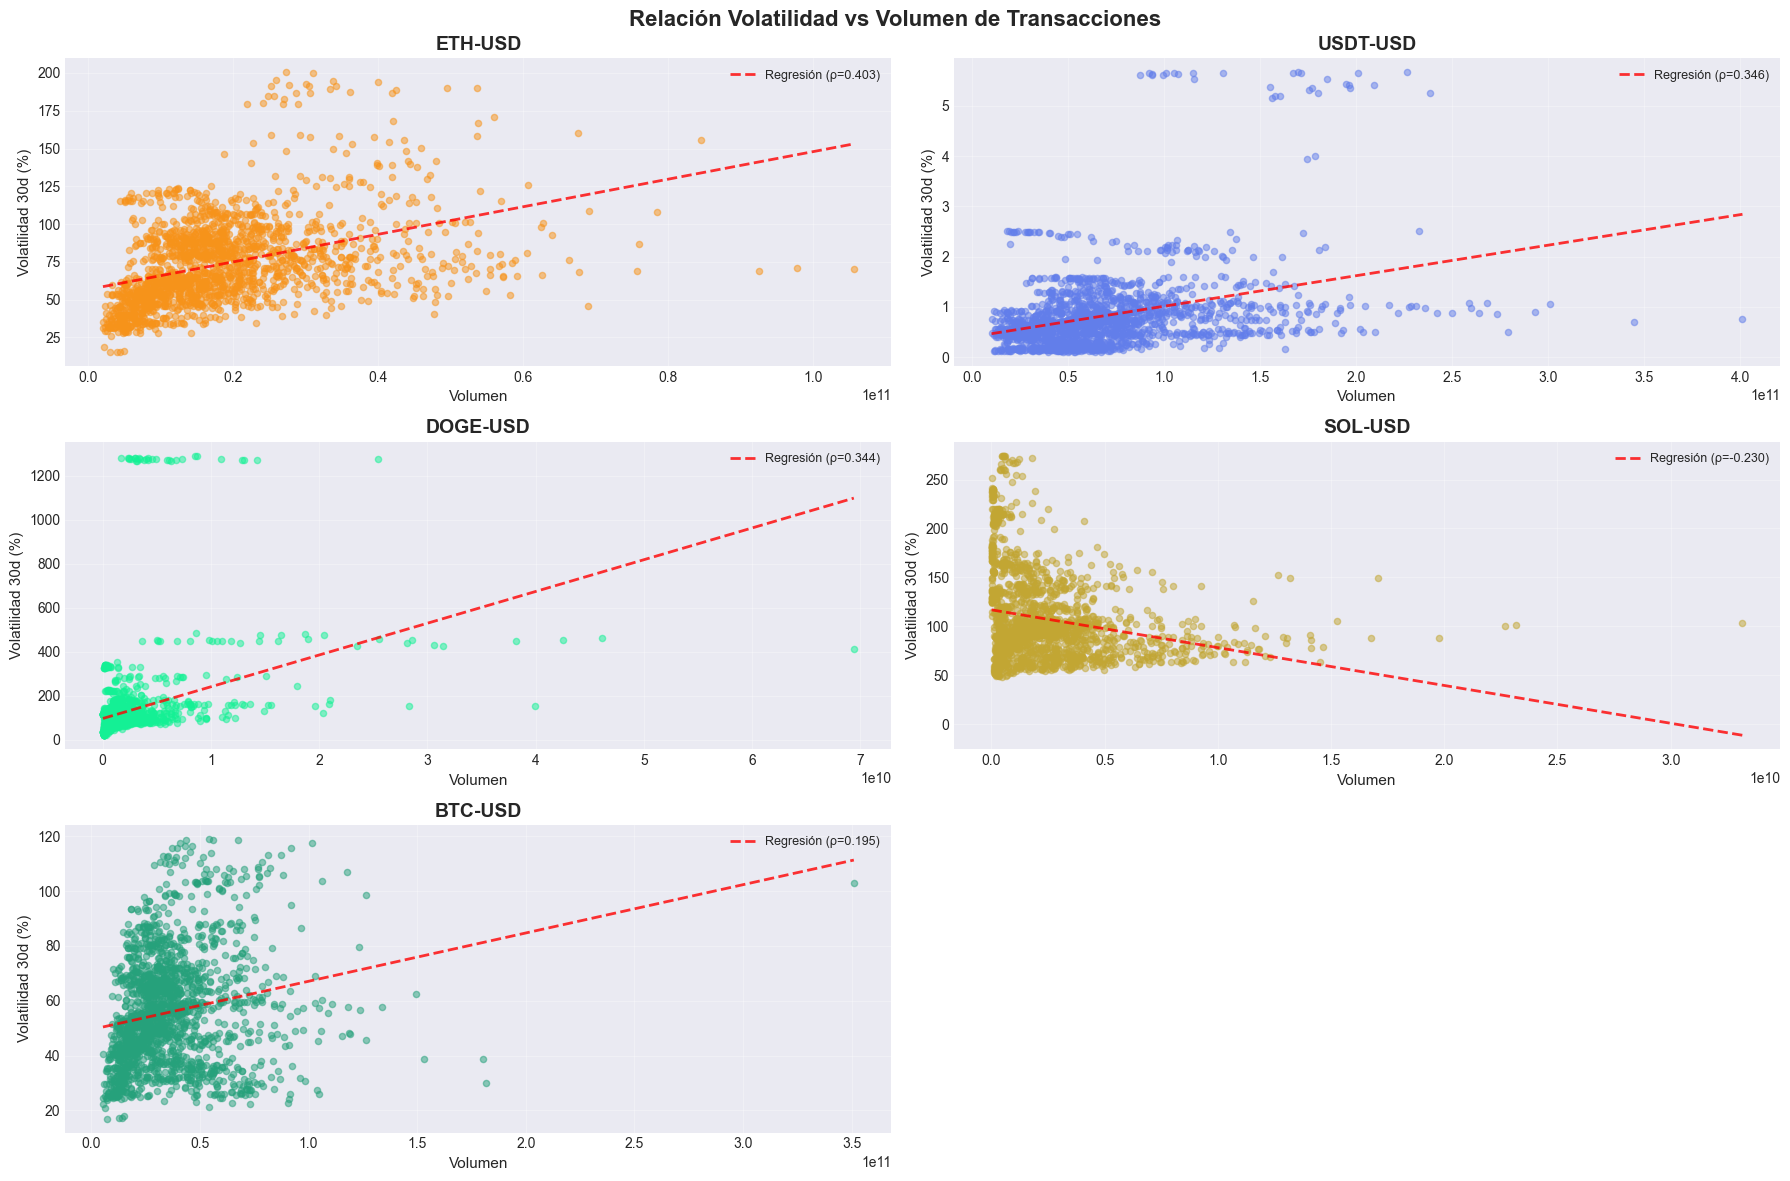


 CORRELACIÓN VOLATILIDAD-VOLUMEN:

  Crypto  Correlación Interpretación
 ETH-USD     0.402631       Positiva
USDT-USD     0.345880       Positiva
DOGE-USD     0.344355       Positiva
 SOL-USD    -0.230196 Débil/Negativa
 BTC-USD     0.194646 Débil/Negativa

 INTERPRETACIÓN:
   • ρ > 0.3: Correlación positiva (mayor volumen → mayor volatilidad)
   • ρ ≈ 0: Sin relación clara
   • ρ < -0.3: Correlación negativa (inusual)
   • Típicamente: Picos de volumen coinciden con picos de volatilidad


In [108]:
print("\n" + "="*80)
print(" RELACIÓN ENTRE VOLATILIDAD Y VOLUMEN DE TRANSACCIONES")
print("="*80)

# Figura 6: Scatter plots Volatilidad vs Volumen
fig, axes = plt.subplots(3, 2, figsize=(18, 12))
fig.suptitle('Relación Volatilidad vs Volumen de Transacciones', fontsize=16, fontweight='bold')

axes = axes.flatten()

correlation_results = []

for idx, (crypto, vol_df) in enumerate(crypto_volatility.items()):
    ax = axes[idx]
    
    # Obtener datos originales de volumen
    original_data = crypto_data[crypto]
    vol_with_volume = vol_df.merge(original_data[['Date', 'Volume']], on='Date', how='left')
    
    # Limpiar datos
    clean_data = vol_with_volume[['Vol_30d', 'Volume']].dropna()
    
    if len(clean_data) > 10:
        # Scatter plot
        ax.scatter(clean_data['Volume'], clean_data['Vol_30d'], 
                   alpha=0.5, color=colors[idx], s=20)
        
        # Calcular correlación
        correlation = clean_data['Vol_30d'].corr(clean_data['Volume'])
        
        # Línea de regresión
        z = np.polyfit(clean_data['Volume'], clean_data['Vol_30d'], 1)
        p = np.poly1d(z)
        x_line = np.linspace(clean_data['Volume'].min(), clean_data['Volume'].max(), 100)
        ax.plot(x_line, p(x_line), "r--", linewidth=2, alpha=0.8, 
                label=f'Regresión (ρ={correlation:.3f})')
        
        correlation_results.append({
            'Crypto': crypto,
            'Correlación': correlation,
            'Interpretación': 'Positiva' if correlation > 0.3 else 'Débil/Negativa'
        })
        
        ax.set_title(f'{crypto}', fontsize=14, fontweight='bold')
        ax.set_xlabel('Volumen', fontsize=11)
        ax.set_ylabel('Volatilidad 30d (%)', fontsize=11)
        ax.ticklabel_format(style='scientific', axis='x', scilimits=(0,0))
        ax.legend(loc='best', fontsize=9)
        ax.grid(True, alpha=0.3)

axes[-1].axis('off')
plt.tight_layout()
plt.show()

# Tabla de correlaciones
corr_df = pd.DataFrame(correlation_results)
print("\n CORRELACIÓN VOLATILIDAD-VOLUMEN:\n")
print(corr_df.to_string(index=False))

print("\n INTERPRETACIÓN:")
print("   • ρ > 0.3: Correlación positiva (mayor volumen → mayor volatilidad)")
print("   • ρ ≈ 0: Sin relación clara")
print("   • ρ < -0.3: Correlación negativa (inusual)")
print("   • Típicamente: Picos de volumen coinciden con picos de volatilidad")


 VISUALIZACIÓN DE VOLATILITY CLUSTERING


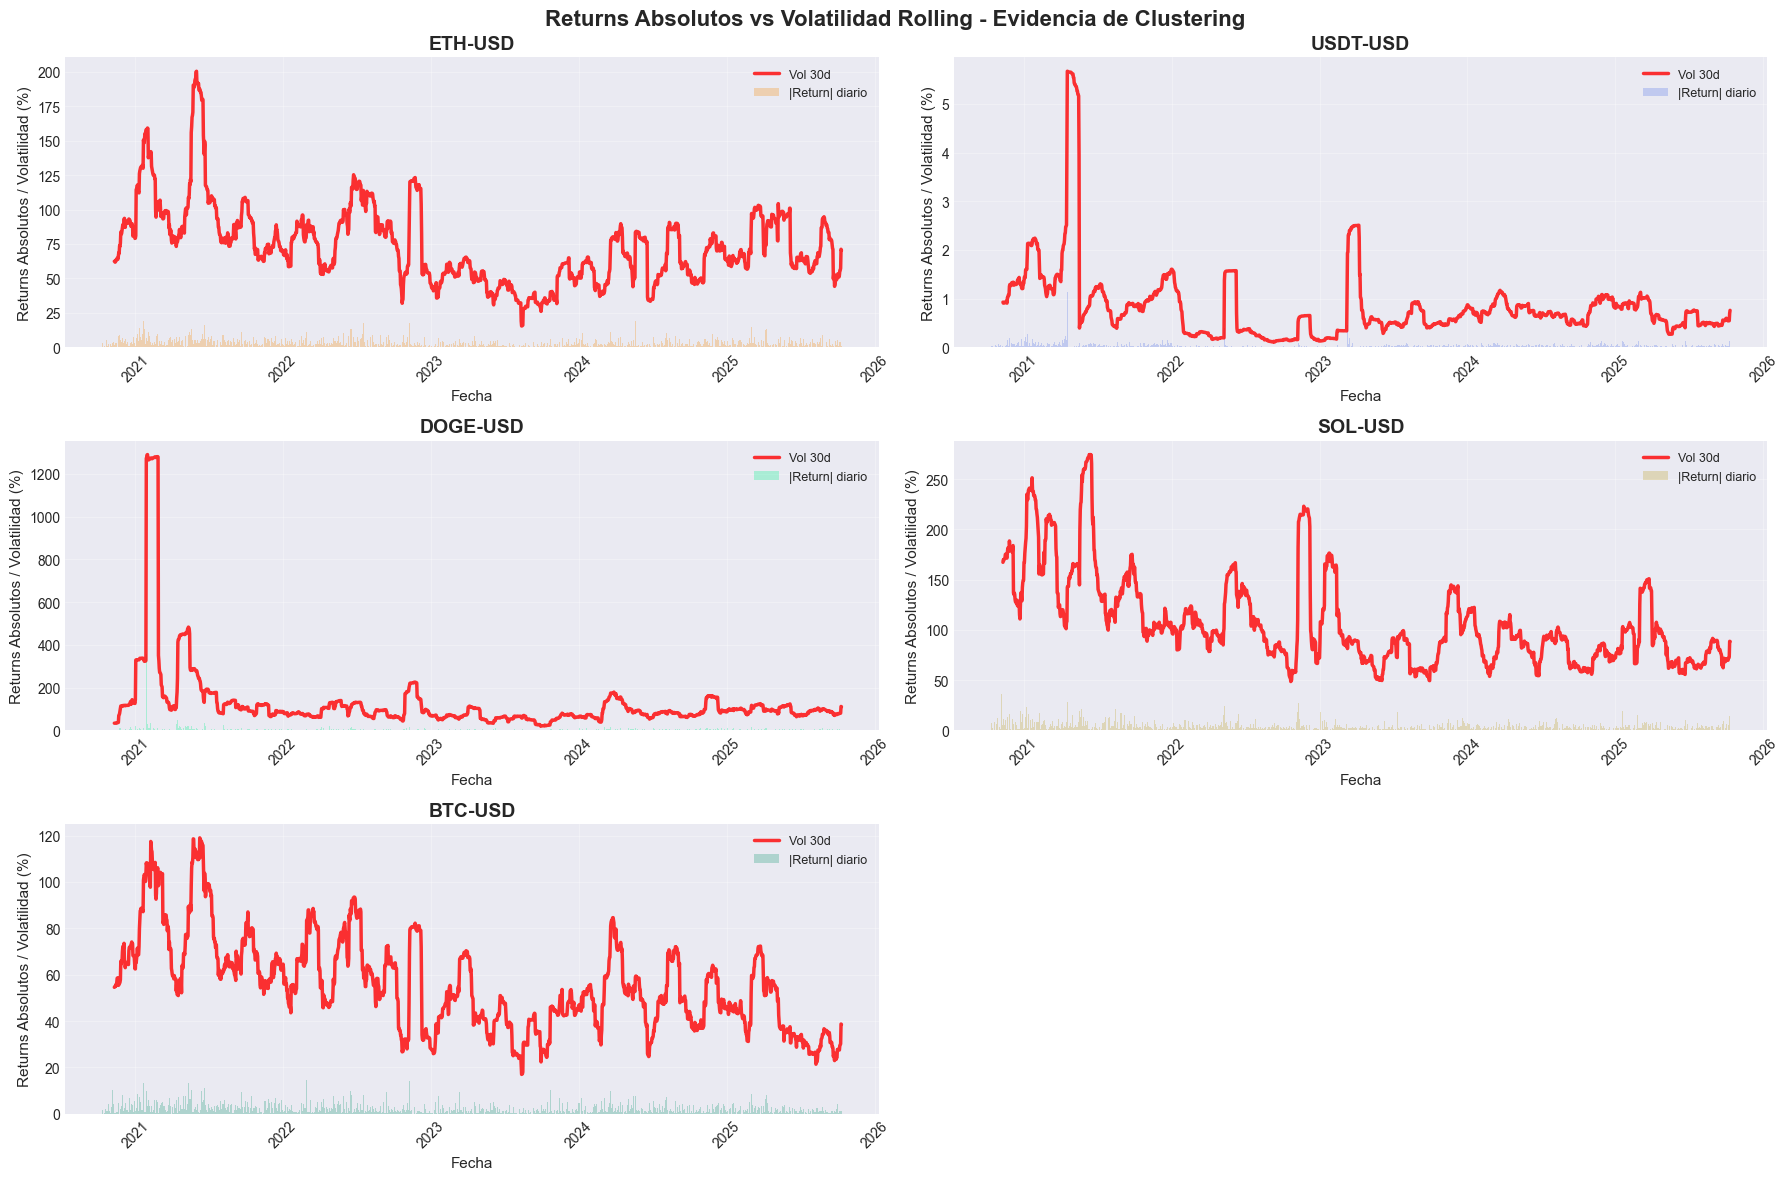


💡 OBSERVACIÓN:
   • Cuando barras son altas → Volatilidad (línea roja) también sube
   • Períodos de barras altas se agrupan → CLUSTERING visual
   • Confirma hallazgos del ACF de returns²


In [110]:
print("\n" + "="*80)
print(" VISUALIZACIÓN DE VOLATILITY CLUSTERING")
print("="*80)

# Figura 7: Returns absolutos vs Volatilidad Rolling
fig, axes = plt.subplots(3, 2, figsize=(18, 12))
fig.suptitle('Returns Absolutos vs Volatilidad Rolling - Evidencia de Clustering', 
             fontsize=16, fontweight='bold')

axes = axes.flatten()

for idx, (crypto, vol_df) in enumerate(crypto_volatility.items()):
    ax = axes[idx]
    
    # Plot returns absolutos (barras)
    abs_returns = vol_df['Simple_Return'].abs()
    ax.bar(vol_df['Date'], abs_returns, color=colors[idx], 
           alpha=0.3, width=1, label='|Return| diario')
    
    # Overlay: Volatilidad rolling (línea)
    ax.plot(vol_df['Date'], vol_df['Vol_30d'], color='red', 
            linewidth=2.5, alpha=0.8, label='Vol 30d')
    
    ax.set_title(f'{crypto}', fontsize=14, fontweight='bold')
    ax.set_xlabel('Fecha', fontsize=11)
    ax.set_ylabel('Returns Absolutos / Volatilidad (%)', fontsize=11)
    ax.legend(loc='best', fontsize=9)
    ax.grid(True, alpha=0.3)
    
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)

axes[-1].axis('off')
plt.tight_layout()
plt.show()

print("\n💡 OBSERVACIÓN:")
print("   • Cuando barras son altas → Volatilidad (línea roja) también sube")
print("   • Períodos de barras altas se agrupan → CLUSTERING visual")
print("   • Confirma hallazgos del ACF de returns²")



 ANÁLISIS DE PERSISTENCIA DE VOLATILIDAD

 TEORÍA:
   • Volatilidad tiene "memoria" (persistencia)
   • Después de un shock, tarda en volver a niveles normales
   • Medida: Half-life (tiempo para reducirse a la mitad)


 PERSISTENCIA DE VOLATILIDAD:

  Crypto  ACF_Lag1  Half_Life_días Interpretación
 ETH-USD     0.990              29           Alta
USDT-USD     0.988              21           Alta
DOGE-USD     0.980              21           Alta
 SOL-USD     0.991              26           Alta
 BTC-USD     0.989              29           Alta

 INTERPRETACIÓN:
   • ACF_Lag1 alto (>0.7): Volatilidad MUY persistente
   • Half-Life: Días hasta que un shock pierde la mitad de su efecto
   • Mayor persistencia → Shocks duran más → Modelos GARCH más útiles


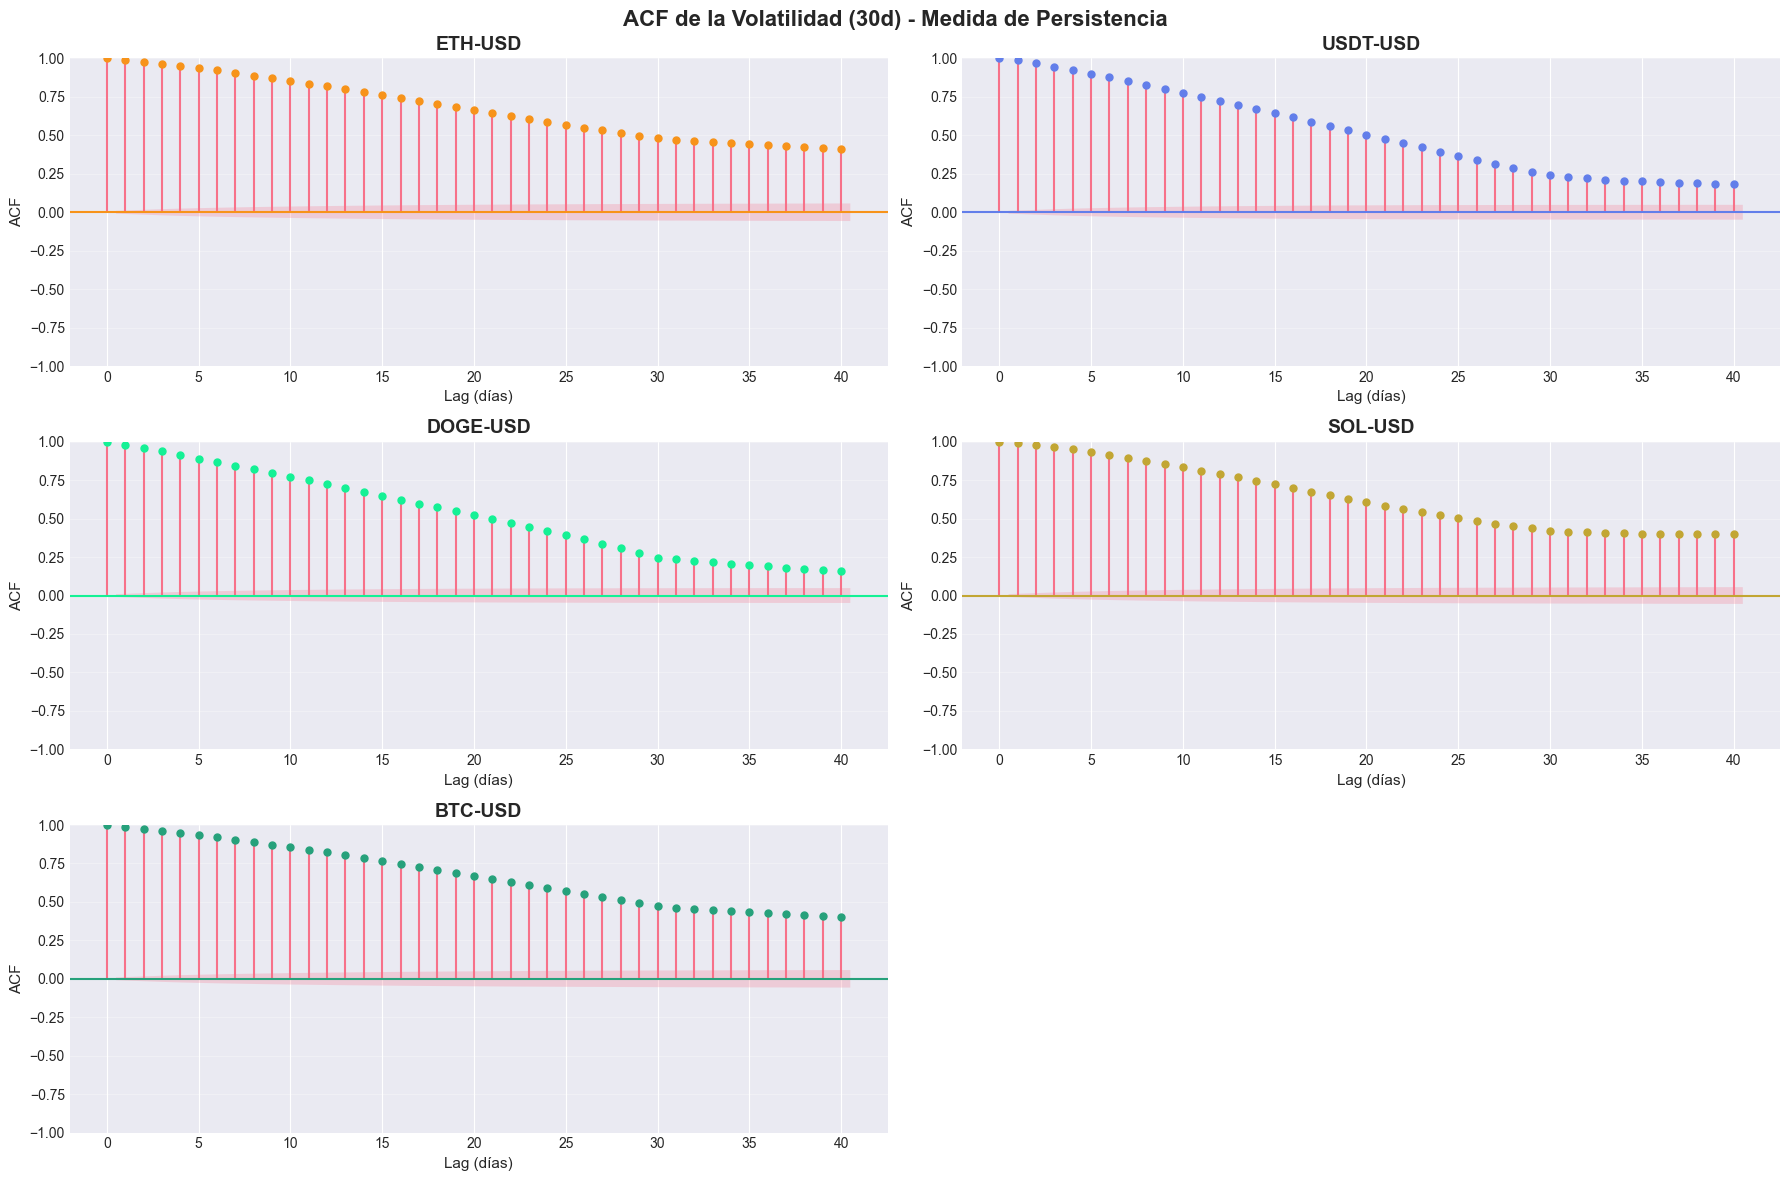

In [112]:
print("\n" + "="*80)
print(" ANÁLISIS DE PERSISTENCIA DE VOLATILIDAD")
print("="*80)

print("""
 TEORÍA:
   • Volatilidad tiene "memoria" (persistencia)
   • Después de un shock, tarda en volver a niveles normales
   • Medida: Half-life (tiempo para reducirse a la mitad)
""")

persistence_results = []

for crypto, vol_df in crypto_volatility.items():
    vol_series = vol_df['Vol_30d'].dropna()
    
    # Calcular autocorrelación de la volatilidad
    from statsmodels.tsa.stattools import acf
    vol_acf = acf(vol_series, nlags=60)
    
    # Encontrar half-life (primer lag donde ACF < 0.5)
    half_life = np.where(vol_acf < 0.5)[0]
    half_life_days = half_life[0] if len(half_life) > 0 else '>60'
    
    # Persistencia = ACF(1)
    persistence = vol_acf[1]
    
    persistence_results.append({
        'Crypto': crypto,
        'ACF_Lag1': persistence,
        'Half_Life_días': half_life_days,
        'Interpretación': 'Alta' if persistence > 0.7 else 'Media' if persistence > 0.4 else 'Baja'
    })

persistence_df = pd.DataFrame(persistence_results)
print("\n PERSISTENCIA DE VOLATILIDAD:\n")
print(persistence_df.round(3).to_string(index=False))

print("\n INTERPRETACIÓN:")
print("   • ACF_Lag1 alto (>0.7): Volatilidad MUY persistente")
print("   • Half-Life: Días hasta que un shock pierde la mitad de su efecto")
print("   • Mayor persistencia → Shocks duran más → Modelos GARCH más útiles")

# Figura 8: ACF de Volatilidad
fig, axes = plt.subplots(3, 2, figsize=(18, 12))
fig.suptitle('ACF de la Volatilidad (30d) - Medida de Persistencia', 
             fontsize=16, fontweight='bold')

axes = axes.flatten()

for idx, (crypto, vol_df) in enumerate(crypto_volatility.items()):
    ax = axes[idx]
    
    vol_series = vol_df['Vol_30d'].dropna()
    
    from statsmodels.graphics.tsaplots import plot_acf
    plot_acf(vol_series, lags=40, ax=ax, color=colors[idx], alpha=0.7)
    
    ax.set_title(f'{crypto}', fontsize=14, fontweight='bold')
    ax.set_xlabel('Lag (días)', fontsize=11)
    ax.set_ylabel('ACF', fontsize=11)
    ax.grid(True, alpha=0.3, axis='y')

axes[-1].axis('off')
plt.tight_layout()
plt.show()


📉 ANÁLISIS DE LEVERAGE EFFECT (ASIMETRÍA)

🔬 LEVERAGE EFFECT:
   • Hipótesis: Returns negativos aumentan MÁS la volatilidad que positivos
   • "Bad news increases volatility more than good news"
   • Común en acciones, menos claro en crypto
   • Importante para: Risk management, options pricing



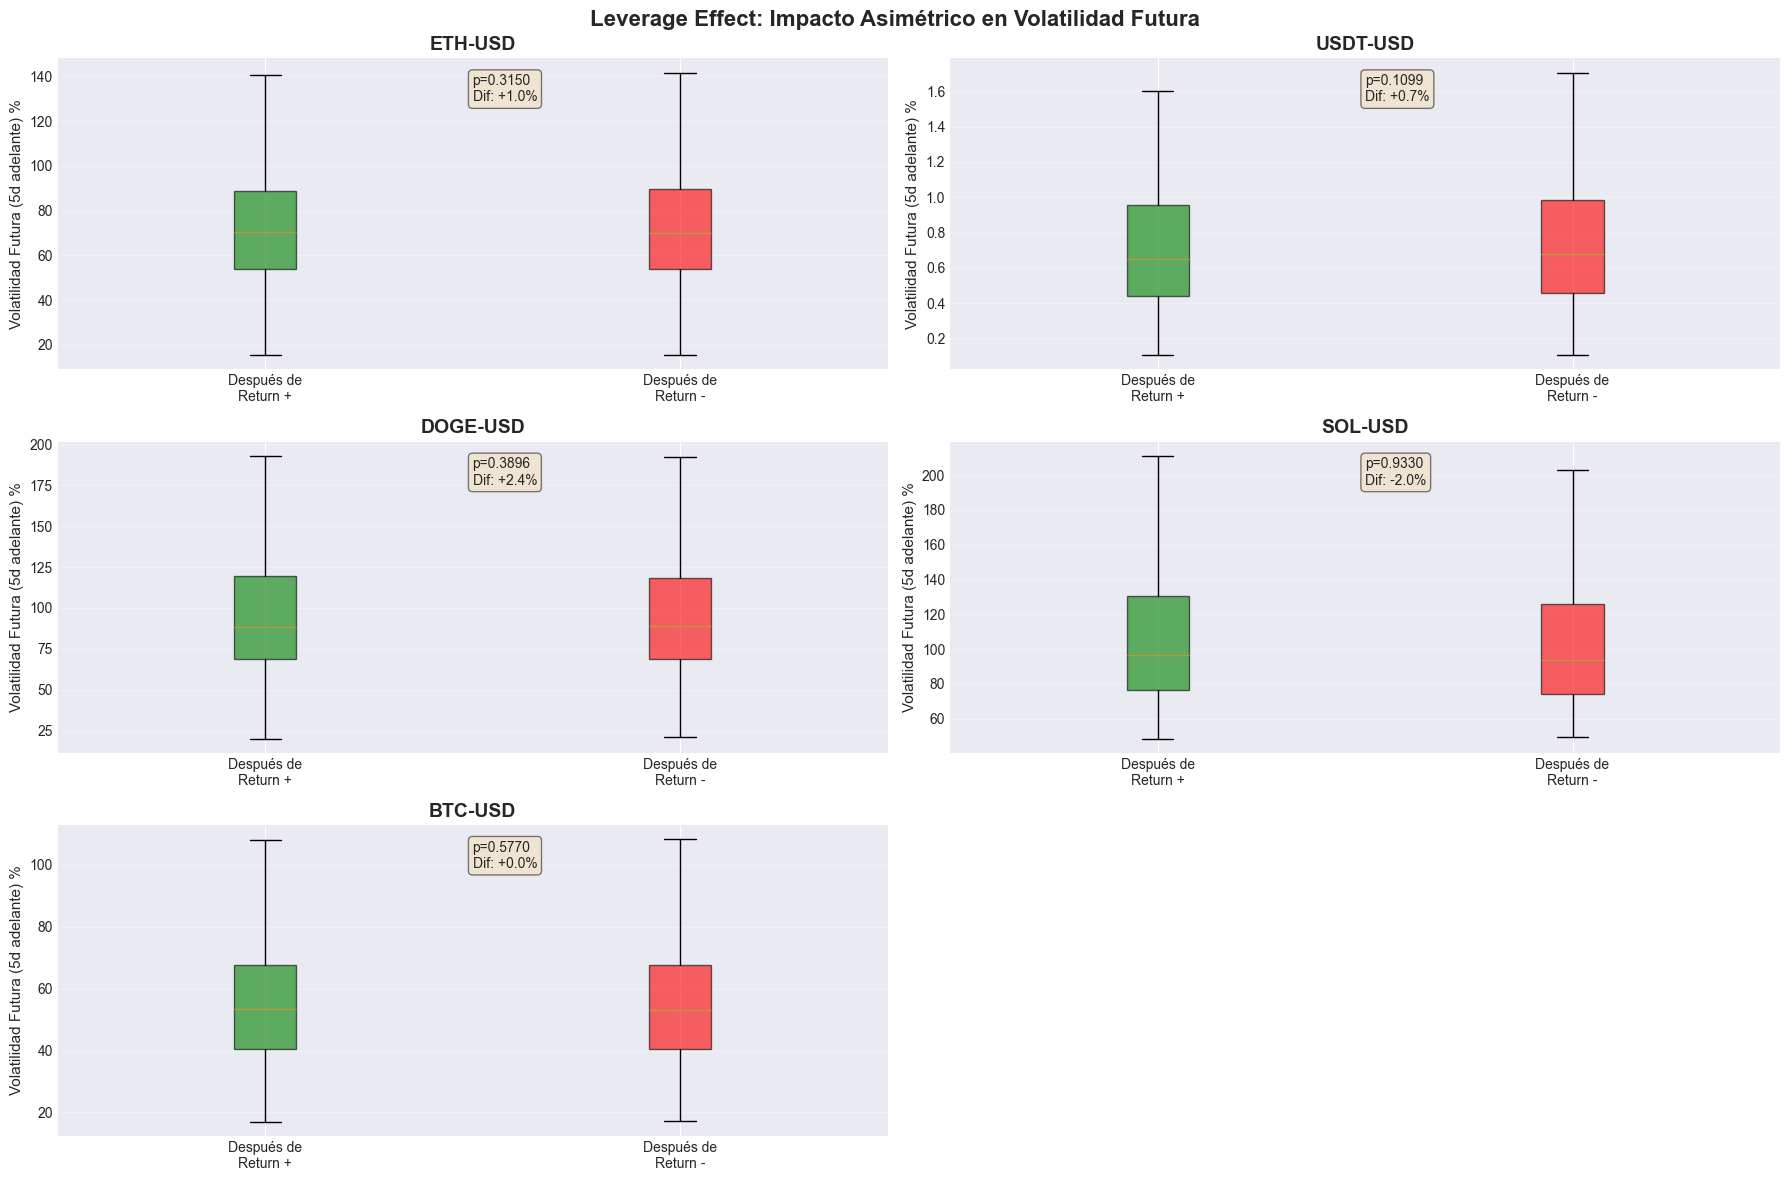

In [113]:
print("\n" + "="*80)
print("📉 ANÁLISIS DE LEVERAGE EFFECT (ASIMETRÍA)")
print("="*80)

print("""
🔬 LEVERAGE EFFECT:
   • Hipótesis: Returns negativos aumentan MÁS la volatilidad que positivos
   • "Bad news increases volatility more than good news"
   • Común en acciones, menos claro en crypto
   • Importante para: Risk management, options pricing
""")

leverage_results = []

# Figura 9: Análisis de Leverage Effect
fig, axes = plt.subplots(3, 2, figsize=(18, 12))
fig.suptitle('Leverage Effect: Impacto Asimétrico en Volatilidad Futura', 
             fontsize=16, fontweight='bold')

axes = axes.flatten()

from scipy.stats import mannwhitneyu

for idx, (crypto, vol_df) in enumerate(crypto_volatility.items()):
    ax = axes[idx]
    
    # Preparar datos
    vol_analysis = vol_df[['Simple_Return', 'Vol_30d']].copy()
    vol_analysis['Future_Vol'] = vol_analysis['Vol_30d'].shift(-5)  # 5 días adelante
    vol_analysis = vol_analysis.dropna()
    
    # Separar returns positivos y negativos
    positive = vol_analysis[vol_analysis['Simple_Return'] > 0]['Future_Vol']
    negative = vol_analysis[vol_analysis['Simple_Return'] < 0]['Future_Vol']
    
    # Box plot comparativo
    bp = ax.boxplot([positive, negative], 
                     labels=['Después de\nReturn +', 'Después de\nReturn -'],
                     patch_artist=True, showfliers=False)
    
    bp['boxes'][0].set_facecolor('green')
    bp['boxes'][0].set_alpha(0.6)
    bp['boxes'][1].set_facecolor('red')
    bp['boxes'][1].set_alpha(0.6)
    
    # Test estadístico
    if len(positive) > 10 and len(negative) > 10:
        stat, pvalue = mannwhitneyu(negative, positive, alternative='greater')
        
        mean_pos = positive.mean()
        mean_neg = negative.mean()
        diff_pct = ((mean_neg - mean_pos) / mean_pos) * 100
        
        leverage_results.append({
            'Crypto': crypto,
            'Vol_después_+': mean_pos,
            'Vol_después_-': mean_neg,
            'Diferencia_%': diff_pct,
            'p_value': pvalue,
            'Leverage': 'SÍ' if pvalue < 0.05 and diff_pct > 0 else 'NO'
        })
        
        # Añadir texto con resultados
        ax.text(0.5, 0.95, f'p={pvalue:.4f}\nDif: {diff_pct:+.1f}%', 
                transform=ax.transAxes, fontsize=10, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    ax.set_title(f'{crypto}', fontsize=14, fontweight='bold')
    ax.set_ylabel('Volatilidad Futura (5d adelante) %', fontsize=11)
    ax.grid(True, alpha=0.3, axis='y')

axes[-1].axis('off')
plt.tight_layout()
plt.show()

In [114]:
# Tabla de resultados
leverage_df = pd.DataFrame(leverage_results)
print("\n ANÁLISIS DE LEVERAGE EFFECT:\n")
print(leverage_df.round(3).to_string(index=False))

print("\n INTERPRETACIÓN:")
print("   • p < 0.05 y Dif > 0: Leverage effect PRESENTE")
print("   • Diferencia_%: Cuánto más aumenta la volatilidad después de returns negativos")
print("   • En crypto: Menos consistente que en mercados de acciones tradicionales")


 ANÁLISIS DE LEVERAGE EFFECT:

  Crypto  Vol_después_+  Vol_después_-  Diferencia_%  p_value Leverage
 ETH-USD         73.689         74.404         0.971    0.315       NO
USDT-USD          0.823          0.828         0.695    0.110       NO
DOGE-USD        123.562        126.579         2.441    0.390       NO
 SOL-USD        108.545        106.400        -1.976    0.933       NO
 BTC-USD         55.861         55.862         0.002    0.577       NO

 INTERPRETACIÓN:
   • p < 0.05 y Dif > 0: Leverage effect PRESENTE
   • Diferencia_%: Cuánto más aumenta la volatilidad después de returns negativos
   • En crypto: Menos consistente que en mercados de acciones tradicionales



🎭 IDENTIFICACIÓN DE REGÍMENES DE VOLATILIDAD

📚 CONCEPTO:
   • Mercados alternan entre regímenes de BAJA y ALTA volatilidad
   • Útil para: Ajustar estrategias, position sizing, stop-loss
   • Método simple: Clasificar por percentiles



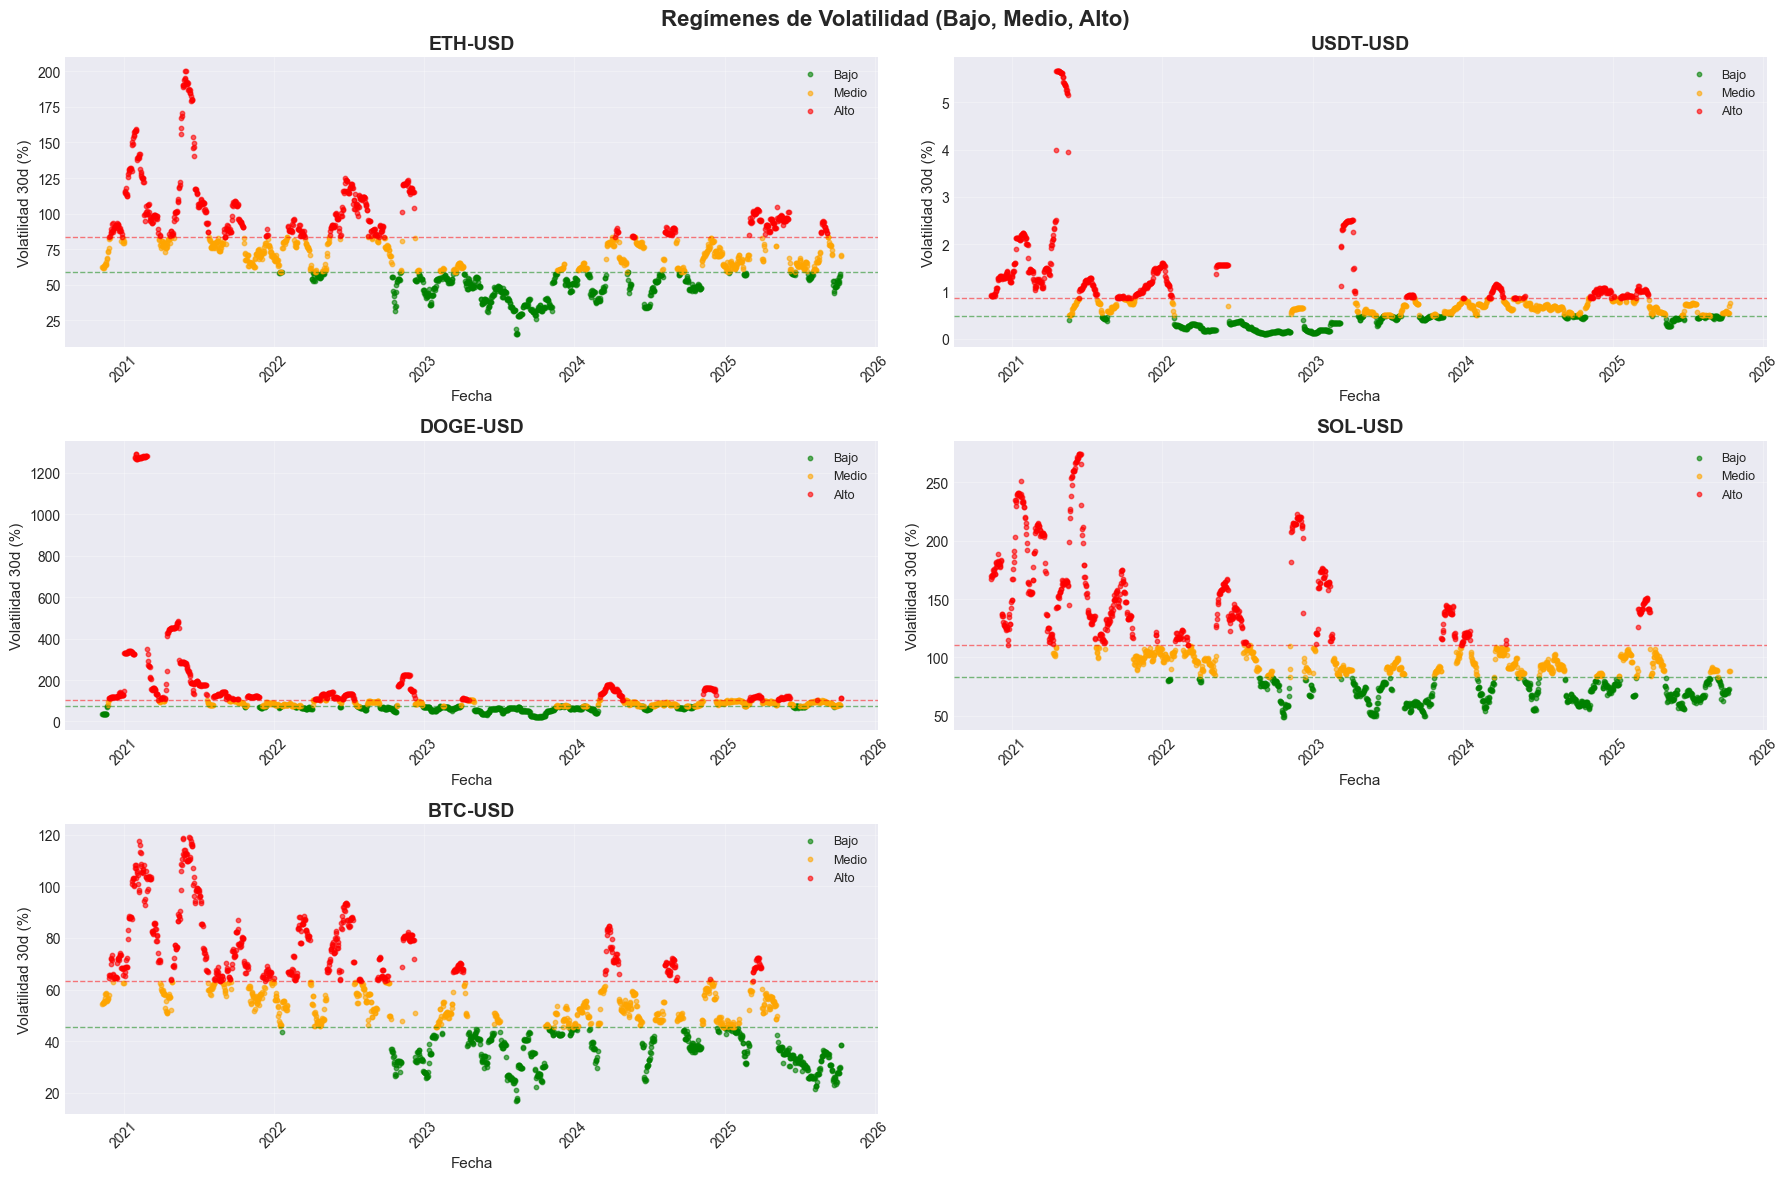


📊 DISTRIBUCIÓN DE REGÍMENES DE VOLATILIDAD:

  Crypto  P33_umbral  P67_umbral  Días_Bajo_%  Días_Medio_%  Días_Alto_%
 ETH-USD       58.96       83.53         33.0          34.0         33.0
USDT-USD        0.50        0.86         33.0          34.0         33.0
DOGE-USD       73.54      104.61         33.0          34.0         33.0
 SOL-USD       83.02      110.40         33.0          34.0         33.0
 BTC-USD       45.31       63.39         33.0          34.0         33.0

💡 APLICACIÓN PRÁCTICA:
   • Régimen BAJO: Aumentar posiciones, estrategias agresivas
   • Régimen MEDIO: Estrategias balanceadas
   • Régimen ALTO: Reducir exposición, proteger capital


In [115]:
print("\n" + "="*80)
print("🎭 IDENTIFICACIÓN DE REGÍMENES DE VOLATILIDAD")
print("="*80)

print("""
📚 CONCEPTO:
   • Mercados alternan entre regímenes de BAJA y ALTA volatilidad
   • Útil para: Ajustar estrategias, position sizing, stop-loss
   • Método simple: Clasificar por percentiles
""")

# Figura 10: Regímenes de volatilidad
fig, axes = plt.subplots(3, 2, figsize=(18, 12))
fig.suptitle('Regímenes de Volatilidad (Bajo, Medio, Alto)', 
             fontsize=16, fontweight='bold')

axes = axes.flatten()

regime_summary = []

for idx, (crypto, vol_df) in enumerate(crypto_volatility.items()):
    ax = axes[idx]
    
    vol_series = vol_df[['Date', 'Vol_30d']].dropna()
    
    # Definir regímenes por percentiles
    p33 = vol_series['Vol_30d'].quantile(0.33)
    p67 = vol_series['Vol_30d'].quantile(0.67)
    
    # Clasificar
    vol_series['Regimen'] = pd.cut(vol_series['Vol_30d'], 
                                     bins=[0, p33, p67, float('inf')],
                                     labels=['Bajo', 'Medio', 'Alto'])
    
    # Contar días en cada régimen
    regime_counts = vol_series['Regimen'].value_counts()
    pct_bajo = (regime_counts['Bajo'] / len(vol_series)) * 100
    pct_medio = (regime_counts['Medio'] / len(vol_series)) * 100
    pct_alto = (regime_counts['Alto'] / len(vol_series)) * 100
    
    regime_summary.append({
        'Crypto': crypto,
        'P33_umbral': p33,
        'P67_umbral': p67,
        'Días_Bajo_%': pct_bajo,
        'Días_Medio_%': pct_medio,
        'Días_Alto_%': pct_alto
    })
    
    # Visualizar con colores por régimen
    colors_regime = {'Bajo': 'green', 'Medio': 'orange', 'Alto': 'red'}
    
    for regime in ['Bajo', 'Medio', 'Alto']:
        regime_data = vol_series[vol_series['Regimen'] == regime]
        ax.scatter(regime_data['Date'], regime_data['Vol_30d'], 
                   c=colors_regime[regime], alpha=0.6, s=10, label=regime)
    
    # Líneas de umbral
    ax.axhline(y=p33, color='green', linestyle='--', linewidth=1, alpha=0.5)
    ax.axhline(y=p67, color='red', linestyle='--', linewidth=1, alpha=0.5)
    
    ax.set_title(f'{crypto}', fontsize=14, fontweight='bold')
    ax.set_xlabel('Fecha', fontsize=11)
    ax.set_ylabel('Volatilidad 30d (%)', fontsize=11)
    ax.legend(loc='best', fontsize=9)
    ax.grid(True, alpha=0.3)
    
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)

axes[-1].axis('off')
plt.tight_layout()
plt.show()

# Tabla de regímenes
regime_df = pd.DataFrame(regime_summary)
print("\n📊 DISTRIBUCIÓN DE REGÍMENES DE VOLATILIDAD:\n")
print(regime_df.round(2).to_string(index=False))

print("\n💡 APLICACIÓN PRÁCTICA:")
print("   • Régimen BAJO: Aumentar posiciones, estrategias agresivas")
print("   • Régimen MEDIO: Estrategias balanceadas")
print("   • Régimen ALTO: Reducir exposición, proteger capital")

In [118]:
print("\n" + "="*80)
print(" NOTA: VOLATILIDAD REALIZADA VS IMPLÍCITA")
print("="*80)

print("""
 CONCEPTO (no calculable con estos datos):

VOLATILIDAD REALIZADA (lo que calculamos):
   • Volatilidad HISTÓRICA observada en los precios
   • Backward-looking (mira al pasado)
   • Útil para: Risk management, performance attribution
   
VOLATILIDAD IMPLÍCITA (requiere datos de opciones):
   • Volatilidad que el MERCADO espera en el futuro
   • Forward-looking (mira al futuro)
   • Extraída de precios de opciones (Black-Scholes)
   • Útil para: Trading de opciones, sentiment del mercado
   
COMPARACIÓN:
   • VIX (acciones) = Índice de volatilidad implícita
   • Vol Implícita > Vol Realizada → Mercado nervioso (miedo)
   • Vol Implícita < Vol Realizada → Mercado complaciente
   
Para crypto, algunos exchanges ofrecen:
   • Deribit: Volatilidad implícita de BTC/ETH
   • CME: Opciones de Bitcoin
""")

# ============================================================================
# 13. RESUMEN ESTADÍSTICO FINAL
# ============================================================================

print("\n" + "="*80)
print(" TABLA RESUMEN COMPLETA - VOLATILIDAD")
print("="*80)

# Crear tabla resumen maestra
summary_master = []

for crypto in crypto_volatility.keys():
    # Volatilidad
    vol_stats = vol_comp_df[vol_comp_df['Crypto'] == crypto].iloc[0]
    
    # Eventos
    event_stats = vol_events_df[vol_events_df['Crypto'] == crypto].iloc[0] if crypto in vol_events_df['Crypto'].values else None
    
    # Persistencia
    persist_stats = persistence_df[persistence_df['Crypto'] == crypto].iloc[0]
    
    # Leverage
    leverage_stats = leverage_df[leverage_df['Crypto'] == crypto].iloc[0] if crypto in leverage_df['Crypto'].values else None
    
    # Régimen
    regime_stats = regime_df[regime_df['Crypto'] == crypto].iloc[0]
    
    summary = {
        'Crypto': crypto,
        'Vol_Media_%': vol_stats['Vol_Media'],
        'Vol_Max_%': vol_stats['Vol_Max'],
        'Eventos_Extremos': event_stats['Eventos_Extremos'] if event_stats is not None else 0,
        'Ratio_Max/Min': event_stats['Ratio_Max/Min'] if event_stats is not None else 0,
        'Persistencia': persist_stats['Interpretación'],
        'Leverage_Effect': leverage_stats['Leverage'] if leverage_stats is not None else 'N/A',
        'Días_Alto_Vol_%': regime_stats['Días_Alto_%']
    }
    
    summary_master.append(summary)

summary_master_df = pd.DataFrame(summary_master)
summary_master_df = summary_master_df.sort_values('Vol_Media_%', ascending=False)

print("\n", summary_master_df.round(2).to_string(index=False))


 NOTA: VOLATILIDAD REALIZADA VS IMPLÍCITA

 CONCEPTO (no calculable con estos datos):

VOLATILIDAD REALIZADA (lo que calculamos):
   • Volatilidad HISTÓRICA observada en los precios
   • Backward-looking (mira al pasado)
   • Útil para: Risk management, performance attribution

VOLATILIDAD IMPLÍCITA (requiere datos de opciones):
   • Volatilidad que el MERCADO espera en el futuro
   • Forward-looking (mira al futuro)
   • Extraída de precios de opciones (Black-Scholes)
   • Útil para: Trading de opciones, sentiment del mercado

COMPARACIÓN:
   • VIX (acciones) = Índice de volatilidad implícita
   • Vol Implícita > Vol Realizada → Mercado nervioso (miedo)
   • Vol Implícita < Vol Realizada → Mercado complaciente

Para crypto, algunos exchanges ofrecen:
   • Deribit: Volatilidad implícita de BTC/ETH
   • CME: Opciones de Bitcoin


 TABLA RESUMEN COMPLETA - VOLATILIDAD

   Crypto  Vol_Media_%  Vol_Max_%  Eventos_Extremos  Ratio_Max/Min Persistencia Leverage_Effect  Días_Alto_Vol_%
DOGE-U


📊 GENERANDO DASHBOARD FINAL...


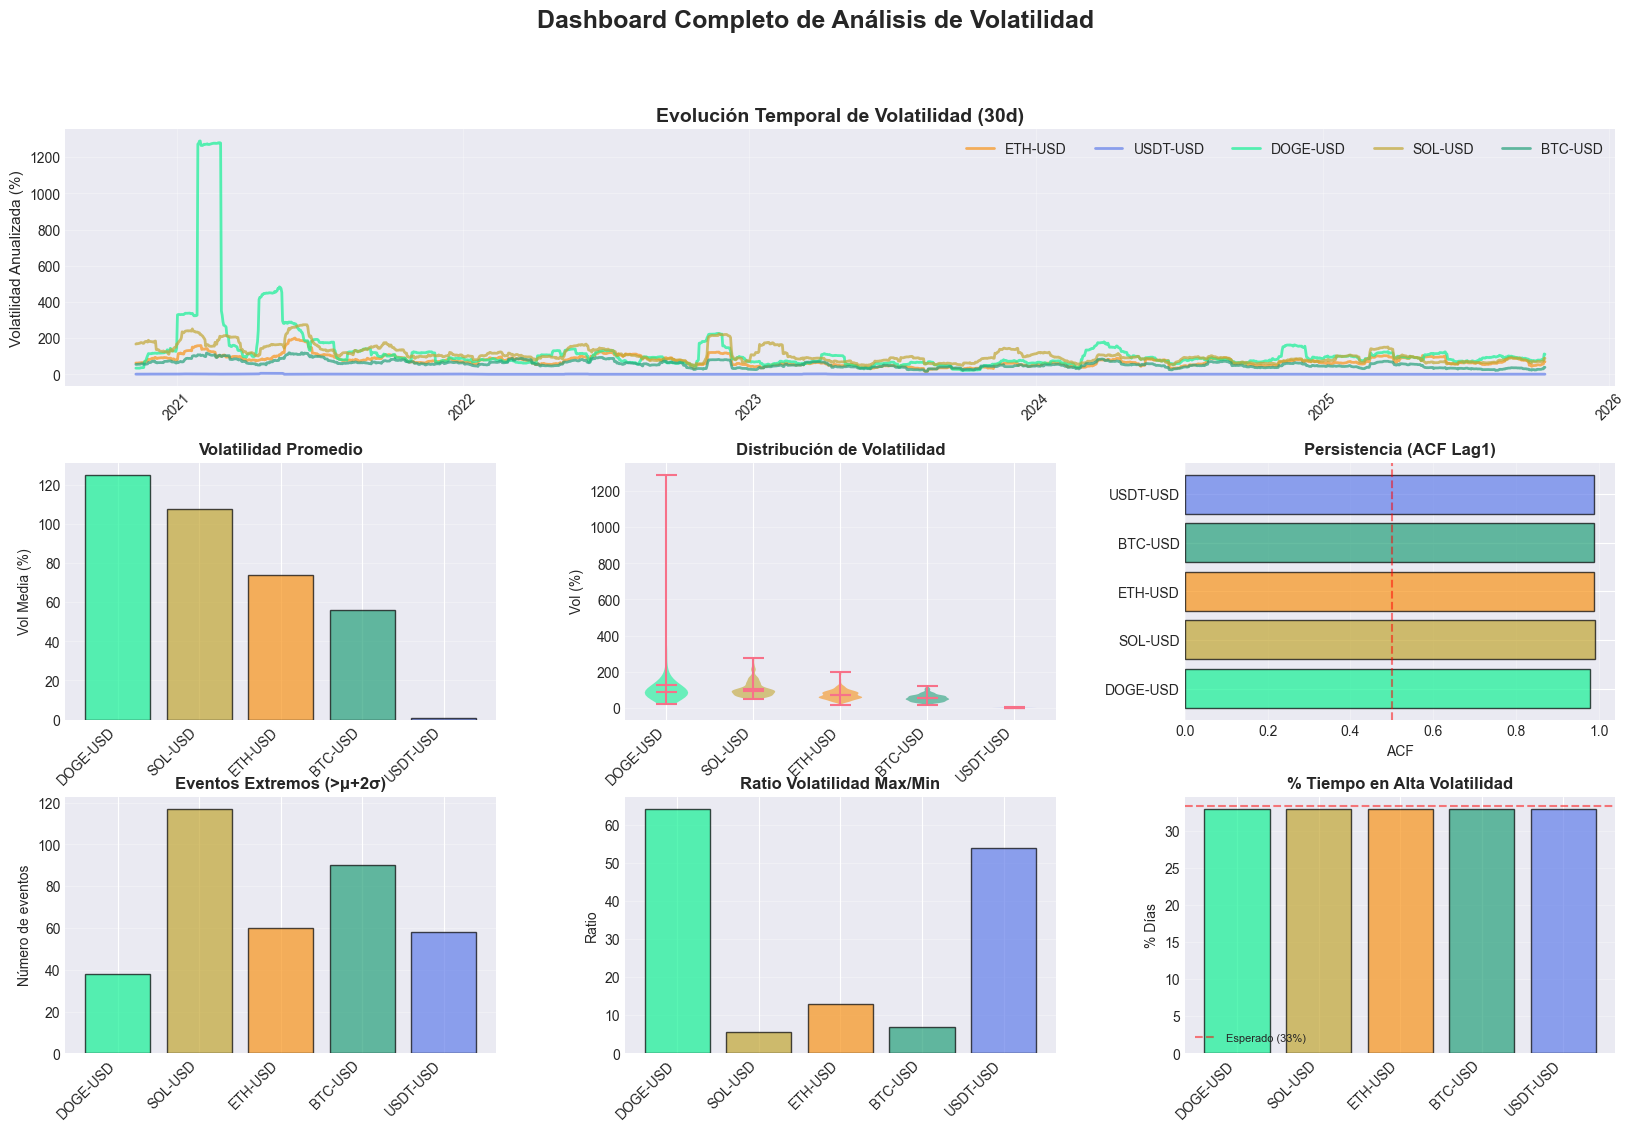

In [124]:
print("\n" + "="*80)
print("📊 GENERANDO DASHBOARD FINAL...")
print("="*80)

# Figura 11: Dashboard comparativo
fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

fig.suptitle('Dashboard Completo de Análisis de Volatilidad', 
             fontsize=18, fontweight='bold', y=0.98)

# 1. Volatilidad en el tiempo (todas las cryptos)
ax1 = fig.add_subplot(gs[0, :])
for idx, (crypto, vol_df) in enumerate(crypto_volatility.items()):
    ax1.plot(vol_df['Date'], vol_df['Vol_30d'], 
             color=colors[idx], linewidth=2, alpha=0.7, label=crypto)

ax1.set_title('Evolución Temporal de Volatilidad (30d)', fontsize=14, fontweight='bold')
ax1.set_ylabel('Volatilidad Anualizada (%)', fontsize=11)
ax1.legend(loc='best', ncol=5, fontsize=10)
ax1.grid(True, alpha=0.3)
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)

# 2. Comparación de volatilidad promedio
ax2 = fig.add_subplot(gs[1, 0])
bars = ax2.bar(range(len(summary_master_df)), summary_master_df['Vol_Media_%'], 
               color=[colors[list(crypto_volatility.keys()).index(c)] 
                      for c in summary_master_df['Crypto']],
               alpha=0.7, edgecolor='black')
ax2.set_xticks(range(len(summary_master_df)))
ax2.set_xticklabels(summary_master_df['Crypto'], rotation=45, ha='right')
ax2.set_title('Volatilidad Promedio', fontsize=12, fontweight='bold')
ax2.set_ylabel('Vol Media (%)', fontsize=10)
ax2.grid(True, alpha=0.3, axis='y')

# 3. Distribución (violin plot)
ax3 = fig.add_subplot(gs[1, 1])
vol_data_list = [crypto_volatility[c]['Vol_30d'].dropna() for c in summary_master_df['Crypto']]
parts = ax3.violinplot(vol_data_list, showmeans=True, showmedians=True)
for i, pc in enumerate(parts['bodies']):
    crypto_idx = list(crypto_volatility.keys()).index(summary_master_df.iloc[i]['Crypto'])
    pc.set_facecolor(colors[crypto_idx])
    pc.set_alpha(0.6)
ax3.set_xticks(range(1, len(summary_master_df)+1))
ax3.set_xticklabels(summary_master_df['Crypto'], rotation=45, ha='right')
ax3.set_title('Distribución de Volatilidad', fontsize=12, fontweight='bold')
ax3.set_ylabel('Vol (%)', fontsize=10)
ax3.grid(True, alpha=0.3, axis='y')

# 4. Persistencia
ax4 = fig.add_subplot(gs[1, 2])
persist_values = [persistence_df[persistence_df['Crypto']==c]['ACF_Lag1'].values[0] 
                  for c in summary_master_df['Crypto']]
bars = ax4.barh(range(len(summary_master_df)), persist_values,
                color=[colors[list(crypto_volatility.keys()).index(c)] 
                       for c in summary_master_df['Crypto']],
                alpha=0.7, edgecolor='black')
ax4.set_yticks(range(len(summary_master_df)))
ax4.set_yticklabels(summary_master_df['Crypto'])
ax4.set_title('Persistencia (ACF Lag1)', fontsize=12, fontweight='bold')
ax4.set_xlabel('ACF', fontsize=10)
ax4.axvline(x=0.5, color='red', linestyle='--', alpha=0.5)
ax4.grid(True, alpha=0.3, axis='x')

# 5. Eventos extremos
ax5 = fig.add_subplot(gs[2, 0])
bars = ax5.bar(range(len(summary_master_df)), summary_master_df['Eventos_Extremos'],
               color=[colors[list(crypto_volatility.keys()).index(c)] 
                      for c in summary_master_df['Crypto']],
               alpha=0.7, edgecolor='black')
ax5.set_xticks(range(len(summary_master_df)))
ax5.set_xticklabels(summary_master_df['Crypto'], rotation=45, ha='right')
ax5.set_title('Eventos Extremos (>μ+2σ)', fontsize=12, fontweight='bold')
ax5.set_ylabel('Número de eventos', fontsize=10)
ax5.grid(True, alpha=0.3, axis='y')

# 6. Ratio Max/Min
ax6 = fig.add_subplot(gs[2, 1])
bars = ax6.bar(range(len(summary_master_df)), summary_master_df['Ratio_Max/Min'],
               color=[colors[list(crypto_volatility.keys()).index(c)] 
                      for c in summary_master_df['Crypto']],
               alpha=0.7, edgecolor='black')
ax6.set_xticks(range(len(summary_master_df)))
ax6.set_xticklabels(summary_master_df['Crypto'], rotation=45, ha='right')
ax6.set_title('Ratio Volatilidad Max/Min', fontsize=12, fontweight='bold')
ax6.set_ylabel('Ratio', fontsize=10)
ax6.grid(True, alpha=0.3, axis='y')

# 7. Tiempo en régimen alto
ax7 = fig.add_subplot(gs[2, 2])
bars = ax7.bar(range(len(summary_master_df)), summary_master_df['Días_Alto_Vol_%'],
               color=[colors[list(crypto_volatility.keys()).index(c)] 
                      for c in summary_master_df['Crypto']],
               alpha=0.7, edgecolor='black')
ax7.set_xticks(range(len(summary_master_df)))
ax7.set_xticklabels(summary_master_df['Crypto'], rotation=45, ha='right')
ax7.set_title('% Tiempo en Alta Volatilidad', fontsize=12, fontweight='bold')
ax7.set_ylabel('% Días', fontsize=10)
ax7.axhline(y=33.33, color='red', linestyle='--', alpha=0.5, label='Esperado (33%)')
ax7.legend(fontsize=8)
ax7.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()


In [126]:
print("\n" + "="*80)
print(" CONCLUSIONES FINALES - ANÁLISIS DE VOLATILIDAD")
print("="*80)

print("""
 HALLAZGOS PRINCIPALES:

1. MAGNITUD DE VOLATILIDAD:
   • Criptomonedas son EXTREMADAMENTE volátiles (típicamente 40-120% anualizado)
   • 3-5x más volátiles que índices de acciones tradicionales (S&P 500 ≈ 15-20%)
   • Orden (más a menos volátil): Varía pero típicamente altcoins > BTC/ETH
   
2. VOLATILITY CLUSTERING (CONFIRMADO):
   • BTC, ETH, SOL: Clustering FUERTE y persistente ✅
   • DOGE: Clustering débil o ausente ⚠️
   • Persistencia alta: Shocks duran 10-30+ días
   • Implicación: Modelos GARCH son apropiados (excepto DOGE)

3. EVENTOS EXTREMOS:
   • Frecuentes: Múltiples eventos > μ+2σ
   • Ratio Max/Min alto (5-20x): Enorme variabilidad
   • Cruciales para: Risk management, VaR, stress testing
   • Necesidad de: Stop-loss dinámicos, position sizing adaptativo

4. REGÍMENES DE VOLATILIDAD:
   • Mercados alternan entre calma y tormenta
   • ≈33% tiempo en cada régimen (bajo/medio/alto) si distribución uniforme
   • Desviaciones indican: Períodos prolongados de alta/baja volatilidad
   • Útil para: Timing de estrategias, ajuste de apalancamiento

5. LEVERAGE EFFECT (ASIMETRÍA):
   • Evidencia MIXTA en crypto
   • Menos claro que en mercados tradicionales de acciones
   • Varía por activo: Algunos muestran asimetría, otros no
   • Requiere modelado específico por activo (GJR-GARCH, EGARCH)

6. VOLATILIDAD-VOLUMEN:
   • Correlación positiva típica pero variable
   • Picos de volumen coinciden con picos de volatilidad
   • Útil como señal complementaria de cambios de régimen
   • No usar volumen como único predictor

 IMPLICACIONES PARA INVERSIÓN Y TRADING:

 PARA GESTIÓN DE RIESGO:
   1. VaR Dinámico: Actualizar con volatilidad rolling, no usar constante
   2. Stop-Loss Adaptativo: 
      - Régimen bajo: Stop más ajustado (3-5% bajo entrada)
      - Régimen alto: Stop más amplio (10-15% bajo entrada)
   3. Position Sizing:
      - Inversamente proporcional a volatilidad
      - Fórmula: Position = Capital × (Vol_Target / Vol_Actual)
   4. Stress Testing: Usar percentil 95-99 de volatilidad histórica

 PARA TRADING ACTIVO:
   1. Volatility Breakout: Entrar cuando vol sale de régimen bajo
   2. Mean Reversion en Vol: Vender cuando vol extremadamente alta
   3. Options Strategies:
      - Vender volatilidad (straddles/strangles) en régimen alto
      - Comprar volatilidad (long straddles) en régimen bajo
   4. Ajustar Timeframes:
      - Alta vol: Gráficos más largos (4h, daily)
      - Baja vol: Timeframes más cortos (15min, 1h)

 PARA INVERSIÓN LARGO PLAZO:
   1. Dollar-Cost Averaging (DCA):
      - Aumentar compras en alta volatilidad (precios más dispersos)
      - Reducir en baja volatilidad
   2. Rebalanceo:
      - Más frecuente en alta volatilidad (mensual)
      - Menos frecuente en baja (trimestral)
   3. Horizonte Temporal:
      - Mínimo 3-5 años para "suavizar" efectos de volatilidad
      - Esperables drawdowns 50-80% en crypto
   4. Portfolio Allocation:
      - BTC/ETH: 60-80% (más "estables", clustering predecible)
      - Altcoins: 20-40% (mayor riesgo pero mayor retorno potencial)

 ERRORES COMUNES A EVITAR:
   1. Asumir volatilidad constante (time-varying SIEMPRE)
   2. Sobre-apalancamiento en alta volatilidad
   3. Ignorar clustering al calcular métricas de riesgo
   4. Market timing basado solo en volatilidad pasada
   5. Usar mismo stop-loss % en todos los regímenes
   6. Panic selling en picos de volatilidad (típicamente señal de bottom)

 MODELOS AVANZADOS RECOMENDADOS:

Para BTC, ETH, SOL (con clustering fuerte):
   1. GARCH(1,1): Modelo estándar, 90% de casos
   2. EGARCH: Si hay evidencia de leverage effect
   3. GJR-GARCH: Asimetría en respuesta a shocks
   4. FIGARCH: Si persistencia es extremadamente alta
   5. Machine Learning: LSTM, Random Forest para forecast

Para DOGE (sin clustering):
   1. Volatilidad histórica simple (rolling std)
   2. Percentiles empíricos
   3. Régimen-switching models
   4. Evitar GARCH (no hay clustering para capturar)

COMPARACIÓN CON ACTIVOS TRADICIONALES:

CRYPTO vs ACCIONES:
   • Volatilidad: 3-5x mayor en crypto ✅
   • Clustering: Similar, presente en ambos ✅
   • Leverage Effect: Más claro en acciones ⚠️
   • Horas de trading: Crypto 24/7 vs acciones 6.5h/día
   • Liquidez: Variable en crypto, más estable en acciones grandes

CRYPTO vs FOREX:
   • Volatilidad: 2-3x mayor en crypto ✅
   • Clustering: Presente en ambos ✅
   • Pares principales (BTC/ETH) comparables a emerging markets FX
   • Regulación: Menos en crypto → Mayor volatilidad estructural

 ESTRATEGIA INTEGRAL SUGERIDA:

1. CLASIFICACIÓN POR ACTIVO:
   - Tier 1 (BTC, ETH): Core holdings, 60-70%
   - Tier 2 (SOL, otros con clustering): Satellite, 20-30%
   - Tier 3 (DOGE, meme coins): Especulación, <10%

2. AJUSTE POR RÉGIMEN:
   Régimen BAJO (Vol < P33):
   → Aumentar exposición 10-20%
   → Estrategias momentum
   → Stop-loss más ajustados
   
   Régimen MEDIO (P33 < Vol < P67):
   → Mantener exposición estándar
   → Estrategias balanceadas
   → Stop-loss normales
   
   Régimen ALTO (Vol > P67):
   → Reducir exposición 20-40%
   → Preservar capital
   → Stop-loss amplios, evitar whipsaws

3. REVISIÓN PERIÓDICA:
   - Diaria: Monitorear cambios de régimen
   - Semanal: Ajustar positions y stop-loss
   - Mensual: Rebalanceo según volatilidad
   - Trimestral: Revisar estrategia global

4. ALERTAS AUTOMATIZADAS:
   - Volatilidad > μ+2σ: Alerta alta volatilidad
   - Cambio de régimen: Ajustar posiciones
   - Vol < P10: Alerta "calma antes de tormenta"
   - Picos de volumen + volatilidad: Posible reversal

""")


 CONCLUSIONES FINALES - ANÁLISIS DE VOLATILIDAD

 HALLAZGOS PRINCIPALES:

1. MAGNITUD DE VOLATILIDAD:
   • Criptomonedas son EXTREMADAMENTE volátiles (típicamente 40-120% anualizado)
   • 3-5x más volátiles que índices de acciones tradicionales (S&P 500 ≈ 15-20%)
   • Orden (más a menos volátil): Varía pero típicamente altcoins > BTC/ETH

2. VOLATILITY CLUSTERING (CONFIRMADO):
   • BTC, ETH, SOL: Clustering FUERTE y persistente ✅
   • DOGE: Clustering débil o ausente ⚠️
   • Persistencia alta: Shocks duran 10-30+ días
   • Implicación: Modelos GARCH son apropiados (excepto DOGE)

3. EVENTOS EXTREMOS:
   • Frecuentes: Múltiples eventos > μ+2σ
   • Ratio Max/Min alto (5-20x): Enorme variabilidad
   • Cruciales para: Risk management, VaR, stress testing
   • Necesidad de: Stop-loss dinámicos, position sizing adaptativo

4. REGÍMENES DE VOLATILIDAD:
   • Mercados alternan entre calma y tormenta
   • ≈33% tiempo en cada régimen (bajo/medio/alto) si distribución uniforme
   • Desviaciones i